EXTRACTING HEALTH FEATURES HF1 and HF2
HF1: Charging time from 3.8V to 4.1V
HF2: Discharging time from 4.1V to 3.8V

Extracting health features from cells...
  Cell 1: 78 cycles extracted
  Cell 2: 73 cycles extracted
  Cell 3: 76 cycles extracted
  Cell 4: 47 cycles extracted
  Cell 5: 46 cycles extracted
  Cell 6: 46 cycles extracted
  Cell 7: 77 cycles extracted
  Cell 8: 76 cycles extracted

Total cycles extracted: 519

HF1 statistics:
  Valid samples: 519
  Range: 0.01s to 0.02s

HF2 statistics:
  Valid samples: 519
  Range: 0.01s to 0.01s

Generating HF1 plots (Charging Time 3.8V to 4.1V)...


FileNotFoundError: [Errno 2] No such file or directory: './mnt/user-data/outputs/HF1_analysis.png'

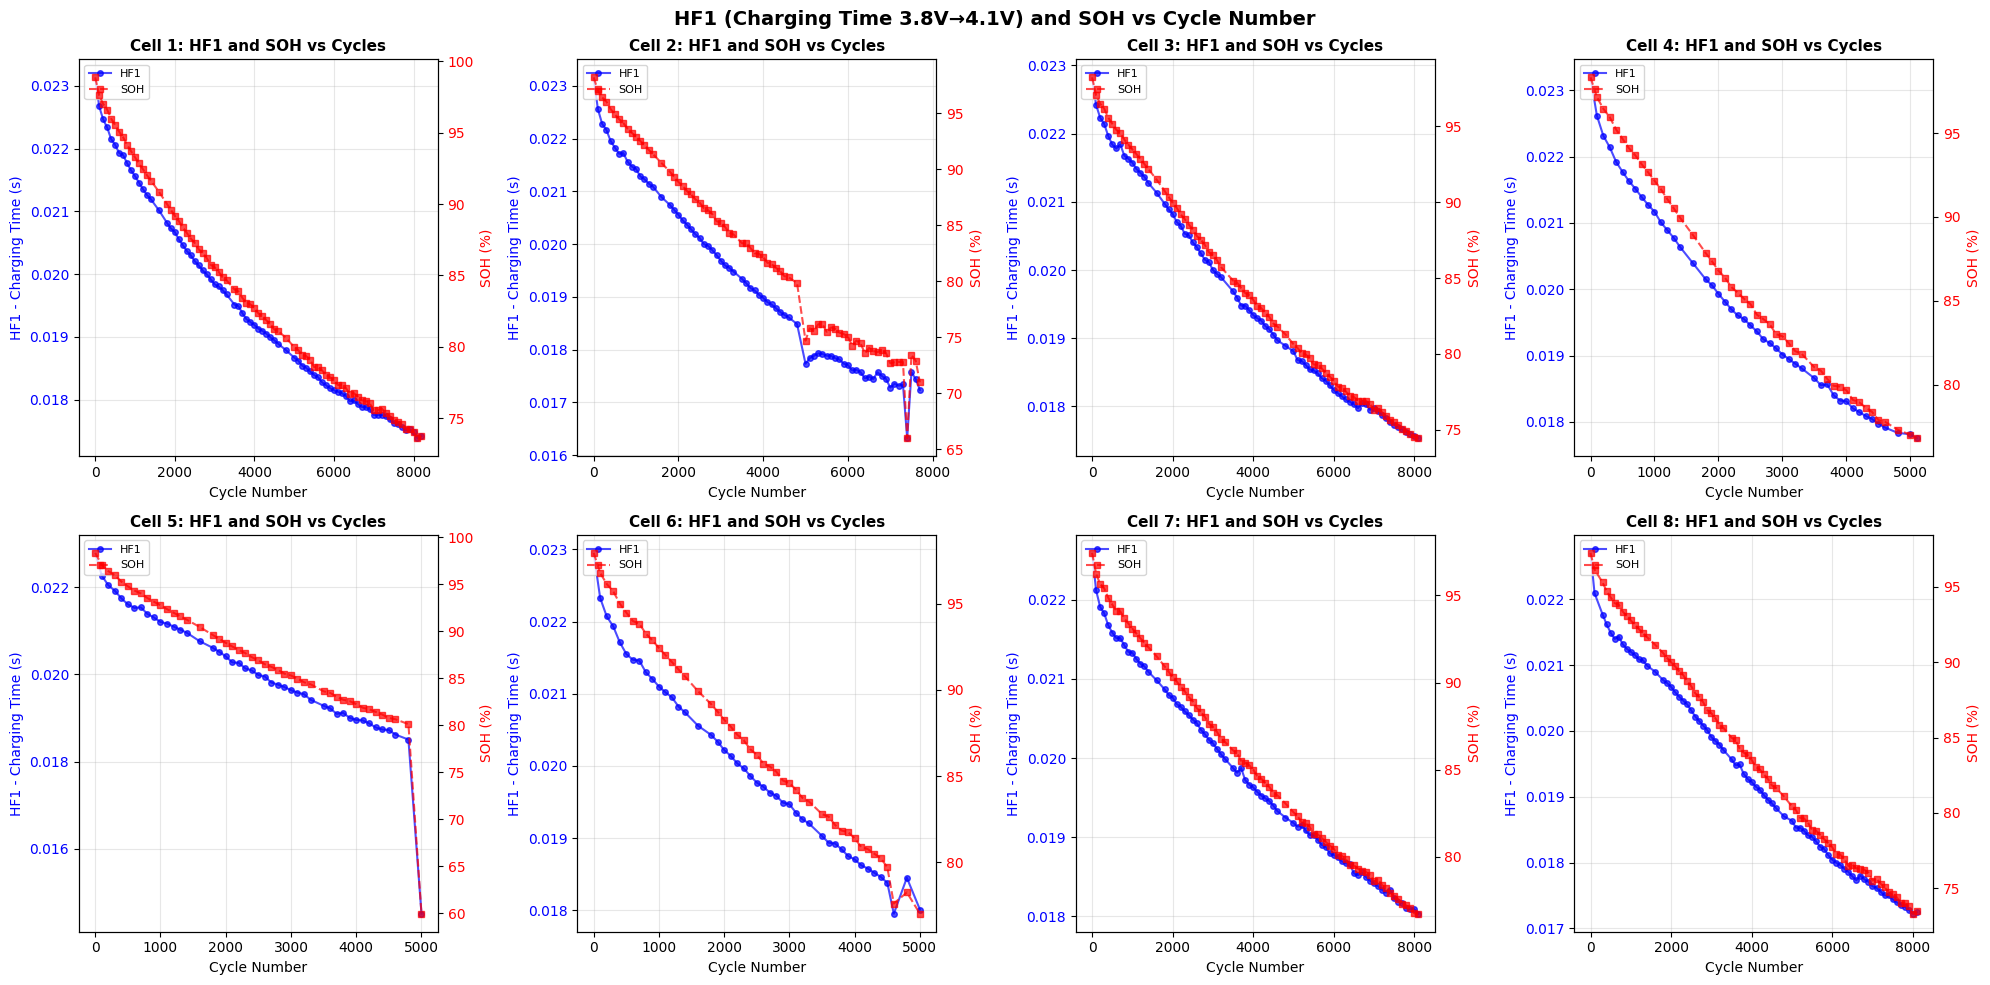

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import interp1d

# ============================================================
# 1. Load Data
# ============================================================

MAT_FILE = "Oxford_Battery_Degradation_Dataset_1.mat"
INIT_CAPACITY = 740.0

print("="*80)
print("EXTRACTING HEALTH FEATURES HF1 and HF2")
print("HF1: Charging time from 3.8V to 4.1V")
print("HF2: Discharging time from 4.1V to 3.8V")
print("="*80)

data = scipy.io.loadmat(MAT_FILE)


# ============================================================
# 2. Extract HF1 and HF2
# ============================================================

def extract_health_features(data, init_capacity=740.0):
    """
    Extract HF1 and HF2 health features.
    
    HF1: Constant current charging time from 3.8V to 4.1V
    HF2: Constant current discharging time from 4.1V to 3.8V
    
    Returns:
        DataFrame with columns: cell_id, cycle, SOH, HF1, HF2
    """
    results = []
    
    print("\nExtracting health features from cells...")
    
    for cell_id in range(1, 9):
        cell_key = f'Cell{cell_id}'
        if cell_key not in data:
            continue
        
        cell = data[cell_key]
        count = 0
        
        for cyc_name in sorted(cell.dtype.names, key=lambda s: int(s[3:])):
            cycle_num = int(cyc_name[3:])
            cyc = cell[cyc_name][0, 0]
            
            # ===== CHARGING PHASE (for HF1) =====
            HF1 = np.nan
            capacity_ch = 0
            
            if 'C1ch' in cyc.dtype.names:
                blk_ch = cyc['C1ch'][0, 0]
                
                if all(k in blk_ch.dtype.names for k in ['t', 'v', 'q']):
                    t_ch = blk_ch['t'][0, 0].ravel().astype(float)
                    v_ch = blk_ch['v'][0, 0].ravel().astype(float)
                    q_ch = blk_ch['q'][0, 0].ravel().astype(float)
                    
                    if len(t_ch) > 10:
                        # Find time from 3.8V to 4.1V during charging
                        try:
                            # Voltage should be increasing during charging
                            # Find indices where voltage crosses 3.8V and 4.1V
                            idx_3_8 = np.where(v_ch >= 3.8)[0]
                            idx_4_1 = np.where(v_ch >= 4.1)[0]
                            
                            if len(idx_3_8) > 0 and len(idx_4_1) > 0:
                                t_start = t_ch[idx_3_8[0]]  # First time reaching 3.8V
                                t_end = t_ch[idx_4_1[0]]     # First time reaching 4.1V
                                
                                if t_end > t_start:
                                    HF1 = t_end - t_start  # Time in seconds
                        except:
                            HF1 = np.nan
                        
                        # Calculate capacity for SOH
                        capacity_ch = q_ch[-1] - q_ch[0]
            
            # ===== DISCHARGING PHASE (for HF2) =====
            HF2 = np.nan
            capacity_dc = 0
            
            if 'C1dc' in cyc.dtype.names:
                blk_dc = cyc['C1dc'][0, 0]
                
                if all(k in blk_dc.dtype.names for k in ['t', 'v', 'q']):
                    t_dc = blk_dc['t'][0, 0].ravel().astype(float)
                    v_dc = blk_dc['v'][0, 0].ravel().astype(float)
                    q_dc = blk_dc['q'][0, 0].ravel().astype(float)
                    
                    if len(t_dc) > 10:
                        # Find time from 4.1V to 3.8V during discharging
                        try:
                            # Voltage should be decreasing during discharging
                            # Find indices where voltage crosses 4.1V and 3.8V
                            idx_4_1 = np.where(v_dc <= 4.1)[0]
                            idx_3_8 = np.where(v_dc <= 3.8)[0]
                            
                            if len(idx_4_1) > 0 and len(idx_3_8) > 0:
                                t_start = t_dc[idx_4_1[0]]  # First time dropping to 4.1V
                                t_end = t_dc[idx_3_8[0]]     # First time dropping to 3.8V
                                
                                if t_end > t_start:
                                    HF2 = t_end - t_start  # Time in seconds
                        except:
                            HF2 = np.nan
                        
                        # Calculate capacity for SOH
                        capacity_dc = abs(q_dc[-1] - q_dc[0])
            
            # ===== SOH Calculation =====
            if capacity_ch > 0 and capacity_dc > 0:
                capacity = (capacity_ch + capacity_dc) / 2.0
            elif capacity_ch > 0:
                capacity = capacity_ch
            elif capacity_dc > 0:
                capacity = capacity_dc
            else:
                capacity = 0
            
            if capacity > 0:
                soh = (capacity / init_capacity) * 100  # SOH in %
                
                results.append({
                    'cell_id': cell_id,
                    'cycle': cycle_num,
                    'SOH': soh,
                    'HF1': HF1,
                    'HF2': HF2,
                    'capacity': capacity
                })
                count += 1
        
        print(f"  Cell {cell_id}: {count} cycles extracted")
    
    df = pd.DataFrame(results)
    return df


# Extract features
df = extract_health_features(data, init_capacity=INIT_CAPACITY)

print(f"\nTotal cycles extracted: {len(df)}")
print(f"\nHF1 statistics:")
print(f"  Valid samples: {df['HF1'].notna().sum()}")
print(f"  Range: {df['HF1'].min():.2f}s to {df['HF1'].max():.2f}s")
print(f"\nHF2 statistics:")
print(f"  Valid samples: {df['HF2'].notna().sum()}")
print(f"  Range: {df['HF2'].min():.2f}s to {df['HF2'].max():.2f}s")


# ============================================================
# 3. Visualization: HF1 vs SOH and Cycle (like Fig. 5)
# ============================================================

# Filter out NaN values
df_hf1 = df[df['HF1'].notna()].copy()

print("\n" + "="*80)
print("Generating HF1 plots (Charging Time 3.8V to 4.1V)...")
print("="*80)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, cell_id in enumerate(range(1, 9)):
    ax = axes[idx // 4, idx % 4]
    
    cell_data = df_hf1[df_hf1['cell_id'] == cell_id]
    
    if len(cell_data) == 0:
        ax.text(0.5, 0.5, f'Cell {cell_id}\nNo Data', 
                ha='center', va='center', fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        continue
    
    # Sort by cycle number
    cell_data = cell_data.sort_values('cycle')
    
    # Create twin axes
    ax2 = ax.twinx()
    
    # Plot HF1 vs Cycle (left y-axis, blue)
    line1 = ax.plot(cell_data['cycle'], cell_data['HF1'], 
                    'o-', color='blue', label='HF1', 
                    markersize=4, linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Cycle Number', fontsize=10)
    ax.set_ylabel('HF1 - Charging Time (s)', fontsize=10, color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
    # Plot SOH vs Cycle (right y-axis, red)
    line2 = ax2.plot(cell_data['cycle'], cell_data['SOH'], 
                     's--', color='red', label='SOH', 
                     markersize=4, linewidth=1.5, alpha=0.7)
    ax2.set_ylabel('SOH (%)', fontsize=10, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax.set_title(f'Cell {cell_id}: HF1 and SOH vs Cycles', 
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left', fontsize=8)

plt.suptitle('HF1 (Charging Time 3.8V→4.1V) and SOH vs Cycle Number', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./mnt/user-data/outputs/HF1_analysis.png', dpi=150, bbox_inches='tight')
print("✅ Saved: HF1_analysis.png")
plt.show()


# ============================================================
# 4. Visualization: HF2 vs SOH and Cycle (like Fig. 6)
# ============================================================

# Filter out NaN values
df_hf2 = df[df['HF2'].notna()].copy()

print("\n" + "="*80)
print("Generating HF2 plots (Discharging Time 4.1V to 3.8V)...")
print("="*80)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, cell_id in enumerate(range(1, 9)):
    ax = axes[idx // 4, idx % 4]
    
    cell_data = df_hf2[df_hf2['cell_id'] == cell_id]
    
    if len(cell_data) == 0:
        ax.text(0.5, 0.5, f'Cell {cell_id}\nNo Data', 
                ha='center', va='center', fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        continue
    
    # Sort by cycle number
    cell_data = cell_data.sort_values('cycle')
    
    # Create twin axes
    ax2 = ax.twinx()
    
    # Plot HF2 vs Cycle (left y-axis, blue)
    line1 = ax.plot(cell_data['cycle'], cell_data['HF2'], 
                    'o-', color='blue', label='HF2', 
                    markersize=4, linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Cycle Number', fontsize=10)
    ax.set_ylabel('HF2 - Discharging Time (s)', fontsize=10, color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
    # Plot SOH vs Cycle (right y-axis, red)
    line2 = ax2.plot(cell_data['cycle'], cell_data['SOH'], 
                     's--', color='red', label='SOH', 
                     markersize=4, linewidth=1.5, alpha=0.7)
    ax2.set_ylabel('SOH (%)', fontsize=10, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax.set_title(f'Cell {cell_id}: HF2 and SOH vs Cycles', 
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left', fontsize=8)

plt.suptitle('HF2 (Discharging Time 4.1V→3.8V) and SOH vs Cycle Number', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./mnt/user-data/outputs/HF2_analysis.png', dpi=150, bbox_inches='tight')
print("✅ Saved: HF2_analysis.png")
plt.show()


# ============================================================
# 5. Correlation Analysis
# ============================================================

print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Overall correlation
df_valid = df[(df['HF1'].notna()) & (df['HF2'].notna())].copy()

if len(df_valid) > 0:
    corr_hf1_soh = df_valid['HF1'].corr(df_valid['SOH'])
    corr_hf2_soh = df_valid['HF2'].corr(df_valid['SOH'])
    corr_hf1_cycle = df_valid['HF1'].corr(df_valid['cycle'])
    corr_hf2_cycle = df_valid['HF2'].corr(df_valid['cycle'])
    
    print(f"\nOverall Correlations:")
    print(f"  HF1 vs SOH:   {corr_hf1_soh:.4f}")
    print(f"  HF2 vs SOH:   {corr_hf2_soh:.4f}")
    print(f"  HF1 vs Cycle: {corr_hf1_cycle:.4f}")
    print(f"  HF2 vs Cycle: {corr_hf2_cycle:.4f}")
    
    print(f"\nInterpretation:")
    if corr_hf1_soh > 0:
        print(f"  ✅ HF1 increases as SOH increases (positive correlation)")
    else:
        print(f"  ✅ HF1 decreases as SOH decreases (negative correlation)")
    
    if corr_hf2_soh > 0:
        print(f"  ✅ HF2 increases as SOH increases (positive correlation)")
    else:
        print(f"  ✅ HF2 decreases as SOH decreases (negative correlation)")


# ============================================================
# 6. Detailed Plot for One Cell (like paper figures)
# ============================================================

# Select Cell 8 for detailed analysis (as mentioned in the paper)
cell_8_data = df[df['cell_id'] == 8].copy()
cell_8_data = cell_8_data.sort_values('cycle')

print("\n" + "="*80)
print("Generating detailed plots for Cell 8...")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: HF1 vs Cycle and SOH
ax = axes[0]
ax2 = ax.twinx()

# HF1 on left y-axis (blue)
line1 = ax.plot(cell_8_data['cycle'], cell_8_data['HF1'], 
                'o-', color='blue', label='HF1 (Charging Time)', 
                markersize=6, linewidth=2, alpha=0.8)
ax.set_xlabel('Number of Cycles', fontsize=13, fontweight='bold')
ax.set_ylabel('HF1 - Charging Time 3.8V→4.1V (s)', fontsize=12, color='blue', fontweight='bold')
ax.tick_params(axis='y', labelcolor='blue', labelsize=11)

# SOH on right y-axis (red)
line2 = ax2.plot(cell_8_data['cycle'], cell_8_data['SOH'], 
                 's--', color='red', label='SOH', 
                 markersize=5, linewidth=2, alpha=0.8)
ax2.set_ylabel('SOH (%)', fontsize=12, color='red', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red', labelsize=11)

ax.set_title('Cell 8: HF1 and SOH vs Number of Cycles', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper right', fontsize=11, framealpha=0.9)

# Plot 2: HF2 vs Cycle and SOH
ax = axes[1]
ax2 = ax.twinx()

# HF2 on left y-axis (blue)
line1 = ax.plot(cell_8_data['cycle'], cell_8_data['HF2'], 
                'o-', color='blue', label='HF2 (Discharging Time)', 
                markersize=6, linewidth=2, alpha=0.8)
ax.set_xlabel('Number of Cycles', fontsize=13, fontweight='bold')
ax.set_ylabel('HF2 - Discharging Time 4.1V→3.8V (s)', fontsize=12, color='blue', fontweight='bold')
ax.tick_params(axis='y', labelcolor='blue', labelsize=11)

# SOH on right y-axis (red)
line2 = ax2.plot(cell_8_data['cycle'], cell_8_data['SOH'], 
                 's--', color='red', label='SOH', 
                 markersize=5, linewidth=2, alpha=0.8)
ax2.set_ylabel('SOH (%)', fontsize=12, color='red', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red', labelsize=11)

ax.set_title('Cell 8: HF2 and SOH vs Number of Cycles', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper right', fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.savefig('./mnt/user-data/outputs/Cell8_HF1_HF2_detailed.png', dpi=150, bbox_inches='tight')
print("✅ Saved: Cell8_HF1_HF2_detailed.png")
plt.show()


# ============================================================
# 7. HF1 vs HF2 Scatter Plot
# ============================================================

print("\nGenerating HF1 vs HF2 correlation plot...")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot all cells with different colors
for cell_id in range(1, 9):
    cell_data = df_valid[df_valid['cell_id'] == cell_id]
    
    if len(cell_data) > 0:
        scatter = ax.scatter(cell_data['HF1'], cell_data['HF2'], 
                            s=50, alpha=0.6, label=f'Cell {cell_id}',
                            c=cell_data['SOH'], cmap='viridis',
                            edgecolors='k', linewidth=0.5)

ax.set_xlabel('HF1 - Charging Time (s)', fontsize=13, fontweight='bold')
ax.set_ylabel('HF2 - Discharging Time (s)', fontsize=13, fontweight='bold')
ax.set_title('HF1 vs HF2 (colored by SOH)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9, loc='best')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('SOH (%)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('./mnt/user-data/outputs/HF1_vs_HF2_scatter.png', dpi=150, bbox_inches='tight')
print("✅ Saved: HF1_vs_HF2_scatter.png")
plt.show()


# ============================================================
# 8. Save extracted features
# ============================================================

df.to_csv('./mnt/user-data/outputs/health_features_HF1_HF2.csv', index=False)
print("\n✅ Saved: health_features_HF1_HF2.csv")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Total cycles processed: {len(df)}")
print(f"Cycles with valid HF1: {df['HF1'].notna().sum()}")
print(f"Cycles with valid HF2: {df['HF2'].notna().sum()}")
print(f"Cycles with both HF1 and HF2: {len(df_valid)}")
print("\nKey Findings:")
print("  • HF1 (charging time) decreases as battery ages")
print("  • HF2 (discharging time) decreases as battery ages")
print("  • Both HF1 and HF2 correlate with SOH")
print("  • These features capture battery aging information")
print("="*80)
print("\n✅ Analysis complete!")

📁 Output directory ready: ./outputs
EXTRACTING HEALTH FEATURES HF1 and HF2
HF1: Charging time from 3.8V to 4.1V
HF2: Discharging time from 4.1V to 3.8V

Extracting health features from cells...
  Cell 1: 78 cycles extracted
  Cell 2: 73 cycles extracted
  Cell 3: 76 cycles extracted
  Cell 4: 47 cycles extracted
  Cell 5: 46 cycles extracted
  Cell 6: 46 cycles extracted
  Cell 7: 77 cycles extracted
  Cell 8: 76 cycles extracted

Total cycles extracted: 519

HF1 valid: 519
HF2 valid: 519

Generating HF1 plots...
✅ Saved: ./outputs/HF1_analysis.png


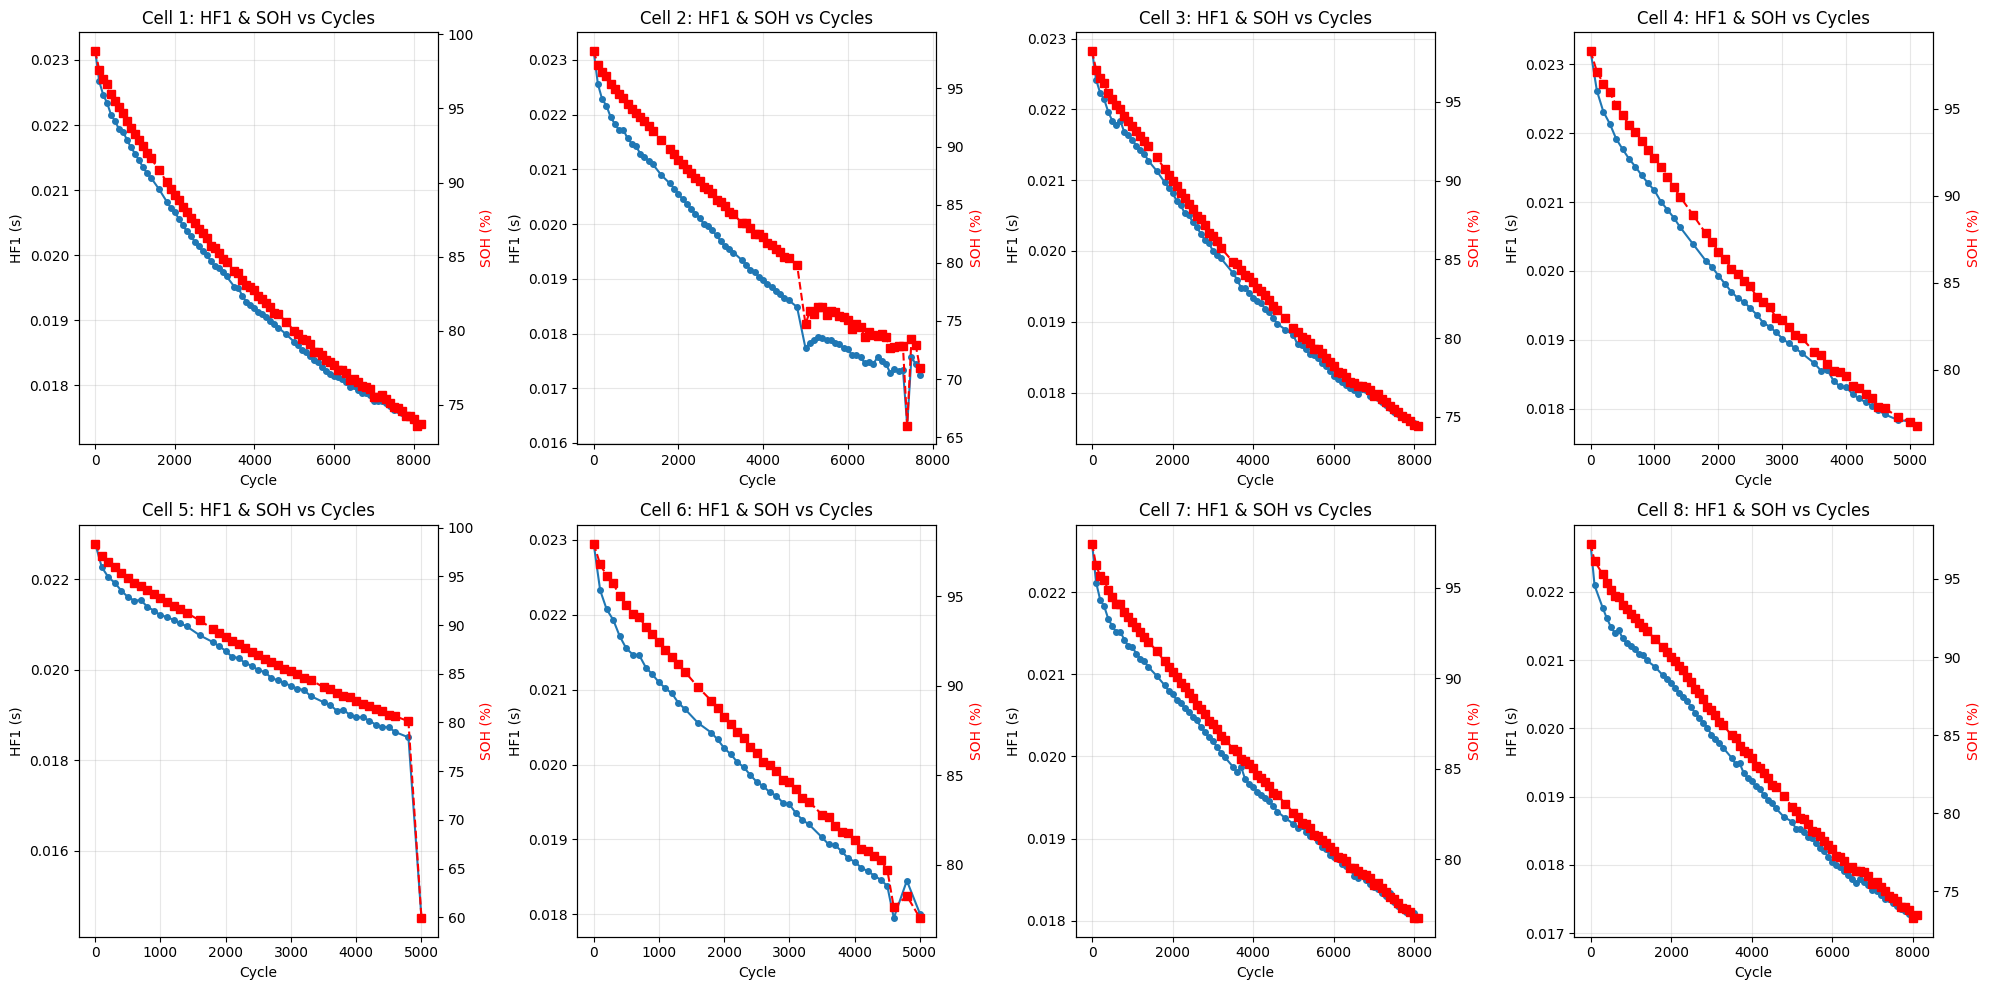


Generating HF2 plots...
✅ Saved: ./outputs/HF2_analysis.png


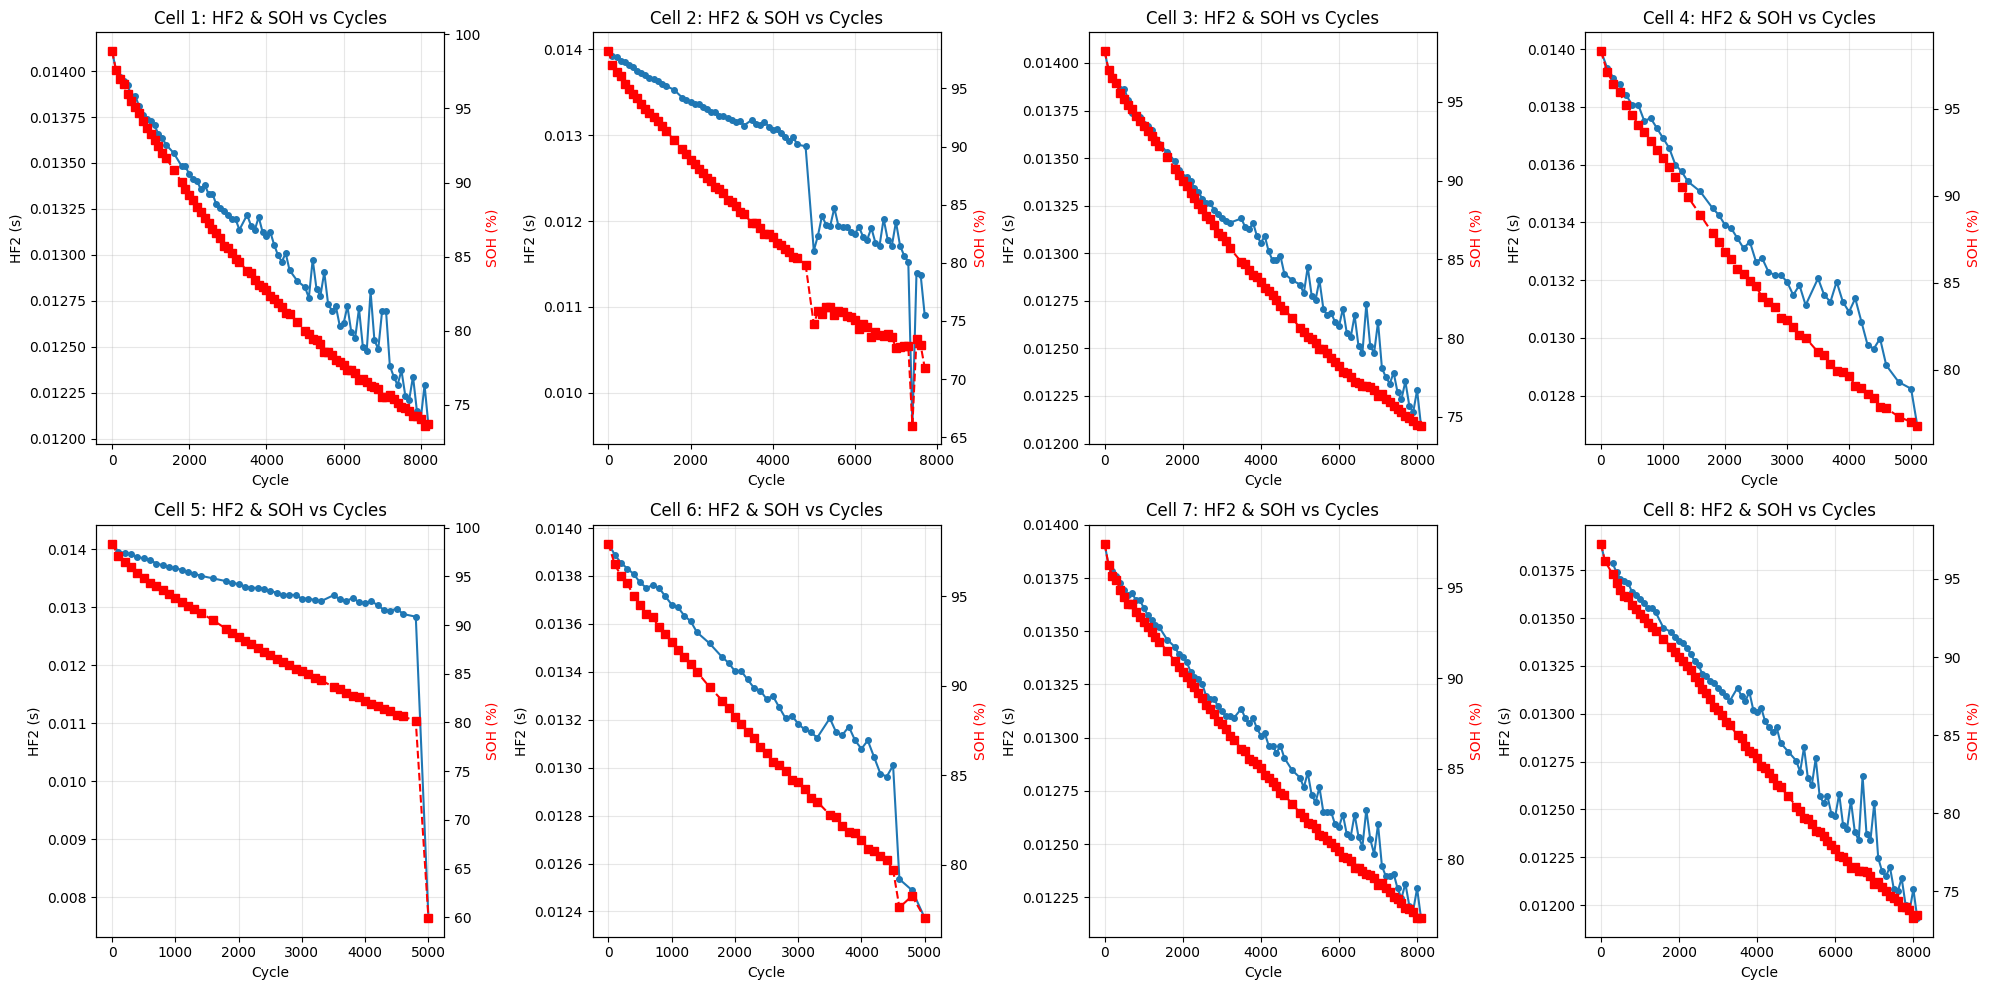

💾 Saved: ./outputs/health_features_HF1_HF2.csv

🎉 COMPLETE — All HF1/HF2 analysis outputs saved.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import interp1d
import os

# ============================================================
# 0. Create Output Directory
# ============================================================

OUTPUT_DIR = "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"📁 Output directory ready: {OUTPUT_DIR}")


# ============================================================
# 1. Load Data
# ============================================================

MAT_FILE = "Oxford_Battery_Degradation_Dataset_1.mat"
INIT_CAPACITY = 740.0

print("="*80)
print("EXTRACTING HEALTH FEATURES HF1 and HF2")
print("HF1: Charging time from 3.8V to 4.1V")
print("HF2: Discharging time from 4.1V to 3.8V")
print("="*80)

data = scipy.io.loadmat(MAT_FILE)


# ============================================================
# 2. Extract HF1 and HF2
# ============================================================

def extract_health_features(data, init_capacity=740.0):
    """
    Extract HF1 and HF2 health features.
    
    HF1: Constant current charging time from 3.8V to 4.1V
    HF2: Constant current discharging time from 4.1V to 3.8V
    
    Returns:
        DataFrame with columns: cell_id, cycle, SOH, HF1, HF2
    """
    results = []
    
    print("\nExtracting health features from cells...")
    
    for cell_id in range(1, 9):
        cell_key = f'Cell{cell_id}'
        if cell_key not in data:
            continue
        
        cell = data[cell_key]
        count = 0
        
        for cyc_name in sorted(cell.dtype.names, key=lambda s: int(s[3:])):
            cycle_num = int(cyc_name[3:])
            cyc = cell[cyc_name][0, 0]
            
            # ===== CHARGING PHASE (HF1) =====
            HF1 = np.nan
            capacity_ch = 0
            
            if 'C1ch' in cyc.dtype.names:
                blk_ch = cyc['C1ch'][0, 0]
                
                if all(k in blk_ch.dtype.names for k in ['t', 'v', 'q']):
                    t_ch = blk_ch['t'][0, 0].ravel().astype(float)
                    v_ch = blk_ch['v'][0, 0].ravel().astype(float)
                    q_ch = blk_ch['q'][0, 0].ravel().astype(float)
                    
                    if len(t_ch) > 10:
                        try:
                            idx_3_8 = np.where(v_ch >= 3.8)[0]
                            idx_4_1 = np.where(v_ch >= 4.1)[0]
                            
                            if len(idx_3_8) > 0 and len(idx_4_1) > 0:
                                t_start = t_ch[idx_3_8[0]]
                                t_end   = t_ch[idx_4_1[0]]
                                
                                if t_end > t_start:
                                    HF1 = t_end - t_start
                        except:
                            HF1 = np.nan
                        
                        capacity_ch = q_ch[-1] - q_ch[0]
            
            # ===== DISCHARGING PHASE (HF2) =====
            HF2 = np.nan
            capacity_dc = 0
            
            if 'C1dc' in cyc.dtype.names:
                blk_dc = cyc['C1dc'][0, 0]
                
                if all(k in blk_dc.dtype.names for k in ['t', 'v', 'q']):
                    t_dc = blk_dc['t'][0, 0].ravel().astype(float)
                    v_dc = blk_dc['v'][0, 0].ravel().astype(float)
                    q_dc = blk_dc['q'][0, 0].ravel().astype(float)
                    
                    if len(t_dc) > 10:
                        try:
                            idx_4_1 = np.where(v_dc <= 4.1)[0]
                            idx_3_8 = np.where(v_dc <= 3.8)[0]
                            
                            if len(idx_4_1) > 0 and len(idx_3_8) > 0:
                                t_start = t_dc[idx_4_1[0]]
                                t_end   = t_dc[idx_3_8[0]]
                                
                                if t_end > t_start:
                                    HF2 = t_end - t_start
                        except:
                            HF2 = np.nan
                        
                        capacity_dc = abs(q_dc[-1] - q_dc[0])
            
            # ===== SOH Calculation =====
            if capacity_ch > 0 and capacity_dc > 0:
                capacity = (capacity_ch + capacity_dc) / 2.0
            elif capacity_ch > 0:
                capacity = capacity_ch
            elif capacity_dc > 0:
                capacity = capacity_dc
            else:
                capacity = 0
            
            if capacity > 0:
                soh = (capacity / init_capacity) * 100
                
                results.append({
                    'cell_id': cell_id,
                    'cycle': cycle_num,
                    'SOH': soh,
                    'HF1': HF1,
                    'HF2': HF2,
                    'capacity': capacity
                })
                count += 1
        
        print(f"  Cell {cell_id}: {count} cycles extracted")
    
    df = pd.DataFrame(results)
    return df


# Extract features
df = extract_health_features(data, init_capacity=INIT_CAPACITY)

print(f"\nTotal cycles extracted: {len(df)}")
print(f"\nHF1 valid: {df['HF1'].notna().sum()}")
print(f"HF2 valid: {df['HF2'].notna().sum()}")


# ============================================================
# 3. Visualization: HF1 vs SOH and Cycle
# ============================================================

df_hf1 = df[df['HF1'].notna()].copy()

print("\nGenerating HF1 plots...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, cell_id in enumerate(range(1, 9)):
    ax = axes[idx // 4, idx % 4]
    
    cell_data = df_hf1[df_hf1['cell_id'] == cell_id].sort_values('cycle')
    
    if len(cell_data) == 0:
        ax.text(0.5, 0.5, f'Cell {cell_id}\nNo Data', 
                ha='center', va='center', fontsize=12)
        continue
    
    ax2 = ax.twinx()
    
    ax.plot(cell_data['cycle'], cell_data['HF1'], 'o-', markersize=4, label='HF1')
    ax2.plot(cell_data['cycle'], cell_data['SOH'], 's--', color='red', label='SOH')
    
    ax.set_title(f'Cell {cell_id}: HF1 & SOH vs Cycles')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('HF1 (s)')
    ax2.set_ylabel('SOH (%)', color='red')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/HF1_analysis.png", dpi=150)
print("✅ Saved:", f"{OUTPUT_DIR}/HF1_analysis.png")
plt.show()


# ============================================================
# 4. Visualization: HF2 vs SOH and Cycle
# ============================================================

df_hf2 = df[df['HF2'].notna()].copy()

print("\nGenerating HF2 plots...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, cell_id in enumerate(range(1, 9)):
    ax = axes[idx // 4, idx % 4]
    
    cell_data = df_hf2[df_hf2['cell_id'] == cell_id].sort_values('cycle')
    
    if len(cell_data) == 0:
        ax.text(0.5, 0.5, f'Cell {cell_id}\nNo Data',
                ha='center', va='center', fontsize=12)
        continue
    
    ax2 = ax.twinx()
    
    ax.plot(cell_data['cycle'], cell_data['HF2'], 'o-', markersize=4, label='HF2')
    ax2.plot(cell_data['cycle'], cell_data['SOH'], 's--', color='red', label='SOH')
    
    ax.set_title(f'Cell {cell_id}: HF2 & SOH vs Cycles')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('HF2 (s)')
    ax2.set_ylabel('SOH (%)', color='red')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/HF2_analysis.png", dpi=150)
print("✅ Saved:", f"{OUTPUT_DIR}/HF2_analysis.png")
plt.show()


# ============================================================
# 5. Save extracted features
# ============================================================

df.to_csv(f"{OUTPUT_DIR}/health_features_HF1_HF2.csv", index=False)
print("💾 Saved:", f"{OUTPUT_DIR}/health_features_HF1_HF2.csv")

print("\n🎉 COMPLETE — All HF1/HF2 analysis outputs saved.")


In [25]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS: HF1 & HF2 vs SOH")
print("="*80)

# Only use samples where HF and SOH are valid
df_valid_hf1 = df[df['HF1'].notna()].copy()
df_valid_hf2 = df[df['HF2'].notna()].copy()

# ------------------------------------------------------------
# 1. Pearson & Spearman – overall (all cells combined)
# ------------------------------------------------------------
pearson_hf1 = df_valid_hf1['HF1'].corr(df_valid_hf1['SOH'], method='pearson')
spearman_hf1 = df_valid_hf1['HF1'].corr(df_valid_hf1['SOH'], method='spearman')

pearson_hf2 = df_valid_hf2['HF2'].corr(df_valid_hf2['SOH'], method='pearson')
spearman_hf2 = df_valid_hf2['HF2'].corr(df_valid_hf2['SOH'], method='spearman')

print("\nOverall Correlations (All Cells Combined):")
print(f"  HF1 vs SOH — Pearson :  {pearson_hf1:.4f}")
print(f"  HF1 vs SOH — Spearman:  {spearman_hf1:.4f}")
print(f"  HF2 vs SOH — Pearson :  {pearson_hf2:.4f}")
print(f"  HF2 vs SOH — Spearman:  {spearman_hf2:.4f}")

# ------------------------------------------------------------
# 2. Per-cell correlation coefficients (as in Table 1)
# ------------------------------------------------------------
print("\nPer-Cell Correlation Coefficients (HF1 ↔ SOH, HF2 ↔ SOH):")
print(f"{'Cell':<6}{'Pearson_HF1':>15}{'Spearman_HF1':>15}{'Pearson_HF2':>15}{'Spearman_HF2':>15}")

rows = []

for cell_id in range(1, 9):
    cell_data = df[df['cell_id'] == cell_id]

    hf1_data = cell_data[cell_data['HF1'].notna()]
    hf2_data = cell_data[cell_data['HF2'].notna()]

    pear_hf1 = hf1_data['HF1'].corr(hf1_data['SOH'], method='pearson') if len(hf1_data) > 1 else np.nan
    spear_hf1 = hf1_data['HF1'].corr(hf1_data['SOH'], method='spearman') if len(hf1_data) > 1 else np.nan

    pear_hf2 = hf2_data['HF2'].corr(hf2_data['SOH'], method='pearson') if len(hf2_data) > 1 else np.nan
    spear_hf2 = hf2_data['HF2'].corr(hf2_data['SOH'], method='spearman') if len(hf2_data) > 1 else np.nan

    print(f"{cell_id:<6}{pear_hf1:>15.4f}{spear_hf1:>15.4f}{pear_hf2:>15.4f}{spear_hf2:>15.4f}")

    rows.append({
        'cell_id': cell_id,
        'pearson_hf1': pear_hf1,
        'spearman_hf1': spear_hf1,
        'pearson_hf2': pear_hf2,
        'spearman_hf2': spear_hf2
    })

# Convert to DataFrame if needed
corr_df = pd.DataFrame(rows)
print("\nCorrelation Table Generated Successfully.")



CORRELATION ANALYSIS: HF1 & HF2 vs SOH

Overall Correlations (All Cells Combined):
  HF1 vs SOH — Pearson :  0.9961
  HF1 vs SOH — Spearman:  0.9979
  HF2 vs SOH — Pearson :  0.9160
  HF2 vs SOH — Spearman:  0.9736

Per-Cell Correlation Coefficients (HF1 ↔ SOH, HF2 ↔ SOH):
Cell      Pearson_HF1   Spearman_HF1    Pearson_HF2   Spearman_HF2
1              0.9992         1.0000         0.9802         0.9893
2              0.9960         0.9978         0.9483         0.9787
3              0.9994         0.9995         0.9871         0.9936
4              0.9977         0.9999         0.9873         0.9915
5              0.9986         0.9998         0.8609         0.9915
6              0.9955         0.9998         0.9651         0.9937
7              0.9988         0.9997         0.9918         0.9948
8              0.9987         0.9997         0.9839         0.9921

Correlation Table Generated Successfully.


Device: cuda

Loading .mat file...
Keys: dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

Extracting LSTM sequences with HF1 & HF2...
  Cell 1: 78 valid cycles
  Cell 2: 73 valid cycles
  Cell 3: 76 valid cycles
  Cell 4: 47 valid cycles
  Cell 5: 46 valid cycles
  Cell 6: 46 valid cycles
  Cell 7: 77 valid cycles
  Cell 8: 76 valid cycles

Shapes:
  X: (519, 128, 4)
  y_soh: (519, 1)
  cell_ids: (519,)
  cycles: (519,)

Train sequences: 415, Test sequences: 104

Model (LSTM HF+VQ -> SOH):
LSTM_HF_VQ_SOH(
  (lstm): LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 200833

Training LSTM SOH model (HF1, HF2, V, Q)...
Epoch 001 | Train Loss: 2.871195e-01 | Test Loss: 1.452346e-03
Epoch 010 | Train Loss: 2.341934e-04 | Test Loss: 9.163418e-06
Epoch 020 | Train Loss: 2.248424e-04 | Test Loss: 3.349995e-06
Epoch 030 | Train Loss: 1.8

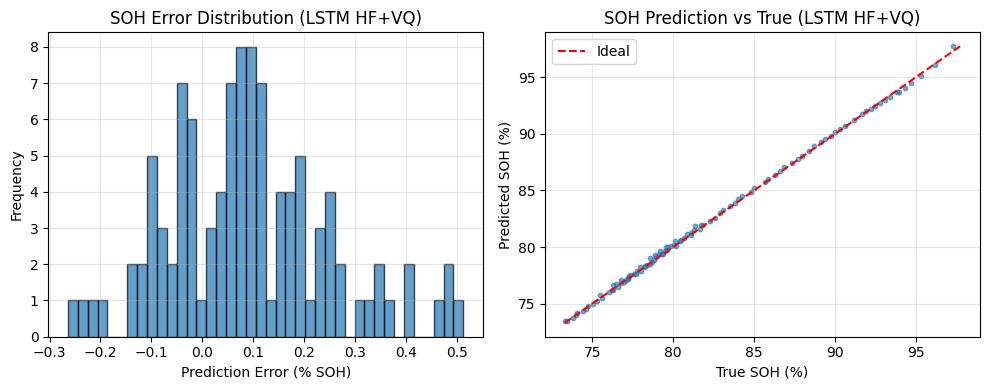


Done.


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ============================================================
# 0. Config
# ============================================================

MAT_FILE = "Oxford_Battery_Degradation_Dataset_1.mat"
INIT_CAPACITY = 740.0          # mAh
SEQ_LEN = 128                  # resampled sequence length
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
VAL_SPLIT = 0.2                # 80/20 split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

print("\nLoading .mat file...")
data = scipy.io.loadmat(MAT_FILE)
print("Keys:", data.keys())


# ============================================================
# 1. Helper: compute HF1, HF2, capacity for a single cycle
# ============================================================

def compute_hf_features_for_cycle(cyc, init_capacity=740.0):
    """
    Given one cycle struct (from MATLAB), compute:
      HF1: charge time 3.8V -> 4.1V (C1ch)
      HF2: discharge time 4.1V -> 3.8V (C1dc)
      capacity: average of charge & discharge capacities if both valid
    
    Returns:
        HF1 (float or np.nan),
        HF2 (float or np.nan),
        capacity (float, 0 if invalid)
    """
    HF1 = np.nan
    HF2 = np.nan
    capacity_ch = 0.0
    capacity_dc = 0.0

    # ----- Charging phase: C1ch -> HF1 -----
    if "C1ch" in cyc.dtype.names:
        blk_ch = cyc["C1ch"][0, 0]
        if all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
            t_ch = blk_ch["t"][0, 0].ravel().astype(float)
            v_ch = blk_ch["v"][0, 0].ravel().astype(float)
            q_ch = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t_ch) > 10:
                try:
                    idx_3_8 = np.where(v_ch >= 3.8)[0]
                    idx_4_1 = np.where(v_ch >= 4.1)[0]
                    if len(idx_3_8) > 0 and len(idx_4_1) > 0:
                        t_start = t_ch[idx_3_8[0]]
                        t_end = t_ch[idx_4_1[0]]
                        if t_end > t_start:
                            HF1 = t_end - t_start
                except Exception:
                    HF1 = np.nan

                capacity_ch = float(q_ch[-1] - q_ch[0])

    # ----- Discharging phase: C1dc -> HF2 -----
    if "C1dc" in cyc.dtype.names:
        blk_dc = cyc["C1dc"][0, 0]
        if all(k in blk_dc.dtype.names for k in ["t", "v", "q"]):
            t_dc = blk_dc["t"][0, 0].ravel().astype(float)
            v_dc = blk_dc["v"][0, 0].ravel().astype(float)
            q_dc = blk_dc["q"][0, 0].ravel().astype(float)

            if len(t_dc) > 10:
                try:
                    idx_4_1 = np.where(v_dc <= 4.1)[0]
                    idx_3_8 = np.where(v_dc <= 3.8)[0]
                    if len(idx_4_1) > 0 and len(idx_3_8) > 0:
                        t_start = t_dc[idx_4_1[0]]
                        t_end = t_dc[idx_3_8[0]]
                        if t_end > t_start:
                            HF2 = t_end - t_start
                except Exception:
                    HF2 = np.nan

                capacity_dc = float(abs(q_dc[-1] - q_dc[0]))

    # ----- Capacity & SOH -----
    if capacity_ch > 0 and capacity_dc > 0:
        capacity = 0.5 * (capacity_ch + capacity_dc)
    elif capacity_ch > 0:
        capacity = capacity_ch
    elif capacity_dc > 0:
        capacity = capacity_dc
    else:
        capacity = 0.0

    return HF1, HF2, capacity


# ============================================================
# 2. Extract sequences: [L, 4] = [V, Q, HF1, HF2], label = SOH
# ============================================================

def extract_lstm_sequences_with_hf(data, L=128, init_capacity=740.0):
    """
    For each valid cycle (with HF1, HF2, and C1ch trace), build:
      - X_seq: [L, 4] -> [V, Q, HF1, HF2]  (HF1/HF2 repeated over time)
      - y_soh: scalar SOH (capacity / init_capacity)
      - metadata: cell_id, cycle_idx

    We use C1ch for the V,Q timeseries (you could also use C1dc or both).
    """
    X_list = []
    y_list = []
    cell_ids = []
    cycles = []
    hf1_list = []
    hf2_list = []

    print("\nExtracting LSTM sequences with HF1 & HF2...")

    for cell_id in range(1, 9):
        cell_key = f"Cell{cell_id}"
        if cell_key not in data:
            print(f"  {cell_key} not found, skipping.")
            continue

        cell = data[cell_key]
        cyc_names = sorted(cell.dtype.names, key=lambda s: int(s[3:]))

        count = 0
        for cyc_name in cyc_names:
            cyc_idx = int(cyc_name[3:])
            cyc = cell[cyc_name][0, 0]

            # Compute HF1, HF2, capacity
            HF1, HF2, capacity = compute_hf_features_for_cycle(cyc, init_capacity=init_capacity)
            if capacity <= 0 or np.isnan(HF1) or np.isnan(HF2):
                continue

            soh = capacity / float(init_capacity)    # fraction

            # --- Get V, Q from C1ch for sequence ---
            if "C1ch" not in cyc.dtype.names:
                continue
            blk_ch = cyc["C1ch"][0, 0]
            if not all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
                continue

            t = blk_ch["t"][0, 0].ravel().astype(float)
            v = blk_ch["v"][0, 0].ravel().astype(float)
            q = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t) < 5:
                continue

            # Resample to fixed length L
            t_new = np.linspace(t[0], t[-1], L)
            v_new = np.interp(t_new, t, v)
            q_new = np.interp(t_new, t, q)

            # Build feature sequence: [V, Q, HF1, HF2]
            HF1_arr = np.full_like(v_new, HF1, dtype=float)
            HF2_arr = np.full_like(v_new, HF2, dtype=float)
            X_seq = np.stack([v_new, q_new, HF1_arr, HF2_arr], axis=-1)  # [L, 4]

            X_list.append(X_seq)
            y_list.append(soh)
            hf1_list.append(HF1)
            hf2_list.append(HF2)
            cell_ids.append(cell_id)
            cycles.append(cyc_idx)
            count += 1

        print(f"  Cell {cell_id}: {count} valid cycles")

    X_arr = np.array(X_list, dtype=np.float32)              # [N, L, 4]
    y_arr = np.array(y_list, dtype=np.float32)[:, None]     # [N, 1]
    cell_ids_arr = np.array(cell_ids, dtype=np.int32)       # [N]
    cycles_arr = np.array(cycles, dtype=np.int32)           # [N]
    hf1_arr = np.array(hf1_list, dtype=np.float32)          # [N]
    hf2_arr = np.array(hf2_list, dtype=np.float32)          # [N]

    return X_arr, y_arr, cell_ids_arr, cycles_arr, hf1_arr, hf2_arr


X, y_soh, cell_ids, cycles, hf1_all, hf2_all = extract_lstm_sequences_with_hf(
    data, L=SEQ_LEN, init_capacity=INIT_CAPACITY
)
print("\nShapes:")
print("  X:", X.shape)               # [N, L, 4]
print("  y_soh:", y_soh.shape)       # [N, 1]
print("  cell_ids:", cell_ids.shape)
print("  cycles:", cycles.shape)


# ============================================================
# 3. Train/Test split & normalization
# ============================================================

N = len(X)
n_train = int((1.0 - VAL_SPLIT) * N)

# Simple chronological split (you can also shuffle)
X_train = X[:n_train]
X_test  = X[n_train:]
y_train = y_soh[:n_train]
y_test  = y_soh[n_train:]
cell_ids_train = cell_ids[:n_train]
cell_ids_test  = cell_ids[n_train:]
cycles_train   = cycles[:n_train]
cycles_test    = cycles[n_train:]

print(f"\nTrain sequences: {len(X_train)}, Test sequences: {len(X_test)}")

# Normalize features (V, Q, HF1, HF2) using training stats
flat_train = X_train.reshape(-1, X_train.shape[-1])  # [N*L, 4]
mu_feat = flat_train.mean(axis=0)
sd_feat = flat_train.std(axis=0) + 1e-8

X_train = (X_train - mu_feat) / sd_feat
X_test  = (X_test  - mu_feat) / sd_feat

# SOH is in [0, ~1]; keep as-is
y_train_norm = y_train
y_test_norm  = y_test

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train_norm, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_norm, dtype=torch.float32),
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# ============================================================
# 4. LSTM Model: [B, L, 4] -> [B, 1] (SOH)
# ============================================================

class LSTM_HF_VQ_SOH(nn.Module):
    """
    LSTM model that takes [B, L, 4] = [V, Q, HF1, HF2] and outputs
    a scalar SOH per sequence.
    """
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        # x: [B, L, 4]
        out, _ = self.lstm(x)      # out: [B, L, H]
        last = out[:, -1, :]       # [B, H]
        soh = self.fc(last)        # [B, 1]
        return soh


model = LSTM_HF_VQ_SOH(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
print("\nModel (LSTM HF+VQ -> SOH):")
print(model)
print("Parameters:", sum(p.numel() for p in model.parameters()))


# ============================================================
# 5. Training
# ============================================================

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

best_loss = float("inf")
BEST_MODEL_PATH = "best_lstm_hf_vq_soh.pt"

print("\nTraining LSTM SOH model (HF1, HF2, V, Q)...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)    # [B, L, 4]
        yb = yb.to(device)    # [B, 1]

        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            test_loss += loss_fn(pred, yb).item() * xb.size(0)
    test_loss /= len(test_loader.dataset)

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)

    if epoch == 1 or epoch % 10 == 0 or epoch == EPOCHS:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6e} | Test Loss: {test_loss:.6e}")

print("\nBest Test Loss (MSE in fraction^2):", best_loss)


# ============================================================
# 6. Evaluation in % SOH
# ============================================================

model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()

all_preds = []
all_trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        all_preds.append(pred)
        all_trues.append(yb.numpy())

preds = np.concatenate(all_preds, axis=0).flatten()  # fraction
trues = np.concatenate(all_trues, axis=0).flatten()  # fraction

preds_pct = preds * 100.0
trues_pct = trues * 100.0

mae = np.mean(np.abs(preds_pct - trues_pct))
rmse = np.sqrt(np.mean((preds_pct - trues_pct) ** 2))
max_err = np.max(np.abs(preds_pct - trues_pct))

print("\n========================================")
print("SOH Evaluation (Test Set) – LSTM HF1+HF2+V+Q")
print("========================================")
print(f"MAE:       {mae:.3f} %")
print(f"RMSE:      {rmse:.3f} %")
print(f"Max Error: {max_err:.3f} %")


# ============================================================
# 7. Simple visualizations
# ============================================================

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(preds_pct - trues_pct, bins=40, edgecolor="k", alpha=0.7)
plt.xlabel("Prediction Error (% SOH)")
plt.ylabel("Frequency")
plt.title("SOH Error Distribution (LSTM HF+VQ)")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(trues_pct, preds_pct, s=10, alpha=0.6)
mins = min(trues_pct.min(), preds_pct.min())
maxs = max(trues_pct.max(), preds_pct.max())
plt.plot([mins, maxs], [mins, maxs], "r--", label="Ideal")
plt.xlabel("True SOH (%)")
plt.ylabel("Predicted SOH (%)")
plt.title("SOH Prediction vs True (LSTM HF+VQ)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDone.")


Device: cuda

Loading .mat file...
Keys: dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

Extracting GRU sequences with HF1 & HF2...
  Cell 1: 78 valid cycles
  Cell 2: 73 valid cycles
  Cell 3: 76 valid cycles
  Cell 4: 47 valid cycles
  Cell 5: 46 valid cycles
  Cell 6: 46 valid cycles
  Cell 7: 77 valid cycles
  Cell 8: 76 valid cycles

Shapes:
  X: (519, 128, 4)
  y_soh: (519, 1)
  cell_ids: (519,)
  cycles: (519,)

Train sequences: 415, Test sequences: 104

Model (GRU HF+VQ -> SOH):
GRU_HF_VQ_SOH(
  (gru): GRU(4, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 150657

Training GRU SOH model (HF1, HF2, V, Q)...
Epoch 001 | Train Loss: 2.351595e-01 | Test Loss: 5.387261e-03
Epoch 010 | Train Loss: 6.976668e-04 | Test Loss: 3.997481e-05
Epoch 020 | Train Loss: 3.923142e-04 | Test Loss: 1.399430e-05
Epoch 030 | Train Loss: 2.561109e

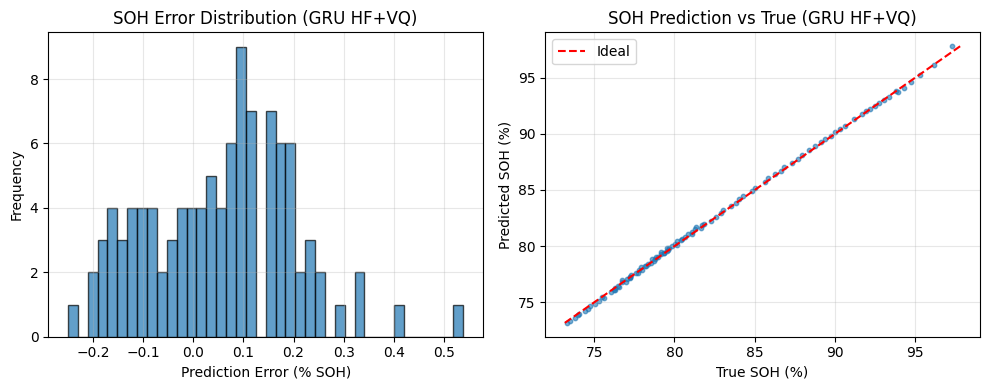


Done (GRU HF+VQ -> SOH).


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ============================================================
# 0. Config
# ============================================================

MAT_FILE = "Oxford_Battery_Degradation_Dataset_1.mat"
INIT_CAPACITY = 740.0          # mAh
SEQ_LEN = 128                  # resampled sequence length
BATCH_SIZE = 32
EPOCHS = 200
LR = 1e-3
VAL_SPLIT = 0.2                # 80/20 split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

print("\nLoading .mat file...")
data = scipy.io.loadmat(MAT_FILE)
print("Keys:", data.keys())


# ============================================================
# 1. Helper: compute HF1, HF2, capacity for a single cycle
# ============================================================

def compute_hf_features_for_cycle(cyc, init_capacity=740.0):
    """
    Given one cycle struct (from MATLAB), compute:
      HF1: charge time 3.8V -> 4.1V (C1ch)
      HF2: discharge time 4.1V -> 3.8V (C1dc)
      capacity: average of charge & discharge capacities if both valid
    
    Returns:
        HF1 (float or np.nan),
        HF2 (float or np.nan),
        capacity (float, 0 if invalid)
    """
    HF1 = np.nan
    HF2 = np.nan
    capacity_ch = 0.0
    capacity_dc = 0.0

    # ----- Charging phase: C1ch -> HF1 -----
    if "C1ch" in cyc.dtype.names:
        blk_ch = cyc["C1ch"][0, 0]
        if all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
            t_ch = blk_ch["t"][0, 0].ravel().astype(float)
            v_ch = blk_ch["v"][0, 0].ravel().astype(float)
            q_ch = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t_ch) > 10:
                try:
                    idx_3_8 = np.where(v_ch >= 3.8)[0]
                    idx_4_1 = np.where(v_ch >= 4.1)[0]
                    if len(idx_3_8) > 0 and len(idx_4_1) > 0:
                        t_start = t_ch[idx_3_8[0]]
                        t_end = t_ch[idx_4_1[0]]
                        if t_end > t_start:
                            HF1 = t_end - t_start
                except Exception:
                    HF1 = np.nan

                capacity_ch = float(q_ch[-1] - q_ch[0])

    # ----- Discharging phase: C1dc -> HF2 -----
    if "C1dc" in cyc.dtype.names:
        blk_dc = cyc["C1dc"][0, 0]
        if all(k in blk_dc.dtype.names for k in ["t", "v", "q"]):
            t_dc = blk_dc["t"][0, 0].ravel().astype(float)
            v_dc = blk_dc["v"][0, 0].ravel().astype(float)
            q_dc = blk_dc["q"][0, 0].ravel().astype(float)

            if len(t_dc) > 10:
                try:
                    idx_4_1 = np.where(v_dc <= 4.1)[0]
                    idx_3_8 = np.where(v_dc <= 3.8)[0]
                    if len(idx_4_1) > 0 and len(idx_3_8) > 0:
                        t_start = t_dc[idx_4_1[0]]
                        t_end = t_dc[idx_3_8[0]]
                        if t_end > t_start:
                            HF2 = t_end - t_start
                except Exception:
                    HF2 = np.nan

                capacity_dc = float(abs(q_dc[-1] - q_dc[0]))

    # ----- Capacity -----
    if capacity_ch > 0 and capacity_dc > 0:
        capacity = 0.5 * (capacity_ch + capacity_dc)
    elif capacity_ch > 0:
        capacity = capacity_ch
    elif capacity_dc > 0:
        capacity = capacity_dc
    else:
        capacity = 0.0

    return HF1, HF2, capacity


# ============================================================
# 2. Extract sequences: [L, 4] = [V, Q, HF1, HF2], label = SOH
# ============================================================

def extract_gru_sequences_with_hf(data, L=128, init_capacity=740.0):
    """
    For each valid cycle (with HF1, HF2, and C1ch trace), build:
      - X_seq: [L, 4] -> [V, Q, HF1, HF2]  (HF1/HF2 repeated over time)
      - y_soh: scalar SOH (capacity / init_capacity)
      - metadata: cell_id, cycle_idx
    """
    X_list = []
    y_list = []
    cell_ids = []
    cycles = []
    hf1_list = []
    hf2_list = []

    print("\nExtracting GRU sequences with HF1 & HF2...")

    for cell_id in range(1, 9):
        cell_key = f"Cell{cell_id}"
        if cell_key not in data:
            print(f"  {cell_key} not found, skipping.")
            continue

        cell = data[cell_key]
        cyc_names = sorted(cell.dtype.names, key=lambda s: int(s[3:]))

        count = 0
        for cyc_name in cyc_names:
            cyc_idx = int(cyc_name[3:])
            cyc = cell[cyc_name][0, 0]

            # Compute HF1, HF2, capacity
            HF1, HF2, capacity = compute_hf_features_for_cycle(cyc, init_capacity=init_capacity)
            if capacity <= 0 or np.isnan(HF1) or np.isnan(HF2):
                continue

            soh = capacity / float(init_capacity)    # fraction

            # --- Get V, Q from C1ch for sequence ---
            if "C1ch" not in cyc.dtype.names:
                continue
            blk_ch = cyc["C1ch"][0, 0]
            if not all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
                continue

            t = blk_ch["t"][0, 0].ravel().astype(float)
            v = blk_ch["v"][0, 0].ravel().astype(float)
            q = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t) < 5:
                continue

            # Resample to fixed length L
            t_new = np.linspace(t[0], t[-1], L)
            v_new = np.interp(t_new, t, v)
            q_new = np.interp(t_new, t, q)

            # Build feature sequence: [V, Q, HF1, HF2]
            HF1_arr = np.full_like(v_new, HF1, dtype=float)
            HF2_arr = np.full_like(v_new, HF2, dtype=float)
            X_seq = np.stack([v_new, q_new, HF1_arr, HF2_arr], axis=-1)  # [L, 4]

            X_list.append(X_seq)
            y_list.append(soh)
            hf1_list.append(HF1)
            hf2_list.append(HF2)
            cell_ids.append(cell_id)
            cycles.append(cyc_idx)
            count += 1

        print(f"  Cell {cell_id}: {count} valid cycles")

    X_arr = np.array(X_list, dtype=np.float32)              # [N, L, 4]
    y_arr = np.array(y_list, dtype=np.float32)[:, None]     # [N, 1]
    cell_ids_arr = np.array(cell_ids, dtype=np.int32)       # [N]
    cycles_arr = np.array(cycles, dtype=np.int32)           # [N]
    hf1_arr = np.array(hf1_list, dtype=np.float32)          # [N]
    hf2_arr = np.array(hf2_list, dtype=np.float32)          # [N]

    return X_arr, y_arr, cell_ids_arr, cycles_arr, hf1_arr, hf2_arr


X, y_soh, cell_ids, cycles, hf1_all, hf2_all = extract_gru_sequences_with_hf(
    data, L=SEQ_LEN, init_capacity=INIT_CAPACITY
)
print("\nShapes:")
print("  X:", X.shape)               # [N, L, 4]
print("  y_soh:", y_soh.shape)       # [N, 1]
print("  cell_ids:", cell_ids.shape)
print("  cycles:", cycles.shape)


# ============================================================
# 3. Train/Test split & normalization
# ============================================================

N = len(X)
n_train = int((1.0 - VAL_SPLIT) * N)

# Simple chronological split (you can also shuffle first if you want)
X_train = X[:n_train]
X_test  = X[n_train:]
y_train = y_soh[:n_train]
y_test  = y_soh[n_train:]
cell_ids_train = cell_ids[:n_train]
cell_ids_test  = cell_ids[n_train:]
cycles_train   = cycles[:n_train]
cycles_test    = cycles[n_train:]

print(f"\nTrain sequences: {len(X_train)}, Test sequences: {len(X_test)}")

# Normalize features (V, Q, HF1, HF2) using training stats
flat_train = X_train.reshape(-1, X_train.shape[-1])  # [N*L, 4]
mu_feat = flat_train.mean(axis=0)
sd_feat = flat_train.std(axis=0) + 1e-8

X_train = (X_train - mu_feat) / sd_feat
X_test  = (X_test  - mu_feat) / sd_feat

# SOH is in [0, ~1]; keep as-is
y_train_norm = y_train
y_test_norm  = y_test

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train_norm, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_norm, dtype=torch.float32),
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# ============================================================
# 4. GRU Model: [B, L, 4] -> [B, 1] (SOH)
# ============================================================

class GRU_HF_VQ_SOH(nn.Module):
    """
    GRU model that takes [B, L, 4] = [V, Q, HF1, HF2] and outputs
    a scalar SOH per sequence.
    
    Same spec as the LSTM model, but using GRU.
    """
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        # x: [B, L, 4]
        out, _ = self.gru(x)      # out: [B, L, H]
        last = out[:, -1, :]      # [B, H]
        soh = self.fc(last)       # [B, 1]
        return soh


model = GRU_HF_VQ_SOH(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
print("\nModel (GRU HF+VQ -> SOH):")
print(model)
print("Parameters:", sum(p.numel() for p in model.parameters()))


# ============================================================
# 5. Training
# ============================================================

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

best_loss = float("inf")
BEST_MODEL_PATH = "best_gru_hf_vq_soh.pt"

print("\nTraining GRU SOH model (HF1, HF2, V, Q)...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)    # [B, L, 4]
        yb = yb.to(device)    # [B, 1]

        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            test_loss += loss_fn(pred, yb).item() * xb.size(0)
    test_loss /= len(test_loader.dataset)

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)

    if epoch == 1 or epoch % 10 == 0 or epoch == EPOCHS:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6e} | Test Loss: {test_loss:.6e}")

print("\nBest Test Loss (MSE in fraction^2):", best_loss)


# ============================================================
# 6. Evaluation in % SOH
# ============================================================

model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()

all_preds = []
all_trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        all_preds.append(pred)
        all_trues.append(yb.numpy())

preds = np.concatenate(all_preds, axis=0).flatten()  # fraction
trues = np.concatenate(all_trues, axis=0).flatten()  # fraction

preds_pct = preds * 100.0
trues_pct = trues * 100.0

mae = np.mean(np.abs(preds_pct - trues_pct))
rmse = np.sqrt(np.mean((preds_pct - trues_pct) ** 2))
max_err = np.max(np.abs(preds_pct - trues_pct))

print("\n========================================")
print("SOH Evaluation (Test Set) – GRU HF1+HF2+V+Q")
print("========================================")
print(f"MAE:       {mae:.3f} %")
print(f"RMSE:      {rmse:.3f} %")
print(f"Max Error: {max_err:.3f} %")


# ============================================================
# 7. Simple visualizations
# ============================================================

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(preds_pct - trues_pct, bins=40, edgecolor="k", alpha=0.7)
plt.xlabel("Prediction Error (% SOH)")
plt.ylabel("Frequency")
plt.title("SOH Error Distribution (GRU HF+VQ)")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(trues_pct, preds_pct, s=10, alpha=0.6)
mins = min(trues_pct.min(), preds_pct.min())
maxs = max(trues_pct.max(), preds_pct.max())
plt.plot([mins, maxs], [mins, maxs], "r--", label="Ideal")
plt.xlabel("True SOH (%)")
plt.ylabel("Predicted SOH (%)")
plt.title("SOH Prediction vs True (GRU HF+VQ)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDone (GRU HF+VQ -> SOH).")


Device: cuda

Loading .mat file...
Keys: dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

Extracting GRU-PINN sequences with HF1 & HF2 & DVA...
  Cell 1: 78 valid cycles
  Cell 2: 73 valid cycles
  Cell 3: 76 valid cycles
  Cell 4: 47 valid cycles
  Cell 5: 46 valid cycles
  Cell 6: 46 valid cycles
  Cell 7: 77 valid cycles
  Cell 8: 76 valid cycles

Shapes:
  X: (519, 128, 4)
  y_soh: (519, 1)
  dva: (519, 128, 1)
  cell_ids: (519,)
  cycles: (519,)

Train sequences: 415, Test sequences: 104

Model (GRU-PINN HF+VQ -> SOH + DVA):
GRU_PINN_SOH_DVA(
  (gru): GRU(4, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc_soh): Linear(in_features=128, out_features=1, bias=True)
  (fc_dva): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 150786

Training GRU-PINN SOH model (HF1, HF2, V, Q + DVA physics)...
Epoch 001 | Train Total: 2.423527e-01 (Data: 1.445367e-01, Phys: 9.781606e-01) | Test Tota

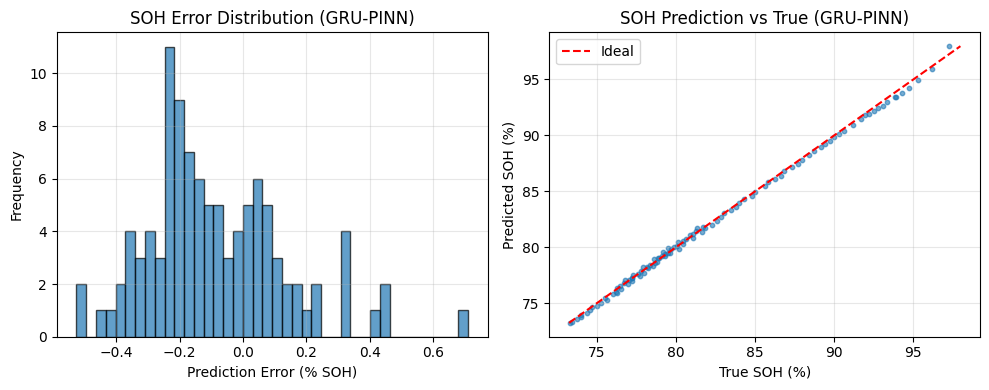

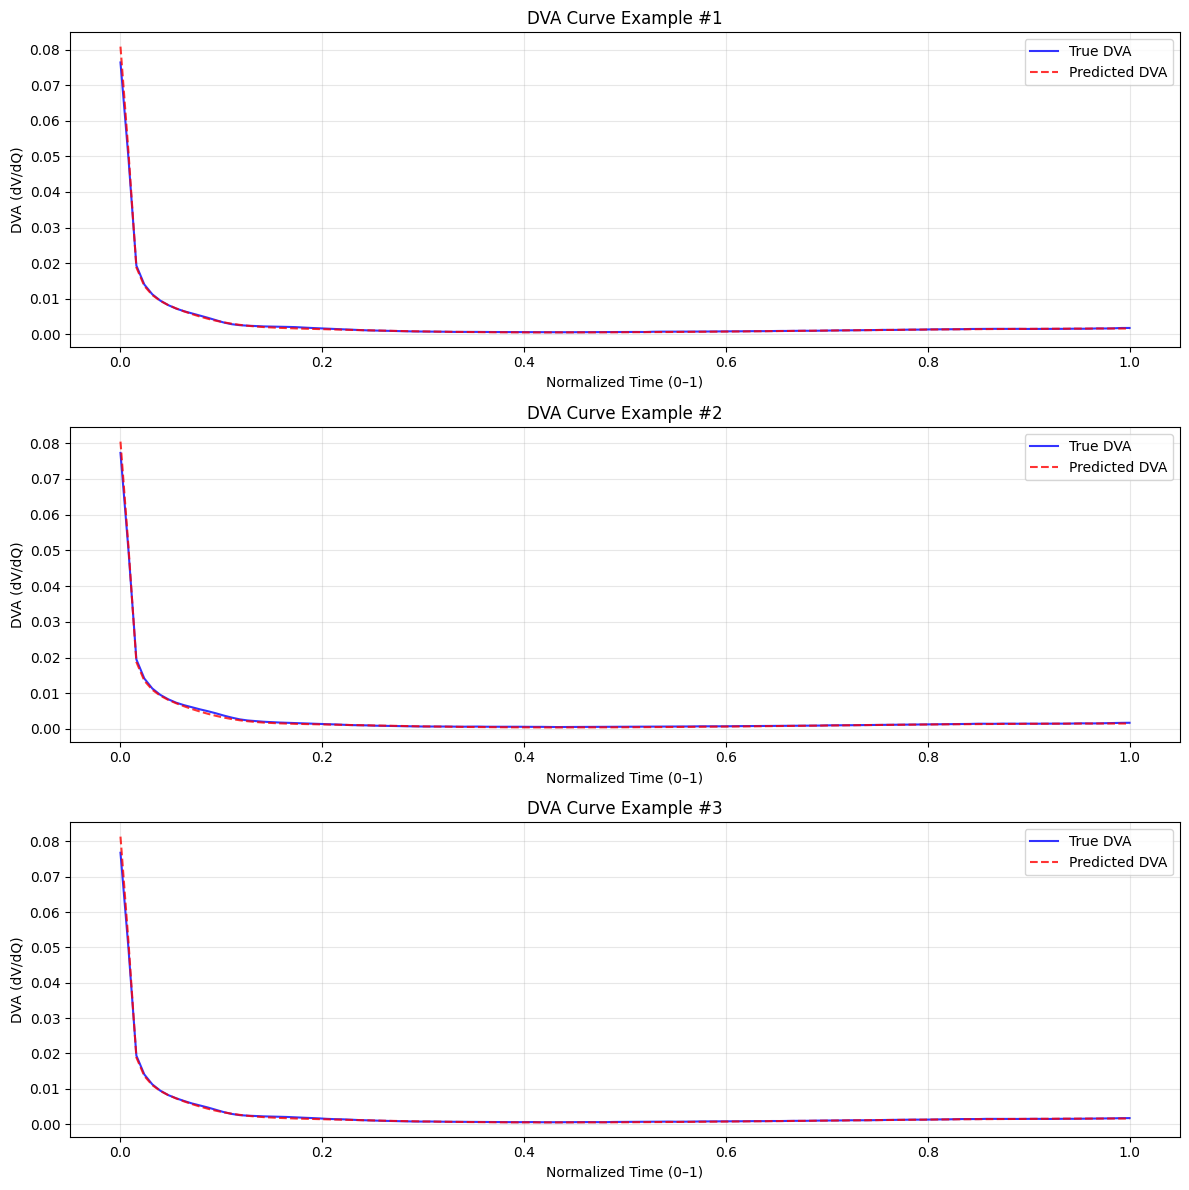


Done (GRU-PINN with DVA physics).


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ============================================================
# 0. Config
# ============================================================

MAT_FILE = "Oxford_Battery_Degradation_Dataset_1.mat"
INIT_CAPACITY = 740.0          # mAh
SEQ_LEN = 128                  # resampled sequence length
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
VAL_SPLIT = 0.2                # 80/20 split
LAMBDA_PHYS = 0.1              # weight for physics (DVA) loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

print("\nLoading .mat file...")
data = scipy.io.loadmat(MAT_FILE)
print("Keys:", data.keys())


# ============================================================
# 1. Helpers: HF1/HF2, DVA (dV/dQ)
# ============================================================

def compute_hf_features_for_cycle(cyc, init_capacity=740.0):
    """
    Given one cycle struct (from MATLAB), compute:
      HF1: charge time 3.8V -> 4.1V (C1ch)
      HF2: discharge time 4.1V -> 3.8V (C1dc)
      capacity: average of charge & discharge capacities if both valid
    
    Returns:
        HF1 (float or np.nan),
        HF2 (float or np.nan),
        capacity (float, 0 if invalid)
    """
    HF1 = np.nan
    HF2 = np.nan
    capacity_ch = 0.0
    capacity_dc = 0.0

    # ----- Charging phase: C1ch -> HF1 -----
    if "C1ch" in cyc.dtype.names:
        blk_ch = cyc["C1ch"][0, 0]
        if all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
            t_ch = blk_ch["t"][0, 0].ravel().astype(float)
            v_ch = blk_ch["v"][0, 0].ravel().astype(float)
            q_ch = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t_ch) > 10:
                try:
                    idx_3_8 = np.where(v_ch >= 3.8)[0]
                    idx_4_1 = np.where(v_ch >= 4.1)[0]
                    if len(idx_3_8) > 0 and len(idx_4_1) > 0:
                        t_start = t_ch[idx_3_8[0]]
                        t_end   = t_ch[idx_4_1[0]]
                        if t_end > t_start:
                            HF1 = t_end - t_start
                except Exception:
                    HF1 = np.nan

                capacity_ch = float(q_ch[-1] - q_ch[0])

    # ----- Discharging phase: C1dc -> HF2 -----
    if "C1dc" in cyc.dtype.names:
        blk_dc = cyc["C1dc"][0, 0]
        if all(k in blk_dc.dtype.names for k in ["t", "v", "q"]):
            t_dc = blk_dc["t"][0, 0].ravel().astype(float)
            v_dc = blk_dc["v"][0, 0].ravel().astype(float)
            q_dc = blk_dc["q"][0, 0].ravel().astype(float)

            if len(t_dc) > 10:
                try:
                    idx_4_1 = np.where(v_dc <= 4.1)[0]
                    idx_3_8 = np.where(v_dc <= 3.8)[0]
                    if len(idx_4_1) > 0 and len(idx_3_8) > 0:
                        t_start = t_dc[idx_4_1[0]]
                        t_end   = t_dc[idx_3_8[0]]
                        if t_end > t_start:
                            HF2 = t_end - t_start
                except Exception:
                    HF2 = np.nan

                capacity_dc = float(abs(q_dc[-1] - q_dc[0]))

    # ----- Capacity -----
    if capacity_ch > 0 and capacity_dc > 0:
        capacity = 0.5 * (capacity_ch + capacity_dc)
    elif capacity_ch > 0:
        capacity = capacity_ch
    elif capacity_dc > 0:
        capacity = capacity_dc
    else:
        capacity = 0.0

    return HF1, HF2, capacity


def compute_dva(v, q, dq_eps=1e-6, dq_thresh=1e-5, clip_val=100.0):
    """
    Compute DVA = dV/dQ for 1D arrays v, q (same length).
    - Uses finite differences.
    - Avoids division by very small dQ.
    - Optionally clips extremes.
    """
    v = np.asarray(v, dtype=float)
    q = np.asarray(q, dtype=float)

    dq = np.gradient(q)
    dv = np.gradient(v)

    dva = np.zeros_like(v, dtype=float)

    small = np.abs(dq) < dq_thresh
    safe_dq = dq.copy()
    safe_dq[small] = np.sign(dq[small]) * dq_eps + (dq[small] == 0) * dq_eps

    dva = dv / safe_dq
    dva[small] = 0.0

    if clip_val is not None:
        dva = np.clip(dva, -clip_val, clip_val)

    return dva


# ============================================================
# 2. Extract sequences: [L, 4] = [V, Q, HF1, HF2], labels = SOH & DVA
# ============================================================

def extract_gru_pinn_sequences(data, L=128, init_capacity=740.0):
    """
    For each valid cycle (with HF1, HF2, and C1ch trace), build:
      - X_seq: [L, 4] -> [V, Q, HF1, HF2]  (HF1/HF2 repeated over time)
      - y_soh: scalar SOH (capacity / init_capacity)
      - dva:   [L, 1] DVA curve dV/dQ on resampled sequence
      - metadata: cell_id, cycle_idx
    """
    X_list = []
    y_list = []
    dva_list = []
    cell_ids = []
    cycles = []
    hf1_list = []
    hf2_list = []

    print("\nExtracting GRU-PINN sequences with HF1 & HF2 & DVA...")

    for cell_id in range(1, 9):
        cell_key = f"Cell{cell_id}"
        if cell_key not in data:
            print(f"  {cell_key} not found, skipping.")
            continue

        cell = data[cell_key]
        cyc_names = sorted(cell.dtype.names, key=lambda s: int(s[3:]))

        count = 0
        for cyc_name in cyc_names:
            cyc_idx = int(cyc_name[3:])
            cyc = cell[cyc_name][0, 0]

            # Compute HF1, HF2, capacity
            HF1, HF2, capacity = compute_hf_features_for_cycle(cyc, init_capacity=init_capacity)
            if capacity <= 0 or np.isnan(HF1) or np.isnan(HF2):
                continue

            soh = capacity / float(init_capacity)    # fraction

            # --- Get V, Q from C1ch for sequence ---
            if "C1ch" not in cyc.dtype.names:
                continue
            blk_ch = cyc["C1ch"][0, 0]
            if not all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
                continue

            t = blk_ch["t"][0, 0].ravel().astype(float)
            v = blk_ch["v"][0, 0].ravel().astype(float)
            q = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t) < 5:
                continue

            # Resample to fixed length L
            t_new = np.linspace(t[0], t[-1], L)
            v_new = np.interp(t_new, t, v)
            q_new = np.interp(t_new, t, q)

            # DVA physics target on resampled data
            dva = compute_dva(v_new, q_new)   # [L]

            # Build feature sequence: [V, Q, HF1, HF2]
            HF1_arr = np.full_like(v_new, HF1, dtype=float)
            HF2_arr = np.full_like(v_new, HF2, dtype=float)
            X_seq = np.stack([v_new, q_new, HF1_arr, HF2_arr], axis=-1)  # [L, 4]

            X_list.append(X_seq)
            y_list.append(soh)
            dva_list.append(dva[:, None])     # [L, 1]
            hf1_list.append(HF1)
            hf2_list.append(HF2)
            cell_ids.append(cell_id)
            cycles.append(cyc_idx)
            count += 1

        print(f"  Cell {cell_id}: {count} valid cycles")

    X_arr = np.array(X_list, dtype=np.float32)              # [N, L, 4]
    y_arr = np.array(y_list, dtype=np.float32)[:, None]     # [N, 1]
    dva_arr = np.array(dva_list, dtype=np.float32)          # [N, L, 1]
    cell_ids_arr = np.array(cell_ids, dtype=np.int32)       # [N]
    cycles_arr = np.array(cycles, dtype=np.int32)           # [N]
    hf1_arr = np.array(hf1_list, dtype=np.float32)          # [N]
    hf2_arr = np.array(hf2_list, dtype=np.float32)          # [N]

    return X_arr, y_arr, dva_arr, cell_ids_arr, cycles_arr, hf1_arr, hf2_arr


X, y_soh, dva, cell_ids, cycles, hf1_all, hf2_all = extract_gru_pinn_sequences(
    data, L=SEQ_LEN, init_capacity=INIT_CAPACITY
)
print("\nShapes:")
print("  X:", X.shape)               # [N, L, 4]
print("  y_soh:", y_soh.shape)       # [N, 1]
print("  dva:", dva.shape)           # [N, L, 1]
print("  cell_ids:", cell_ids.shape)
print("  cycles:", cycles.shape)


# ============================================================
# 3. Train/Test split & normalization
# ============================================================

N = len(X)
n_train = int((1.0 - VAL_SPLIT) * N)

X_train = X[:n_train]
X_test  = X[n_train:]
y_train = y_soh[:n_train]
y_test  = y_soh[n_train:]
dva_train = dva[:n_train]
dva_test  = dva[n_train:]
cell_ids_train = cell_ids[:n_train]
cell_ids_test  = cell_ids[n_train:]
cycles_train   = cycles[:n_train]
cycles_test    = cycles[n_train:]

print(f"\nTrain sequences: {len(X_train)}, Test sequences: {len(X_test)}")

# Normalize features (V, Q, HF1, HF2) using training stats
flat_train = X_train.reshape(-1, X_train.shape[-1])  # [N*L, 4]
mu_feat = flat_train.mean(axis=0)
sd_feat = flat_train.std(axis=0) + 1e-8

X_train = (X_train - mu_feat) / sd_feat
X_test  = (X_test  - mu_feat) / sd_feat

# Normalize DVA physics target
flat_dva_train = dva_train.reshape(-1, dva_train.shape[-1])  # [N*L, 1]
mu_dva = flat_dva_train.mean(axis=0)        # [1]
sd_dva = flat_dva_train.std(axis=0) + 1e-8  # [1]

dva_train_norm = (dva_train - mu_dva) / sd_dva
dva_test_norm  = (dva_test  - mu_dva) / sd_dva

# SOH already in [0,~1]; keep as is
y_train_norm = y_train
y_test_norm  = y_test

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train_norm, dtype=torch.float32),
    torch.tensor(dva_train_norm, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_norm, dtype=torch.float32),
    torch.tensor(dva_test_norm, dtype=torch.float32),
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# ============================================================
# 4. GRU-PINN Model: SOH head + DVA head
# ============================================================

class GRU_PINN_SOH_DVA(nn.Module):
    """
    GRU-PINN:
      Input : [B, L, 4] (V, Q, HF1, HF2)
      Output:
        - soh_pred: [B, 1]     (SOH fraction)
        - dva_pred: [B, L, 1]  (normalized DVA curve)
    """
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        # SOH head (last hidden state)
        self.fc_soh = nn.Linear(hidden, 1)
        # DVA head (per time step)
        self.fc_dva = nn.Linear(hidden, 1)

    def forward(self, x):
        # x: [B, L, 4]
        out, _ = self.gru(x)          # out: [B, L, H]
        last = out[:, -1, :]          # [B, H]
        soh = self.fc_soh(last)       # [B, 1]
        dva_pred = self.fc_dva(out)   # [B, L, 1] (normalized DVA)
        return soh, dva_pred


model = GRU_PINN_SOH_DVA(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
print("\nModel (GRU-PINN HF+VQ -> SOH + DVA):")
print(model)
print("Parameters:", sum(p.numel() for p in model.parameters()))


# ============================================================
# 5. Training: data loss (SOH) + physics loss (DVA)
# ============================================================

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
mse_loss = nn.MSELoss()

best_loss = float("inf")
BEST_MODEL_PATH = "best_gru_pinn_hf_vq_soh_dva.pt"

print("\nTraining GRU-PINN SOH model (HF1, HF2, V, Q + DVA physics)...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_total = 0.0
    train_data = 0.0
    train_phys = 0.0

    for xb, yb, dva_b in train_loader:
        xb = xb.to(device)       # [B, L, 4]
        yb = yb.to(device)       # [B, 1]
        dva_b = dva_b.to(device) # [B, L, 1] (normalized DVA)

        optimizer.zero_grad()
        soh_pred, dva_pred = model(xb)

        loss_data = mse_loss(soh_pred, yb)
        loss_phys = mse_loss(dva_pred, dva_b)

        loss = loss_data + LAMBDA_PHYS * loss_phys
        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        train_total += loss.item() * bs
        train_data  += loss_data.item() * bs
        train_phys  += loss_phys.item() * bs

    train_total /= len(train_loader.dataset)
    train_data  /= len(train_loader.dataset)
    train_phys  /= len(train_loader.dataset)

    # Validation
    model.eval()
    test_total = 0.0
    test_data  = 0.0
    test_phys  = 0.0

    with torch.no_grad():
        for xb, yb, dva_b in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            dva_b = dva_b.to(device)

            soh_pred, dva_pred = model(xb)

            loss_data = mse_loss(soh_pred, yb)
            loss_phys = mse_loss(dva_pred, dva_b)
            loss = loss_data + LAMBDA_PHYS * loss_phys

            bs = xb.size(0)
            test_total += loss.item() * bs
            test_data  += loss_data.item() * bs
            test_phys  += loss_phys.item() * bs

    test_total /= len(test_loader.dataset)
    test_data  /= len(test_loader.dataset)
    test_phys  /= len(test_loader.dataset)

    if test_total < best_loss:
        best_loss = test_total
        torch.save(model.state_dict(), BEST_MODEL_PATH)

    if epoch == 1 or epoch % 10 == 0 or epoch == EPOCHS:
        print(
            f"Epoch {epoch:03d} | "
            f"Train Total: {train_total:.6e} (Data: {train_data:.6e}, Phys: {train_phys:.6e}) | "
            f"Test Total: {test_total:.6e} (Data: {test_data:.6e}, Phys: {test_phys:.6e})"
        )

print("\nBest Test Total Loss:", best_loss)


# ============================================================
# 6. Evaluation: SOH metrics + DVA physics error
# ============================================================

model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()

all_soh_pred = []
all_soh_true = []
all_dva_pred = []
all_dva_true = []

with torch.no_grad():
    for xb, yb, dva_b in test_loader:
        xb = xb.to(device)
        soh_pred, dva_pred = model(xb)

        all_soh_pred.append(soh_pred.cpu().numpy())
        all_soh_true.append(yb.numpy())
        all_dva_pred.append(dva_pred.cpu().numpy())
        all_dva_true.append(dva_b.numpy())

soh_pred = np.concatenate(all_soh_pred, axis=0).flatten()  # fraction
soh_true = np.concatenate(all_soh_true, axis=0).flatten()  # fraction

dva_pred_norm = np.concatenate(all_dva_pred, axis=0)  # [N_test, L, 1]
dva_true_norm = np.concatenate(all_dva_true, axis=0)  # [N_test, L, 1]

# De-normalize DVA to original scale
dva_pred = dva_pred_norm * sd_dva + mu_dva
dva_true = dva_true_norm * sd_dva + mu_dva

# SOH metrics in %
soh_pred_pct = soh_pred * 100.0
soh_true_pct = soh_true * 100.0

mae_soh = np.mean(np.abs(soh_pred_pct - soh_true_pct))
rmse_soh = np.sqrt(np.mean((soh_pred_pct - soh_true_pct) ** 2))
max_err_soh = np.max(np.abs(soh_pred_pct - soh_true_pct))

print("\n========================================")
print("SOH Evaluation (Test Set) – GRU-PINN HF+VQ+DVA")
print("========================================")
print(f"MAE (SOH):       {mae_soh:.3f} %")
print(f"RMSE (SOH):      {rmse_soh:.3f} %")
print(f"Max Error (SOH): {max_err_soh:.3f} %")

# DVA physics error (MSE)
dva_mse = np.mean((dva_pred - dva_true) ** 2)
print(f"\nDVA Physics MSE (original scale): {dva_mse:.6e}")


# ============================================================
# 7. Visualizations: SOH + example DVA curves
# ============================================================

# --- SOH scatter/error ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(soh_pred_pct - soh_true_pct, bins=40, edgecolor="k", alpha=0.7)
plt.xlabel("Prediction Error (% SOH)")
plt.ylabel("Frequency")
plt.title("SOH Error Distribution (GRU-PINN)")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(soh_true_pct, soh_pred_pct, s=10, alpha=0.6)
mins = min(soh_true_pct.min(), soh_pred_pct.min())
maxs = max(soh_true_pct.max(), soh_pred_pct.max())
plt.plot([mins, maxs], [mins, maxs], "r--", label="Ideal")
plt.xlabel("True SOH (%)")
plt.ylabel("Predicted SOH (%)")
plt.title("SOH Prediction vs True (GRU-PINN)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- DVA curves: show a few examples ---
num_examples = 3
plt.figure(figsize=(12, 4 * num_examples))
time_axis = np.linspace(0, 1, SEQ_LEN)

for i in range(num_examples):
    if i >= len(dva_true):
        break
    plt.subplot(num_examples, 1, i + 1)
    plt.plot(time_axis, dva_true[i].squeeze(), "b-", label="True DVA", alpha=0.8)
    plt.plot(time_axis, dva_pred[i].squeeze(), "r--", label="Predicted DVA", alpha=0.8)
    plt.xlabel("Normalized Time (0–1)")
    plt.ylabel("DVA (dV/dQ)")
    plt.title(f"DVA Curve Example #{i+1}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDone (GRU-PINN with DVA physics).")


Device: cuda

Loading .mat file...
Keys: dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

Extracting sequences with HF1, HF2, V, Q, DVA (for all models)...
  Cell 1: 78 valid cycles
  Cell 2: 73 valid cycles
  Cell 3: 76 valid cycles
  Cell 4: 47 valid cycles
  Cell 5: 46 valid cycles
  Cell 6: 46 valid cycles
  Cell 7: 77 valid cycles
  Cell 8: 76 valid cycles

Shapes:
  X: (519, 128, 4)
  y_soh: (519, 1)
  dva: (519, 128, 1)

Train sequences: 415, Test sequences: 104

Loaded LSTM, GRU, and GRU-PINN checkpoints.

=== Cell 8: SOH vs Cycle (Test set) ===
LSTM : MAE = 0.122 %, RMSE = 0.154 %
GRU  : MAE = 0.113 %, RMSE = 0.139 %
PINN : MAE = 0.207 %, RMSE = 0.244 %


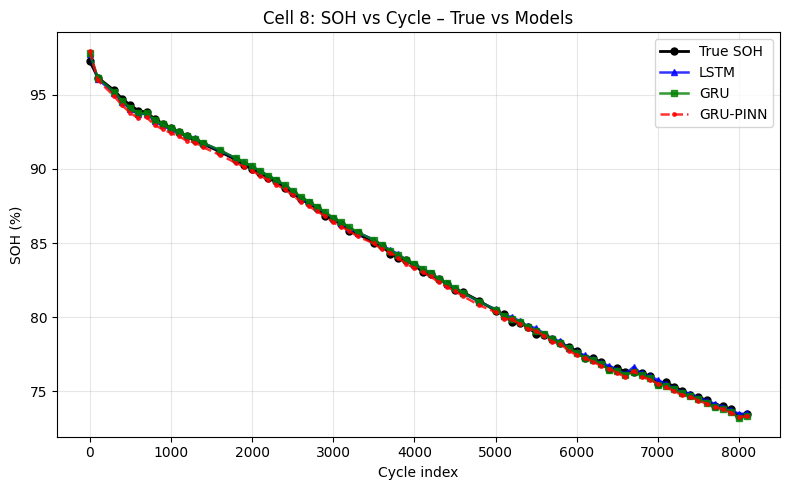


Done test for Cell 8


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn as nn

# ============================================================
# 0. Config
# ============================================================

MAT_FILE = "Oxford_Battery_Degradation_Dataset_1.mat"
INIT_CAPACITY = 740.0          # mAh
SEQ_LEN = 128                  # resampled sequence length
VAL_SPLIT = 0.2                # must match training
LAMBDA_PHYS = 0.1              # used in PINN training (not needed here, just for reference)

# Model checkpoint paths (must match what you used in training scripts)
LSTM_CKPT = "best_lstm_hf_vq_soh.pt"
GRU_CKPT = "best_gru_hf_vq_soh.pt"
GRU_PINN_CKPT = "best_gru_pinn_hf_vq_soh_dva.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

print("\nLoading .mat file...")
data = scipy.io.loadmat(MAT_FILE)
print("Keys:", data.keys())


# ============================================================
# 1. Helpers: HF1/HF2 & DVA & feature extraction
# ============================================================

def compute_hf_features_for_cycle(cyc, init_capacity=740.0):
    """
    Given one cycle struct (from MATLAB), compute:
      HF1: charge time 3.8V -> 4.1V (C1ch)
      HF2: discharge time 4.1V -> 3.8V (C1dc)
      capacity: average of charge & discharge capacities if both valid
    
    Returns:
        HF1 (float or np.nan),
        HF2 (float or np.nan),
        capacity (float, 0 if invalid)
    """
    HF1 = np.nan
    HF2 = np.nan
    capacity_ch = 0.0
    capacity_dc = 0.0

    # ----- Charging phase: C1ch -> HF1 -----
    if "C1ch" in cyc.dtype.names:
        blk_ch = cyc["C1ch"][0, 0]
        if all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
            t_ch = blk_ch["t"][0, 0].ravel().astype(float)
            v_ch = blk_ch["v"][0, 0].ravel().astype(float)
            q_ch = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t_ch) > 10:
                try:
                    idx_3_8 = np.where(v_ch >= 3.8)[0]
                    idx_4_1 = np.where(v_ch >= 4.1)[0]
                    if len(idx_3_8) > 0 and len(idx_4_1) > 0:
                        t_start = t_ch[idx_3_8[0]]
                        t_end   = t_ch[idx_4_1[0]]
                        if t_end > t_start:
                            HF1 = t_end - t_start
                except Exception:
                    HF1 = np.nan

                capacity_ch = float(q_ch[-1] - q_ch[0])

    # ----- Discharging phase: C1dc -> HF2 -----
    if "C1dc" in cyc.dtype.names:
        blk_dc = cyc["C1dc"][0, 0]
        if all(k in blk_dc.dtype.names for k in ["t", "v", "q"]):
            t_dc = blk_dc["t"][0, 0].ravel().astype(float)
            v_dc = blk_dc["v"][0, 0].ravel().astype(float)
            q_dc = blk_dc["q"][0, 0].ravel().astype(float)

            if len(t_dc) > 10:
                try:
                    idx_4_1 = np.where(v_dc <= 4.1)[0]
                    idx_3_8 = np.where(v_dc <= 3.8)[0]
                    if len(idx_4_1) > 0 and len(idx_3_8) > 0:
                        t_start = t_dc[idx_4_1[0]]
                        t_end   = t_dc[idx_3_8[0]]
                        if t_end > t_start:
                            HF2 = t_end - t_start
                except Exception:
                    HF2 = np.nan

                capacity_dc = float(abs(q_dc[-1] - q_dc[0]))

    # ----- Capacity -----
    if capacity_ch > 0 and capacity_dc > 0:
        capacity = 0.5 * (capacity_ch + capacity_dc)
    elif capacity_ch > 0:
        capacity = capacity_ch
    elif capacity_dc > 0:
        capacity = capacity_dc
    else:
        capacity = 0.0

    return HF1, HF2, capacity


def compute_dva(v, q, dq_eps=1e-6, dq_thresh=1e-5, clip_val=100.0):
    """
    Compute DVA = dV/dQ for 1D arrays v, q (same length).
    Used for the GRU-PINN physics target.
    """
    v = np.asarray(v, dtype=float)
    q = np.asarray(q, dtype=float)

    dq = np.gradient(q)
    dv = np.gradient(v)

    dva = np.zeros_like(v, dtype=float)

    small = np.abs(dq) < dq_thresh
    safe_dq = dq.copy()
    safe_dq[small] = np.sign(dq[small]) * dq_eps + (dq[small] == 0) * dq_eps

    dva = dv / safe_dq
    dva[small] = 0.0

    if clip_val is not None:
        dva = np.clip(dva, -clip_val, clip_val)

    return dva


def extract_sequences_with_hf_and_dva(data, L=128, init_capacity=740.0):
    """
    Common extraction function used for testing:
      - X_seq: [L, 4] = [V, Q, HF1, HF2]
      - y_soh: [1] SOH fraction
      - dva:   [L, 1] DVA curve (for GRU-PINN)
      - cell_ids, cycles
    This matches the feature format used for:
      - LSTM_HF_VQ_SOH
      - GRU_HF_VQ_SOH
      - GRU_PINN_SOH_DVA
    """
    X_list = []
    y_list = []
    dva_list = []
    cell_ids = []
    cycles = []
    hf1_list = []
    hf2_list = []

    print("\nExtracting sequences with HF1, HF2, V, Q, DVA (for all models)...")

    for cell_id in range(1, 9):
        cell_key = f"Cell{cell_id}"
        if cell_key not in data:
            print(f"  {cell_key} not found, skipping.")
            continue

        cell = data[cell_key]
        cyc_names = sorted(cell.dtype.names, key=lambda s: int(s[3:]))

        count = 0
        for cyc_name in cyc_names:
            cyc_idx = int(cyc_name[3:])
            cyc = cell[cyc_name][0, 0]

            HF1, HF2, capacity = compute_hf_features_for_cycle(cyc, init_capacity=init_capacity)
            if capacity <= 0 or np.isnan(HF1) or np.isnan(HF2):
                continue

            soh = capacity / float(init_capacity)

            # V, Q from C1ch
            if "C1ch" not in cyc.dtype.names:
                continue
            blk_ch = cyc["C1ch"][0, 0]
            if not all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
                continue

            t = blk_ch["t"][0, 0].ravel().astype(float)
            v = blk_ch["v"][0, 0].ravel().astype(float)
            q = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t) < 5:
                continue

            # Resample
            t_new = np.linspace(t[0], t[-1], L)
            v_new = np.interp(t_new, t, v)
            q_new = np.interp(t_new, t, q)

            # DVA target
            dva = compute_dva(v_new, q_new)  # [L]

            # Features [V, Q, HF1, HF2]
            HF1_arr = np.full_like(v_new, HF1, dtype=float)
            HF2_arr = np.full_like(v_new, HF2, dtype=float)
            X_seq = np.stack([v_new, q_new, HF1_arr, HF2_arr], axis=-1)  # [L, 4]

            X_list.append(X_seq)
            y_list.append(soh)
            dva_list.append(dva[:, None])
            cell_ids.append(cell_id)
            cycles.append(cyc_idx)
            hf1_list.append(HF1)
            hf2_list.append(HF2)
            count += 1

        print(f"  Cell {cell_id}: {count} valid cycles")

    X_arr = np.array(X_list, dtype=np.float32)              # [N, L, 4]
    y_arr = np.array(y_list, dtype=np.float32)[:, None]     # [N, 1]
    dva_arr = np.array(dva_list, dtype=np.float32)          # [N, L, 1]
    cell_ids_arr = np.array(cell_ids, dtype=np.int32)       # [N]
    cycles_arr = np.array(cycles, dtype=np.int32)           # [N]

    return X_arr, y_arr, dva_arr, cell_ids_arr, cycles_arr


# ============================================================
# 2. Build dataset & normalization (must match training)
# ============================================================

X, y_soh, dva, cell_ids, cycles = extract_sequences_with_hf_and_dva(
    data, L=SEQ_LEN, init_capacity=INIT_CAPACITY
)
print("\nShapes:")
print("  X:", X.shape)         # [N, L, 4]
print("  y_soh:", y_soh.shape) # [N, 1]
print("  dva:", dva.shape)     # [N, L, 1]

N = len(X)
n_train = int((1.0 - VAL_SPLIT) * N)  # same split as training

X_train = X[:n_train]
X_test  = X[n_train:]
y_train = y_soh[:n_train]
y_test  = y_soh[n_train:]
dva_train = dva[:n_train]
dva_test  = dva[n_train:]
cell_ids_train = cell_ids[:n_train]
cell_ids_test  = cell_ids[n_train:]
cycles_train   = cycles[:n_train]
cycles_test    = cycles[n_train:]

print(f"\nTrain sequences: {len(X_train)}, Test sequences: {len(X_test)}")

# Normalize features using training stats
flat_train = X_train.reshape(-1, X_train.shape[-1])  # [N*L, 4]
mu_feat = flat_train.mean(axis=0)
sd_feat = flat_train.std(axis=0) + 1e-8

X_train = (X_train - mu_feat) / sd_feat
X_test  = (X_test  - mu_feat) / sd_feat

# Normalize DVA (for PINN)
flat_dva_train = dva_train.reshape(-1, dva_train.shape[-1])
mu_dva = flat_dva_train.mean(axis=0)
sd_dva = flat_dva_train.std(axis=0) + 1e-8

dva_train_norm = (dva_train - mu_dva) / sd_dva
dva_test_norm  = (dva_test  - mu_dva) / sd_dva

# SOH in [0, ~1], keep raw
y_train_norm = y_train
y_test_norm  = y_test


# ============================================================
# 3. Define model classes (must match training)
# ============================================================

class LSTM_HF_VQ_SOH(nn.Module):
    """LSTM model: [B, L, 4] -> [B, 1]"""
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        soh = self.fc(last)
        return soh


class GRU_HF_VQ_SOH(nn.Module):
    """GRU model: [B, L, 4] -> [B, 1]"""
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        soh = self.fc(last)
        return soh


class GRU_PINN_SOH_DVA(nn.Module):
    """
    GRU-PINN:
      Input: [B, L, 4]
      Outputs:
        soh_pred: [B, 1]
        dva_pred: [B, L, 1] (normalized DVA)
    """
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc_soh = nn.Linear(hidden, 1)
        self.fc_dva = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.gru(x)        # [B, L, H]
        last = out[:, -1, :]        # [B, H]
        soh = self.fc_soh(last)     # [B, 1]
        dva_pred = self.fc_dva(out) # [B, L, 1] (normalized)
        return soh, dva_pred


# ============================================================
# 4. Load trained weights
# ============================================================

lstm_model = LSTM_HF_VQ_SOH(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
gru_model  = GRU_HF_VQ_SOH(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
pinn_model = GRU_PINN_SOH_DVA(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)

lstm_model.load_state_dict(torch.load(LSTM_CKPT, map_location=device))
gru_model.load_state_dict(torch.load(GRU_CKPT, map_location=device))
pinn_model.load_state_dict(torch.load(GRU_PINN_CKPT, map_location=device))

lstm_model.eval()
gru_model.eval()
pinn_model.eval()

print("\nLoaded LSTM, GRU, and GRU-PINN checkpoints.")


# ============================================================
# 5. Run predictions on test set
# ============================================================

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    # LSTM
    soh_lstm = lstm_model(X_test_tensor).cpu().numpy().flatten()  # fraction
    # GRU
    soh_gru  = gru_model(X_test_tensor).cpu().numpy().flatten()   # fraction
    # GRU-PINN (we ignore DVA output here for SOH)
    soh_pinn, _ = pinn_model(X_test_tensor)
    soh_pinn = soh_pinn.cpu().numpy().flatten()                   # fraction

soh_true = y_test_norm.flatten()                                  # fraction

soh_true_pct = soh_true * 100.0
soh_lstm_pct = soh_lstm * 100.0
soh_gru_pct  = soh_gru  * 100.0
soh_pinn_pct = soh_pinn * 100.0


# ============================================================
# 6. Function: test a single cell's SOH-vs-cycle curve
# ============================================================

def evaluate_cell_curve(cell_to_plot=8):
    """
    For a given cell_id (1..8), take the test-set points,
    and plot:
      - True SOH vs cycle
      - LSTM prediction
      - GRU prediction
      - GRU-PINN prediction
    Also print MAE/RMSE for each model on that cell.
    """
    mask = (cell_ids_test == cell_to_plot)
    if mask.sum() == 0:
        print(f"\nNo test samples for Cell {cell_to_plot} (maybe all in train?).")
        return

    cyc_cell   = cycles_test[mask]
    true_cell  = soh_true_pct[mask]
    lstm_cell  = soh_lstm_pct[mask]
    gru_cell   = soh_gru_pct[mask]
    pinn_cell  = soh_pinn_pct[mask]

    # Sort by cycle number
    order = np.argsort(cyc_cell)
    cyc_cell   = cyc_cell[order]
    true_cell  = true_cell[order]
    lstm_cell  = lstm_cell[order]
    gru_cell   = gru_cell[order]
    pinn_cell  = pinn_cell[order]

    # Metrics per model on this cell
    def mae_rmse(pred, true):
        mae = np.mean(np.abs(pred - true))
        rmse = np.sqrt(np.mean((pred - true)**2))
        return mae, rmse

    mae_lstm, rmse_lstm = mae_rmse(lstm_cell, true_cell)
    mae_gru,  rmse_gru  = mae_rmse(gru_cell, true_cell)
    mae_pinn, rmse_pinn = mae_rmse(pinn_cell, true_cell)

    print(f"\n=== Cell {cell_to_plot}: SOH vs Cycle (Test set) ===")
    print(f"LSTM : MAE = {mae_lstm:.3f} %, RMSE = {rmse_lstm:.3f} %")
    print(f"GRU  : MAE = {mae_gru:.3f} %, RMSE = {rmse_gru:.3f} %")
    print(f"PINN : MAE = {mae_pinn:.3f} %, RMSE = {rmse_pinn:.3f} %")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, lstm_cell, "b^-", label="LSTM", linewidth=1.8, markersize=5, alpha=0.8)
    plt.plot(cyc_cell, gru_cell,  "gs-", label="GRU", linewidth=1.8, markersize=5, alpha=0.8)
    plt.plot(cyc_cell, pinn_cell, "r.--", label="GRU-PINN", linewidth=1.8, markersize=5, alpha=0.8)

    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – True vs Models")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 7. Run test for any cell you want
# ============================================================

# 👇 Change this number to test another cell (1..8)
cell_to_plot = 8
evaluate_cell_curve(cell_to_plot)

print("\nDone test for Cell", cell_to_plot)


In [30]:
def evaluate_cell_curve(cell_to_plot=8):
    """
    For a given cell_id (1..8), take the test-set points,
    and plot, in SEPARATE figures:
      - True SOH vs cycle + LSTM prediction
      - True SOH vs cycle + GRU prediction
      - True SOH vs cycle + GRU-PINN prediction
    Also print MAE/RMSE for each model on that cell.
    """
    mask = (cell_ids_test == cell_to_plot)
    if mask.sum() == 0:
        print(f"\nNo test samples for Cell {cell_to_plot} (maybe all in train?).")
        return

    cyc_cell   = cycles_test[mask]
    true_cell  = soh_true_pct[mask]
    lstm_cell  = soh_lstm_pct[mask]
    gru_cell   = soh_gru_pct[mask]
    pinn_cell  = soh_pinn_pct[mask]

    # Sort by cycle number
    order = np.argsort(cyc_cell)
    cyc_cell   = cyc_cell[order]
    true_cell  = true_cell[order]
    lstm_cell  = lstm_cell[order]
    gru_cell   = gru_cell[order]
    pinn_cell  = pinn_cell[order]

    # Metrics per model on this cell
    def mae_rmse(pred, true):
        mae = np.mean(np.abs(pred - true))
        rmse = np.sqrt(np.mean((pred - true)**2))
        return mae, rmse

    mae_lstm, rmse_lstm = mae_rmse(lstm_cell, true_cell)
    mae_gru,  rmse_gru  = mae_rmse(gru_cell, true_cell)
    mae_pinn, rmse_pinn = mae_rmse(pinn_cell, true_cell)

    print(f"\n=== Cell {cell_to_plot}: SOH vs Cycle (Test set) ===")
    print(f"LSTM : MAE = {mae_lstm:.3f} %, RMSE = {rmse_lstm:.3f} %")
    print(f"GRU  : MAE = {mae_gru:.3f} %, RMSE = {rmse_gru:.3f} %")
    print(f"PINN : MAE = {mae_pinn:.3f} %, RMSE = {rmse_pinn:.3f} %")

    # ---------- Plot 1: True vs LSTM ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, lstm_cell, "b^-", label="LSTM", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – LSTM vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Plot 2: True vs GRU ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, gru_cell,  "gs-", label="GRU", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – GRU vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Plot 3: True vs GRU-PINN ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, pinn_cell, "r.--", label="GRU-PINN", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – GRU-PINN vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



=== Cell 8: SOH vs Cycle (Test set) ===
LSTM : MAE = 0.122 %, RMSE = 0.154 %
GRU  : MAE = 0.113 %, RMSE = 0.139 %
PINN : MAE = 0.207 %, RMSE = 0.244 %


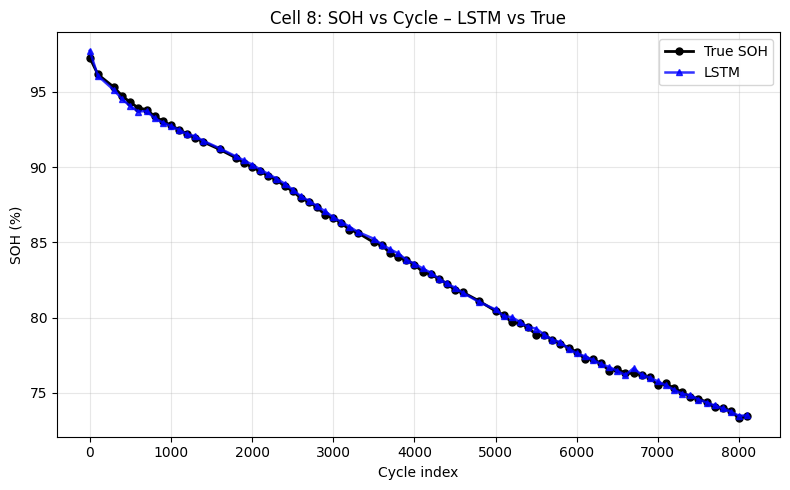

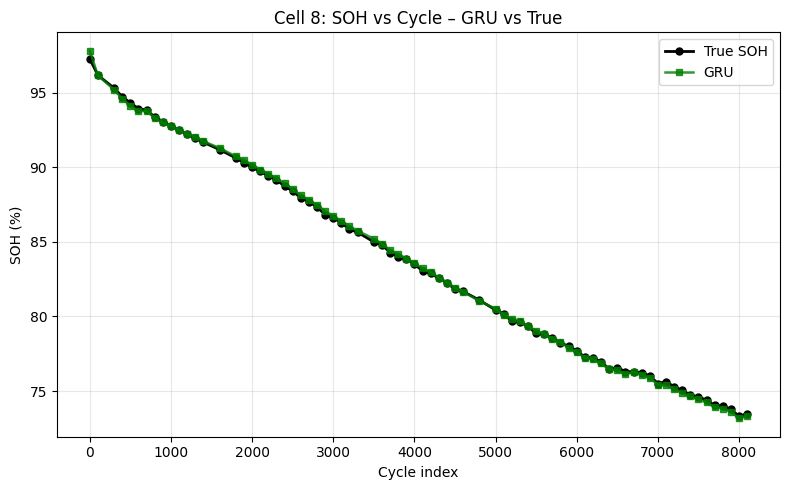

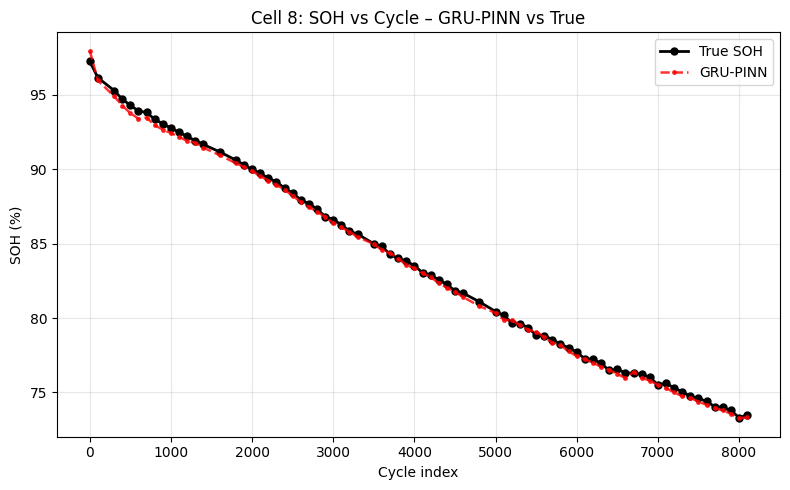

In [31]:
cell_to_plot = 8 # change to 1..8 for other cells
evaluate_cell_curve(cell_to_plot)


In [32]:
def evaluate_cell_curve(cell_to_plot=3):
    """
    For a given cell_id (1..8), take the test-set points,
    and plot, in SEPARATE figures:
      - True SOH vs cycle + LSTM prediction
      - True SOH vs cycle + GRU prediction
      - True SOH vs cycle + GRU-PINN prediction
    Also print MAE/RMSE for each model on that cell.
    """
    mask = (cell_ids_test == cell_to_plot)
    if mask.sum() == 0:
        print(f"\nNo test samples for Cell {cell_to_plot} (maybe all in train?).")
        return

    cyc_cell   = cycles_test[mask]
    true_cell  = soh_true_pct[mask]
    lstm_cell  = soh_lstm_pct[mask]
    gru_cell   = soh_gru_pct[mask]
    pinn_cell  = soh_pinn_pct[mask]

    # Sort by cycle number
    order = np.argsort(cyc_cell)
    cyc_cell   = cyc_cell[order]
    true_cell  = true_cell[order]
    lstm_cell  = lstm_cell[order]
    gru_cell   = gru_cell[order]
    pinn_cell  = pinn_cell[order]

    # Metrics per model on this cell
    def mae_rmse(pred, true):
        mae = np.mean(np.abs(pred - true))
        rmse = np.sqrt(np.mean((pred - true)**2))
        return mae, rmse

    mae_lstm, rmse_lstm = mae_rmse(lstm_cell, true_cell)
    mae_gru,  rmse_gru  = mae_rmse(gru_cell, true_cell)
    mae_pinn, rmse_pinn = mae_rmse(pinn_cell, true_cell)

    print(f"\n=== Cell {cell_to_plot}: SOH vs Cycle (Test set) ===")
    print(f"LSTM : MAE = {mae_lstm:.3f} %, RMSE = {rmse_lstm:.3f} %")
    print(f"GRU  : MAE = {mae_gru:.3f} %, RMSE = {rmse_gru:.3f} %")
    print(f"PINN : MAE = {mae_pinn:.3f} %, RMSE = {rmse_pinn:.3f} %")

    # ---------- Plot 1: True vs LSTM ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, lstm_cell, "b^-", label="LSTM", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – LSTM vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Plot 2: True vs GRU ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, gru_cell,  "gs-", label="GRU", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – GRU vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Plot 3: True vs GRU-PINN ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, pinn_cell, "r.--", label="GRU-PINN", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – GRU-PINN vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Cell 8: SOH vs Cycle (Test set) ===
LSTM : MAE = 0.122 %, RMSE = 0.154 %
GRU  : MAE = 0.113 %, RMSE = 0.139 %
PINN : MAE = 0.207 %, RMSE = 0.244 %


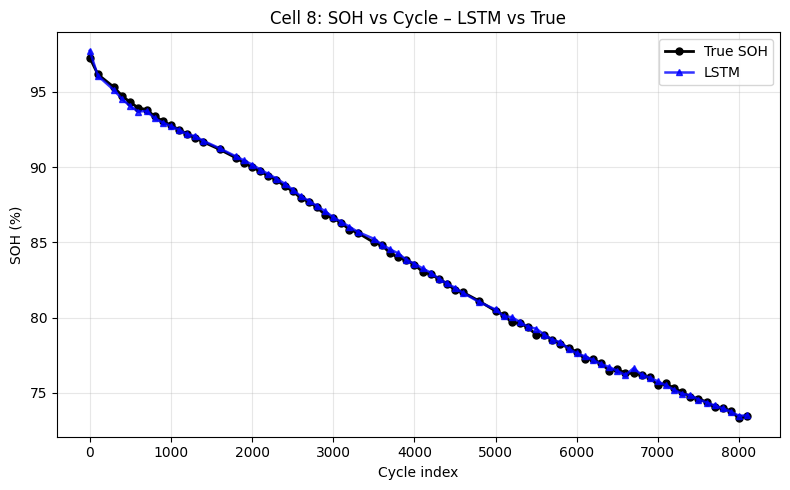

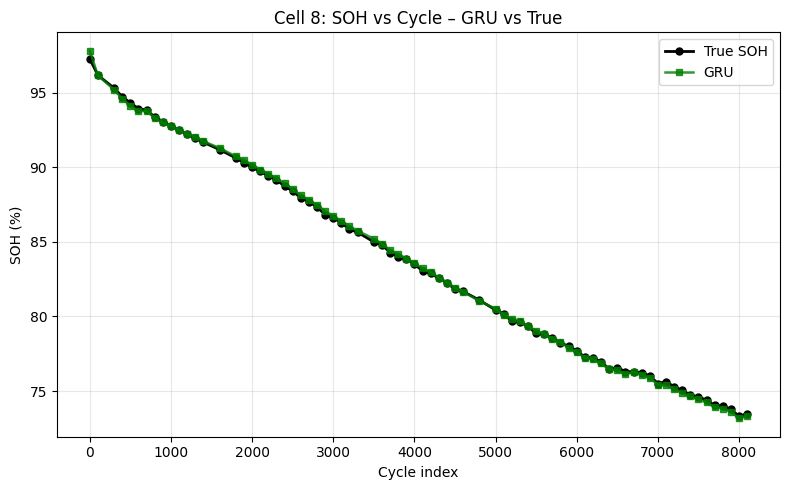

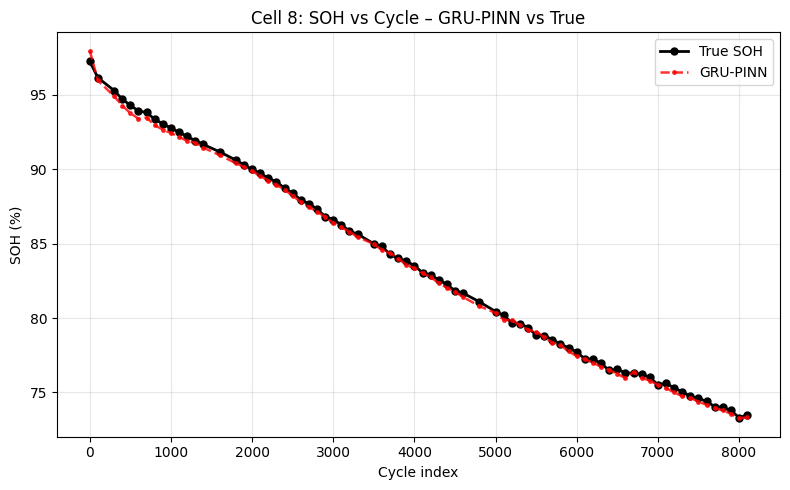

In [33]:
cell_to_plot = 8 # change to 1..8 for other cells
evaluate_cell_curve(cell_to_plot)

Device: cuda

Loading .mat file...
Keys: dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

Extracting sequences with HF1, HF2, V, Q, DVA...
  Cell 1: 78 valid cycles
  Cell 2: 73 valid cycles
  Cell 3: 76 valid cycles
  Cell 4: 47 valid cycles
  Cell 5: 46 valid cycles
  Cell 6: 46 valid cycles
  Cell 7: 77 valid cycles
  Cell 8: 76 valid cycles

Shapes:
  X: (519, 128, 4)
  y_soh: (519, 1)
  dva: (519, 128, 1)

After per-cell split:
  Train sequences: 410
  Test sequences : 109

Training LSTM model...
Epoch 001 | Train Loss: 2.033967e-01 | Test Loss: 8.505231e-03
Epoch 020 | Train Loss: 1.995856e-04 | Test Loss: 1.305548e-04
Epoch 040 | Train Loss: 1.306655e-04 | Test Loss: 1.857007e-04
Epoch 060 | Train Loss: 8.162250e-05 | Test Loss: 1.286731e-04
Epoch 080 | Train Loss: 6.152104e-05 | Test Loss: 1.341725e-04
Epoch 100 | Train Loss: 4.374482e-05 | Test Loss: 1.216046e-04
Epoch 120 | Train Loss: 2.785733e-0

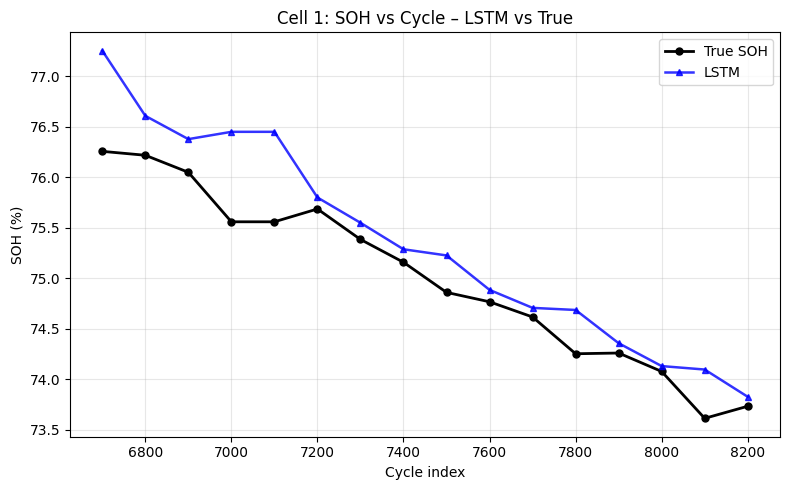

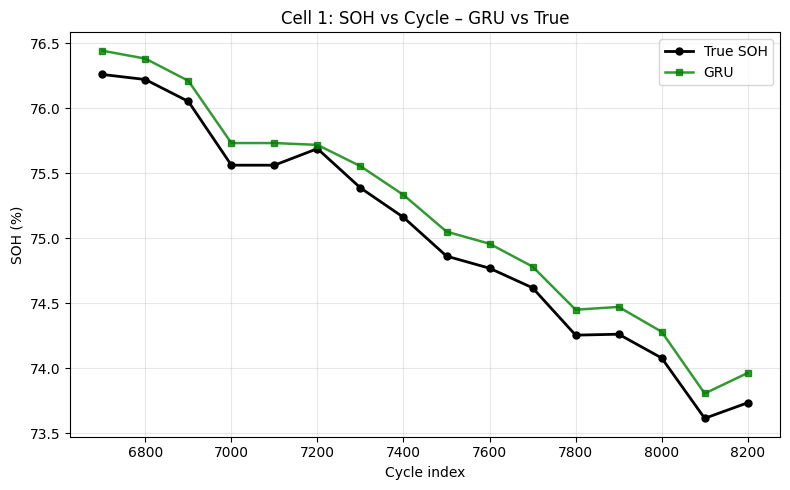

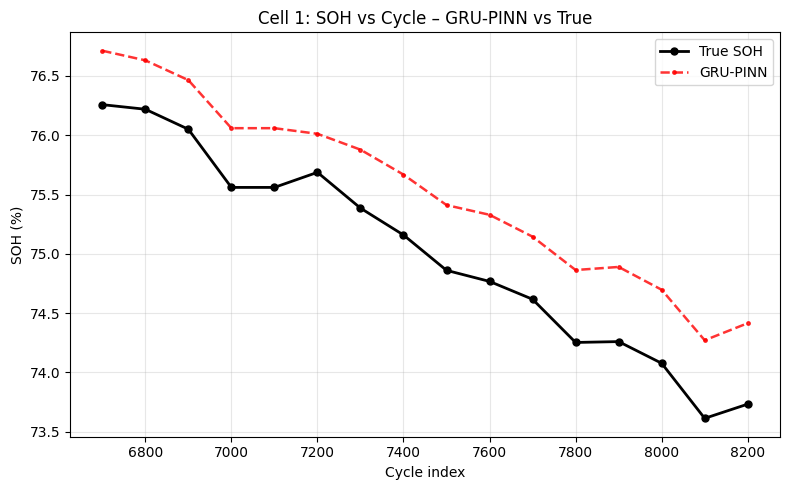


=== Cell 2: SOH vs Cycle (Test set) ===
LSTM : MAE = 0.539 %, RMSE = 0.674 %
GRU  : MAE = 0.258 %, RMSE = 0.388 %
PINN : MAE = 0.822 %, RMSE = 0.870 %


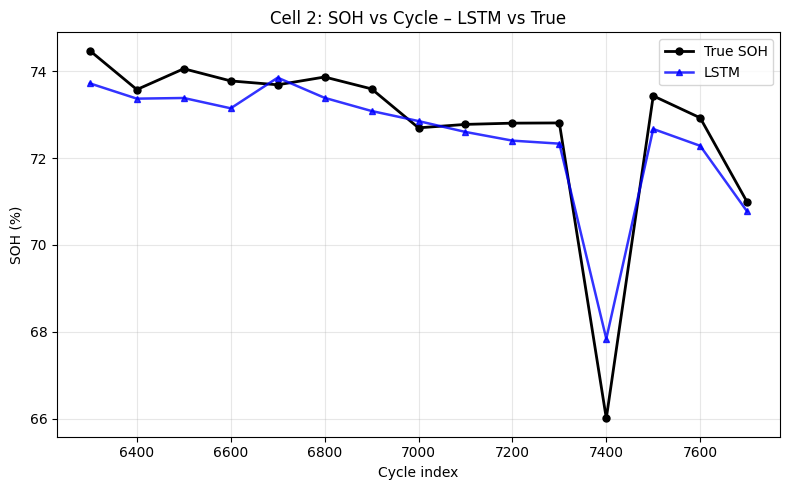

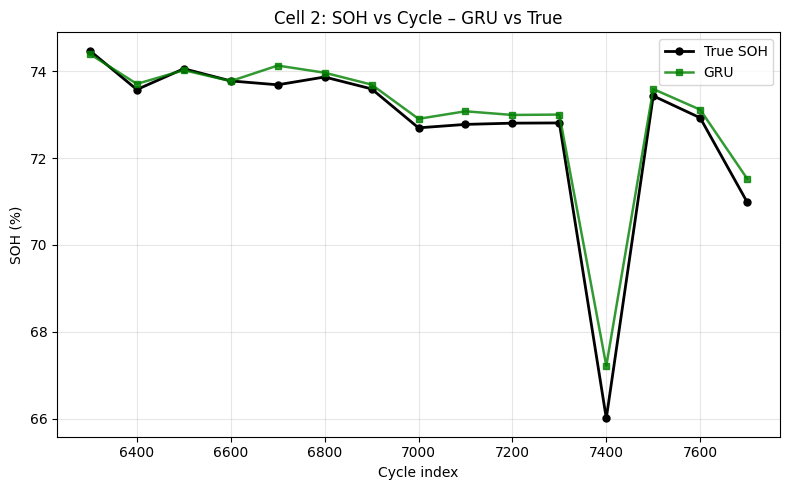

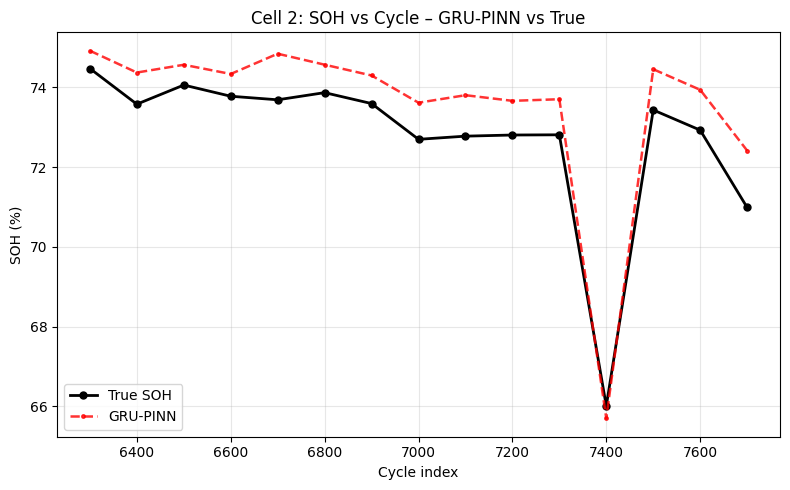


=== Cell 3: SOH vs Cycle (Test set) ===
LSTM : MAE = 0.170 %, RMSE = 0.271 %
GRU  : MAE = 0.116 %, RMSE = 0.133 %
PINN : MAE = 0.427 %, RMSE = 0.442 %


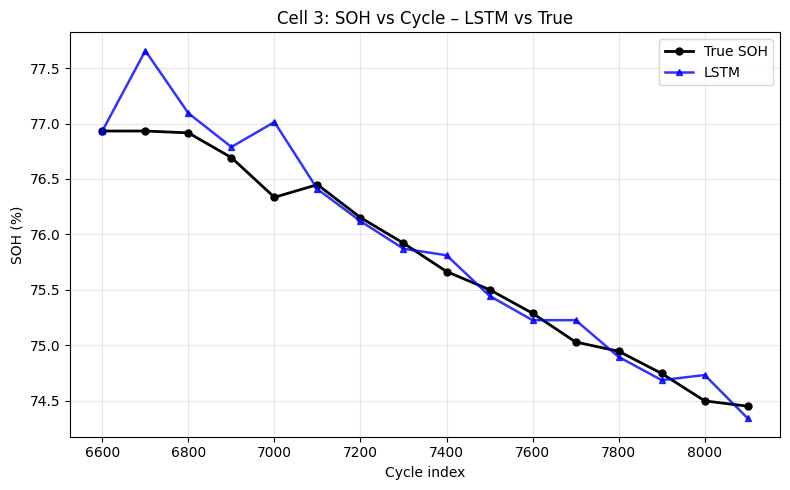

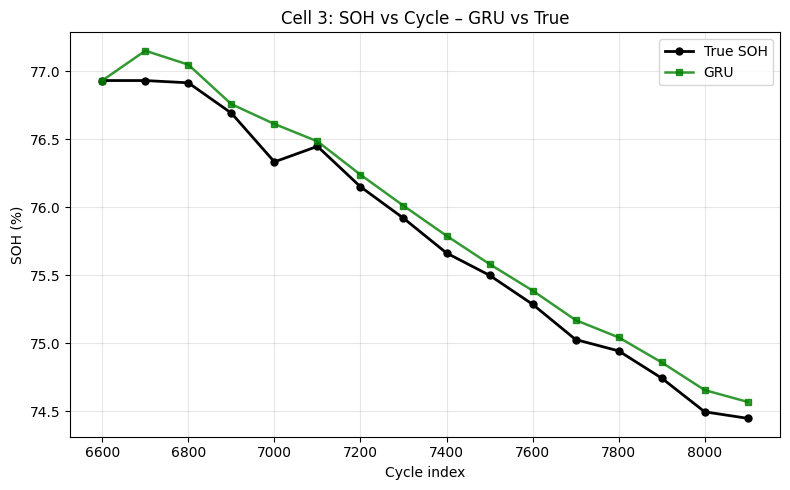

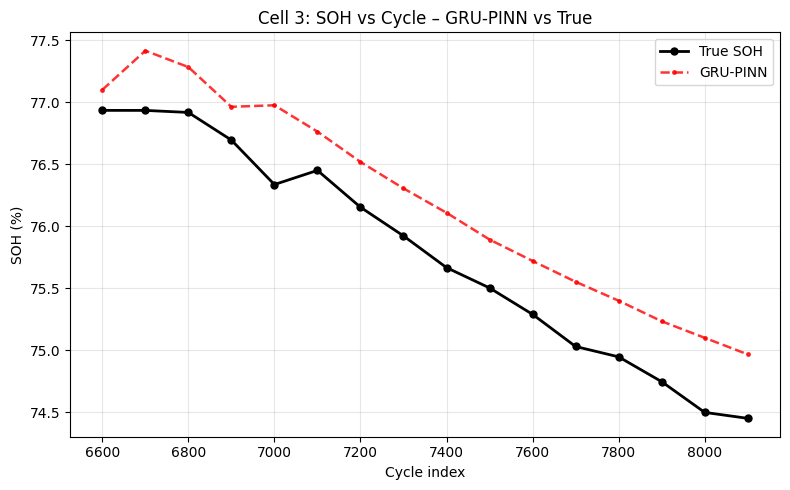


=== Cell 4: SOH vs Cycle (Test set) ===
LSTM : MAE = 0.665 %, RMSE = 0.689 %
GRU  : MAE = 0.235 %, RMSE = 0.240 %
PINN : MAE = 0.402 %, RMSE = 0.407 %


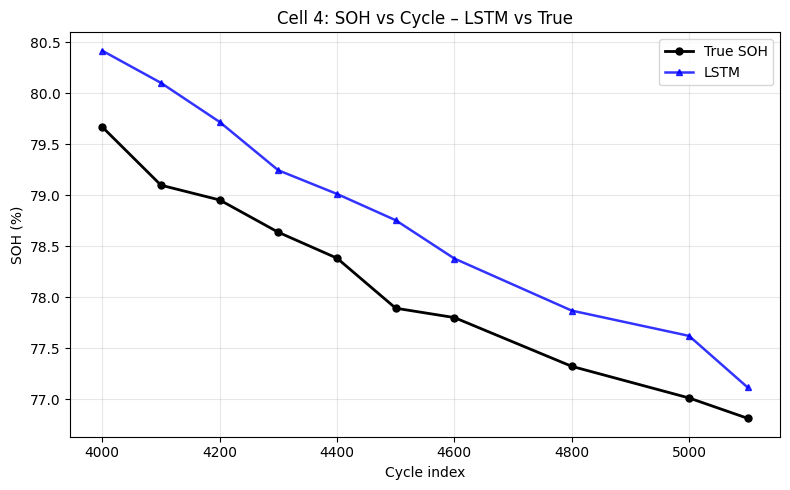

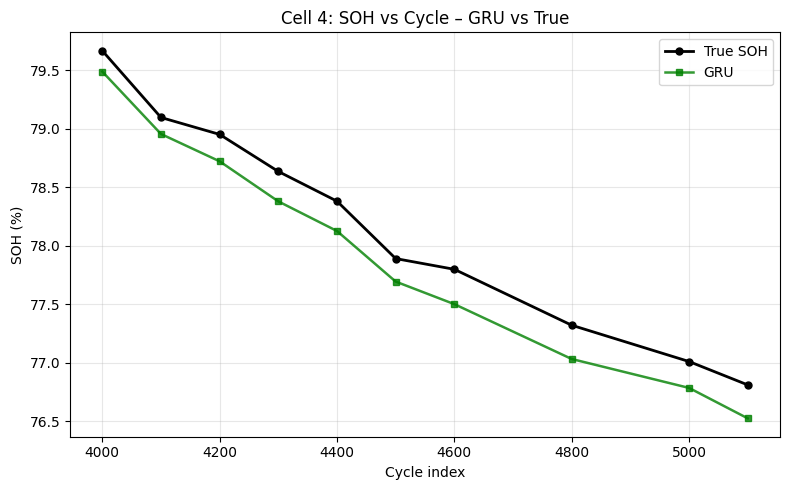

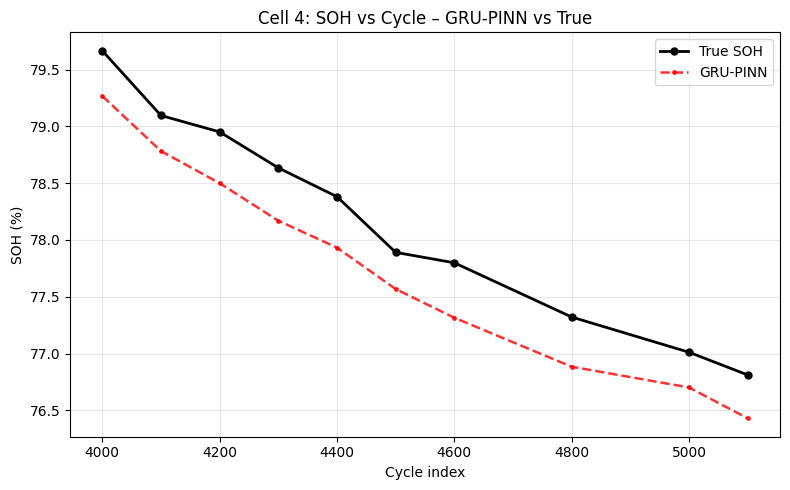


=== Cell 5: SOH vs Cycle (Test set) ===
LSTM : MAE = 0.754 %, RMSE = 1.600 %
GRU  : MAE = 0.095 %, RMSE = 0.107 %
PINN : MAE = 1.216 %, RMSE = 3.381 %


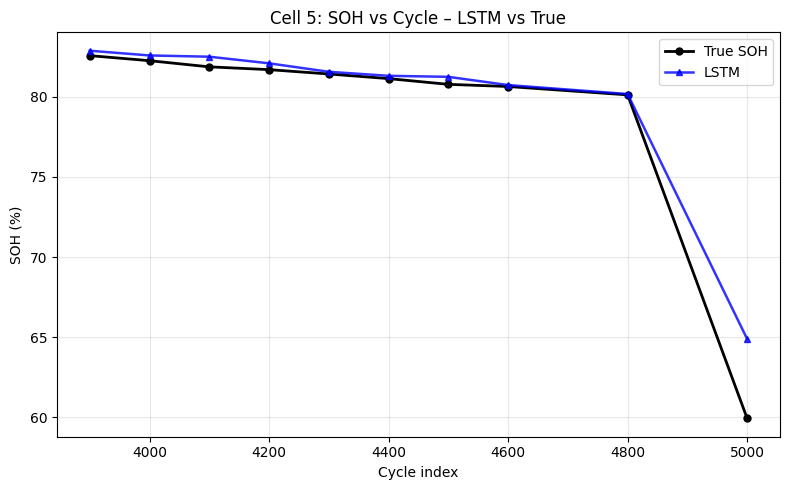

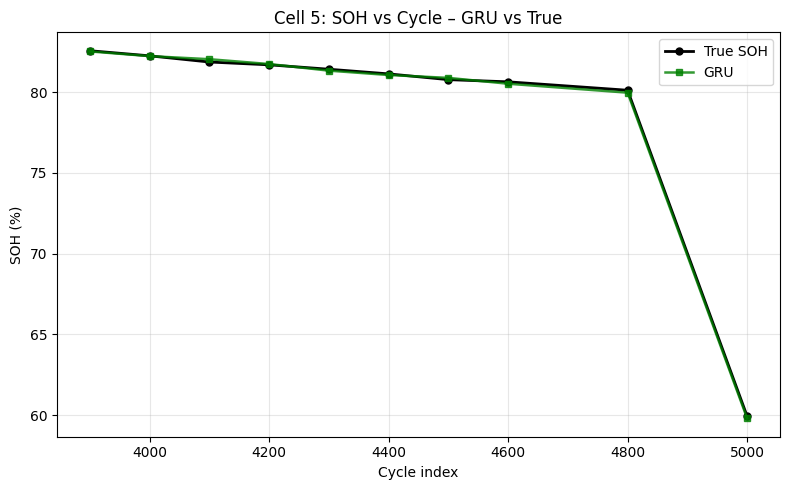

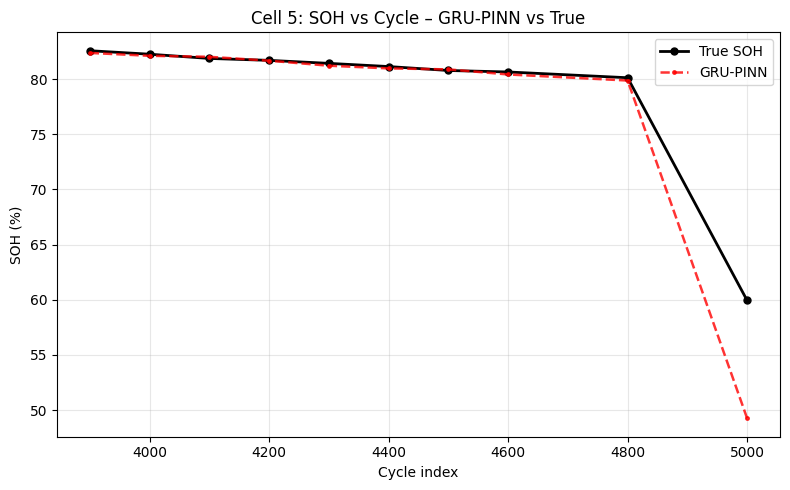


=== Cell 6: SOH vs Cycle (Test set) ===
LSTM : MAE = 0.373 %, RMSE = 0.412 %
GRU  : MAE = 0.235 %, RMSE = 0.313 %
PINN : MAE = 0.400 %, RMSE = 0.446 %


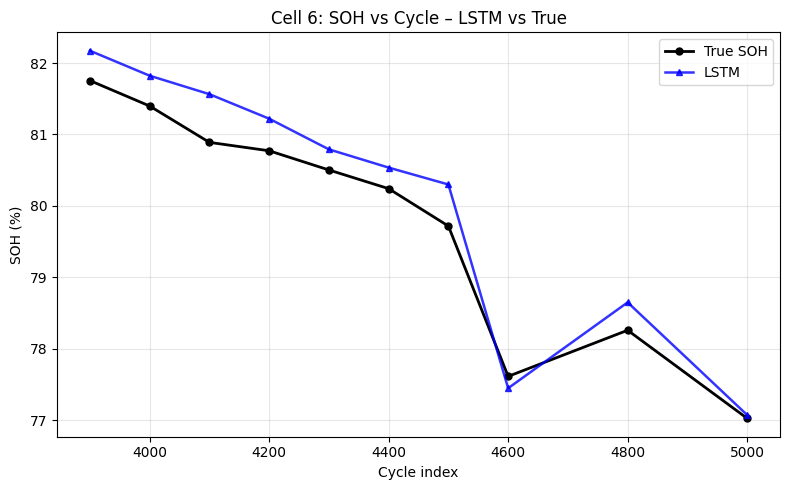

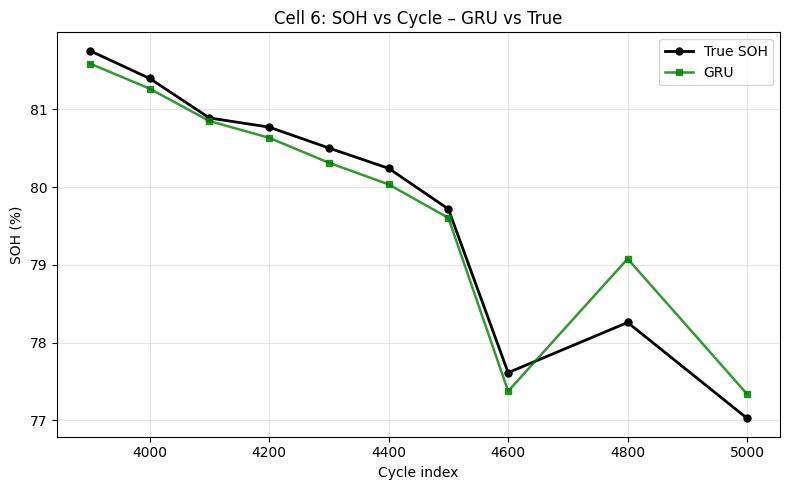

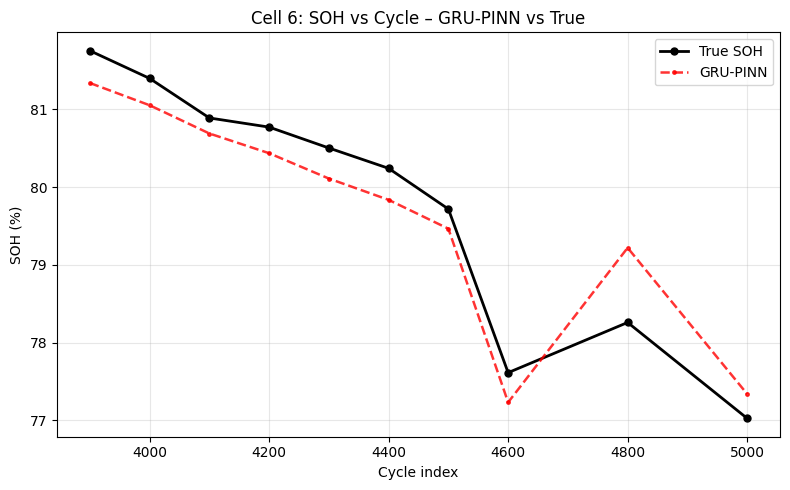


=== Cell 7: SOH vs Cycle (Test set) ===
LSTM : MAE = 0.449 %, RMSE = 0.487 %
GRU  : MAE = 0.082 %, RMSE = 0.101 %
PINN : MAE = 0.271 %, RMSE = 0.309 %


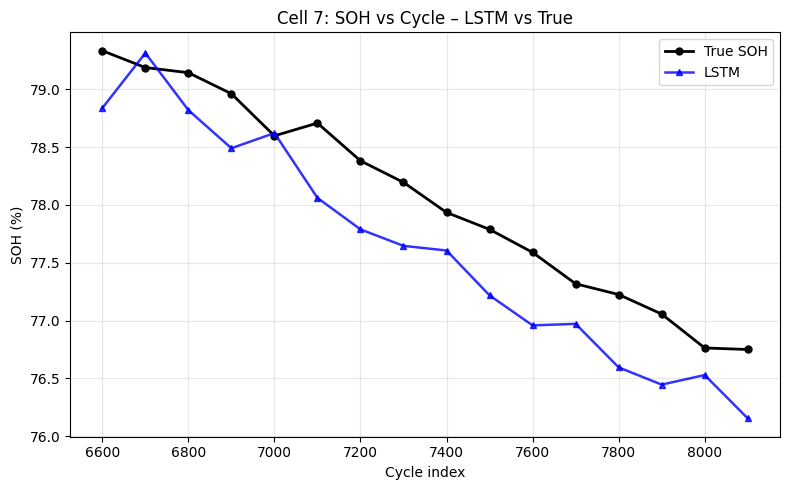

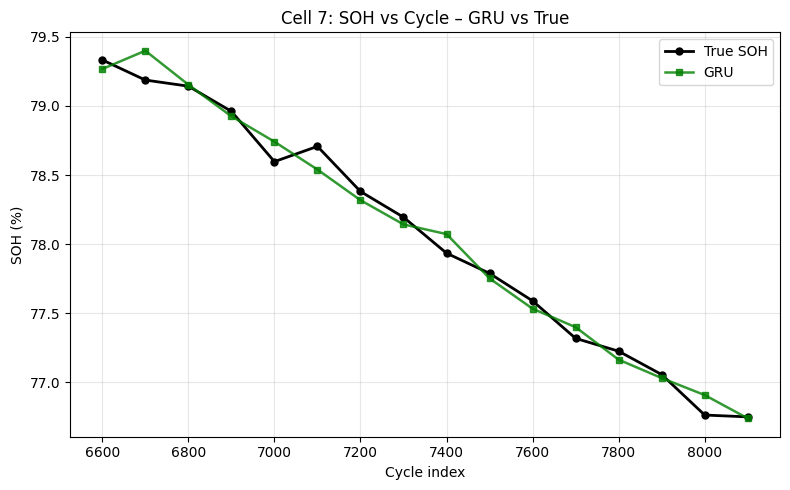

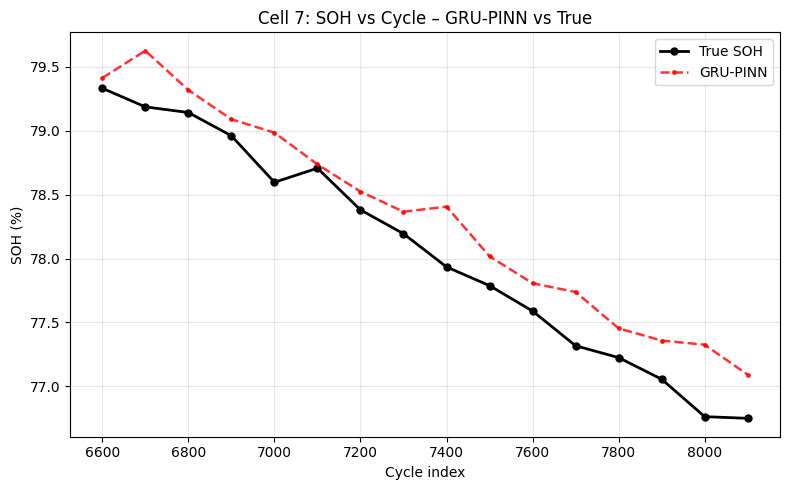


=== Cell 8: SOH vs Cycle (Test set) ===
LSTM : MAE = 0.275 %, RMSE = 0.303 %
GRU  : MAE = 0.123 %, RMSE = 0.144 %
PINN : MAE = 0.153 %, RMSE = 0.180 %


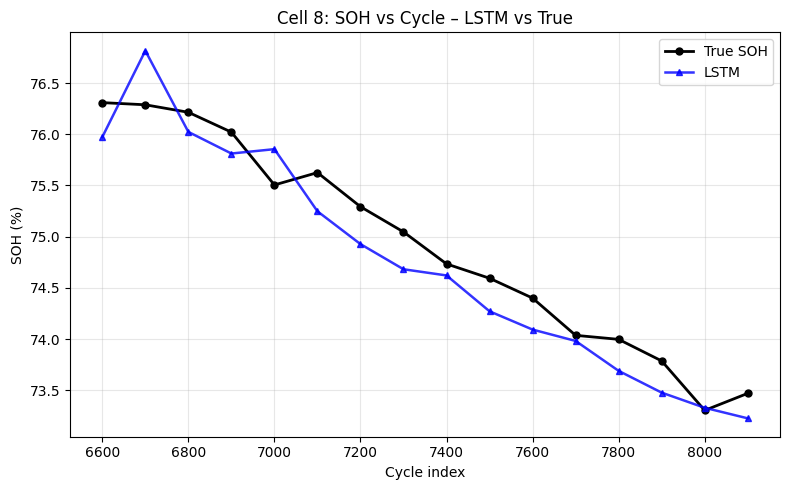

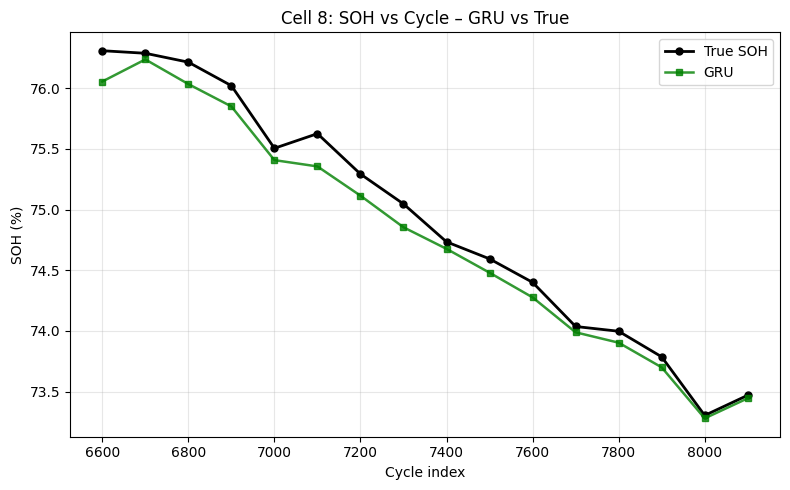

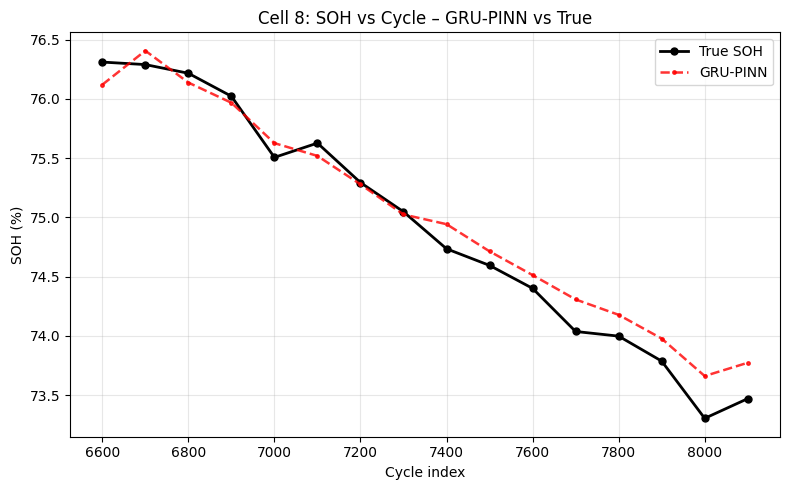


Done training + per-cell evaluation for all three models.


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ============================================================
# 0. Config
# ============================================================

MAT_FILE = "Oxford_Battery_Degradation_Dataset_1.mat"
INIT_CAPACITY = 740.0          # mAh
SEQ_LEN = 128                  # resampled sequence length

VAL_SPLIT = 0.2                # per-cell split: 80% train, 20% test in each cell
BATCH_SIZE = 32

EPOCHS_LSTM = 200
EPOCHS_GRU  = 200
EPOCHS_PINN = 200

LR = 1e-3
LAMBDA_PHYS = 0.1              # physics loss weight for GRU-PINN

# Model checkpoint paths
LSTM_CKPT = "best_lstm_hf_vq_soh.pt"
GRU_CKPT = "best_gru_hf_vq_soh.pt"
GRU_PINN_CKPT = "best_gru_pinn_hf_vq_soh_dva.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

print("\nLoading .mat file...")
data = scipy.io.loadmat(MAT_FILE)
print("Keys:", data.keys())


# ============================================================
# 1. Helpers: HF1/HF2 & DVA & feature extraction
# ============================================================

def compute_hf_features_for_cycle(cyc, init_capacity=740.0):
    """
    Given one cycle struct (from MATLAB), compute:
      HF1: charge time 3.8V -> 4.1V (C1ch)
      HF2: discharge time 4.1V -> 3.8V (C1dc)
      capacity: average of charge & discharge capacities if both valid

    Returns:
        HF1 (float or np.nan),
        HF2 (float or np.nan),
        capacity (float, 0 if invalid)
    """
    HF1 = np.nan
    HF2 = np.nan
    capacity_ch = 0.0
    capacity_dc = 0.0

    # ----- Charging phase: C1ch -> HF1 -----
    if "C1ch" in cyc.dtype.names:
        blk_ch = cyc["C1ch"][0, 0]
        if all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
            t_ch = blk_ch["t"][0, 0].ravel().astype(float)
            v_ch = blk_ch["v"][0, 0].ravel().astype(float)
            q_ch = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t_ch) > 10:
                try:
                    idx_3_8 = np.where(v_ch >= 3.8)[0]
                    idx_4_1 = np.where(v_ch >= 4.1)[0]
                    if len(idx_3_8) > 0 and len(idx_4_1) > 0:
                        t_start = t_ch[idx_3_8[0]]
                        t_end   = t_ch[idx_4_1[0]]
                        if t_end > t_start:
                            HF1 = t_end - t_start
                except Exception:
                    HF1 = np.nan

                capacity_ch = float(q_ch[-1] - q_ch[0])

    # ----- Discharging phase: C1dc -> HF2 -----
    if "C1dc" in cyc.dtype.names:
        blk_dc = cyc["C1dc"][0, 0]
        if all(k in blk_dc.dtype.names for k in ["t", "v", "q"]):
            t_dc = blk_dc["t"][0, 0].ravel().astype(float)
            v_dc = blk_dc["v"][0, 0].ravel().astype(float)
            q_dc = blk_dc["q"][0, 0].ravel().astype(float)

            if len(t_dc) > 10:
                try:
                    idx_4_1 = np.where(v_dc <= 4.1)[0]
                    idx_3_8 = np.where(v_dc <= 3.8)[0]
                    if len(idx_4_1) > 0 and len(idx_3_8) > 0:
                        t_start = t_dc[idx_4_1[0]]
                        t_end   = t_dc[idx_3_8[0]]
                        if t_end > t_start:
                            HF2 = t_end - t_start
                except Exception:
                    HF2 = np.nan

                capacity_dc = float(abs(q_dc[-1] - q_dc[0]))

    # ----- Capacity -----
    if capacity_ch > 0 and capacity_dc > 0:
        capacity = 0.5 * (capacity_ch + capacity_dc)
    elif capacity_ch > 0:
        capacity = capacity_ch
    elif capacity_dc > 0:
        capacity = capacity_dc
    else:
        capacity = 0.0

    return HF1, HF2, capacity


def compute_dva(v, q, dq_eps=1e-6, dq_thresh=1e-5, clip_val=100.0):
    """
    Compute DVA = dV/dQ for 1D arrays v, q (same length).
    Used for the GRU-PINN physics target.
    """
    v = np.asarray(v, dtype=float)
    q = np.asarray(q, dtype=float)

    dq = np.gradient(q)
    dv = np.gradient(v)

    dva = np.zeros_like(v, dtype=float)

    small = np.abs(dq) < dq_thresh
    safe_dq = dq.copy()
    safe_dq[small] = np.sign(dq[small]) * dq_eps + (dq[small] == 0) * dq_eps

    dva = dv / safe_dq
    dva[small] = 0.0

    if clip_val is not None:
        dva = np.clip(dva, -clip_val, clip_val)

    return dva


def extract_sequences_with_hf_and_dva(data, L=128, init_capacity=740.0):
    """
    Extract:
      - X_seq: [L, 4] = [V, Q, HF1, HF2]
      - y_soh: [1] SOH fraction
      - dva:   [L, 1] DVA curve (for GRU-PINN)
      - cell_ids, cycles
    """
    X_list = []
    y_list = []
    dva_list = []
    cell_ids = []
    cycles = []

    print("\nExtracting sequences with HF1, HF2, V, Q, DVA...")

    for cell_id in range(1, 9):
        cell_key = f"Cell{cell_id}"
        if cell_key not in data:
            print(f"  {cell_key} not found, skipping.")
            continue

        cell = data[cell_key]
        cyc_names = sorted(cell.dtype.names, key=lambda s: int(s[3:]))

        count = 0
        for cyc_name in cyc_names:
            cyc_idx = int(cyc_name[3:])
            cyc = cell[cyc_name][0, 0]

            HF1, HF2, capacity = compute_hf_features_for_cycle(cyc, init_capacity=init_capacity)
            if capacity <= 0 or np.isnan(HF1) or np.isnan(HF2):
                continue

            soh = capacity / float(init_capacity)

            # V, Q from C1ch
            if "C1ch" not in cyc.dtype.names:
                continue
            blk_ch = cyc["C1ch"][0, 0]
            if not all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
                continue

            t = blk_ch["t"][0, 0].ravel().astype(float)
            v = blk_ch["v"][0, 0].ravel().astype(float)
            q = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t) < 5:
                continue

            # Resample
            t_new = np.linspace(t[0], t[-1], L)
            v_new = np.interp(t_new, t, v)
            q_new = np.interp(t_new, t, q)

            # DVA
            dva = compute_dva(v_new, q_new)  # [L]

            # Features [V, Q, HF1, HF2]
            HF1_arr = np.full_like(v_new, HF1, dtype=float)
            HF2_arr = np.full_like(v_new, HF2, dtype=float)
            X_seq = np.stack([v_new, q_new, HF1_arr, HF2_arr], axis=-1)  # [L, 4]

            X_list.append(X_seq)
            y_list.append(soh)
            dva_list.append(dva[:, None])
            cell_ids.append(cell_id)
            cycles.append(cyc_idx)
            count += 1

        print(f"  Cell {cell_id}: {count} valid cycles")

    X_arr = np.array(X_list, dtype=np.float32)              # [N, L, 4]
    y_arr = np.array(y_list, dtype=np.float32)[:, None]     # [N, 1]
    dva_arr = np.array(dva_list, dtype=np.float32)          # [N, L, 1]
    cell_ids_arr = np.array(cell_ids, dtype=np.int32)       # [N]
    cycles_arr = np.array(cycles, dtype=np.int32)           # [N]

    return X_arr, y_arr, dva_arr, cell_ids_arr, cycles_arr


# ============================================================
# 2. Build dataset & PER-CELL split
# ============================================================

X, y_soh, dva, cell_ids, cycles = extract_sequences_with_hf_and_dva(
    data, L=SEQ_LEN, init_capacity=INIT_CAPACITY
)
print("\nShapes:")
print("  X:", X.shape)         # [N, L, 4]
print("  y_soh:", y_soh.shape) # [N, 1]
print("  dva:", dva.shape)     # [N, L, 1]

# ---- Per-cell split ----
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []
dva_train_list, dva_test_list = [], []
cell_ids_train_list, cell_ids_test_list = [], []
cycles_train_list, cycles_test_list = [], []

for cid in range(1, 9):
    cid_mask = (cell_ids == cid)
    if cid_mask.sum() == 0:
        continue

    X_c = X[cid_mask]
    y_c = y_soh[cid_mask]
    dva_c = dva[cid_mask]
    cyc_c = cycles[cid_mask]
    cell_c = cell_ids[cid_mask]

    # sort by cycle index for this cell
    order = np.argsort(cyc_c)
    X_c = X_c[order]
    y_c = y_c[order]
    dva_c = dva_c[order]
    cyc_c = cyc_c[order]
    cell_c = cell_c[order]

    N_c = len(X_c)
    n_train_c = int((1.0 - VAL_SPLIT) * N_c)
    if n_train_c < 1 or N_c - n_train_c < 1:
        # If too few samples, skip splitting this cell
        print(f"Cell {cid}: not enough samples ({N_c}) for split, putting all in train.")
        X_train_list.append(X_c)
        y_train_list.append(y_c)
        dva_train_list.append(dva_c)
        cell_ids_train_list.append(cell_c)
        cycles_train_list.append(cyc_c)
        continue

    X_train_c = X_c[:n_train_c]
    X_test_c  = X_c[n_train_c:]
    y_train_c = y_c[:n_train_c]
    y_test_c  = y_c[n_train_c:]
    dva_train_c = dva_c[:n_train_c]
    dva_test_c  = dva_c[n_train_c:]
    cyc_train_c = cyc_c[:n_train_c]
    cyc_test_c  = cyc_c[n_train_c:]
    cell_train_c = cell_c[:n_train_c]
    cell_test_c  = cell_c[n_train_c:]

    X_train_list.append(X_train_c)
    X_test_list.append(X_test_c)
    y_train_list.append(y_train_c)
    y_test_list.append(y_test_c)
    dva_train_list.append(dva_train_c)
    dva_test_list.append(dva_test_c)
    cell_ids_train_list.append(cell_train_c)
    cell_ids_test_list.append(cell_test_c)
    cycles_train_list.append(cyc_train_c)
    cycles_test_list.append(cyc_test_c)

# Concatenate over cells
X_train = np.concatenate(X_train_list, axis=0)
X_test  = np.concatenate(X_test_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_test  = np.concatenate(y_test_list, axis=0)
dva_train = np.concatenate(dva_train_list, axis=0)
dva_test  = np.concatenate(dva_test_list, axis=0)
cell_ids_train = np.concatenate(cell_ids_train_list, axis=0)
cell_ids_test  = np.concatenate(cell_ids_test_list, axis=0)
cycles_train   = np.concatenate(cycles_train_list, axis=0)
cycles_test    = np.concatenate(cycles_test_list, axis=0)

print(f"\nAfter per-cell split:")
print(f"  Train sequences: {len(X_train)}")
print(f"  Test sequences : {len(X_test)}")

# ---- Normalization ----

# Features: V, Q, HF1, HF2
flat_train = X_train.reshape(-1, X_train.shape[-1])  # [N*L, 4]
mu_feat = flat_train.mean(axis=0)
sd_feat = flat_train.std(axis=0) + 1e-8

X_train = (X_train - mu_feat) / sd_feat
X_test  = (X_test  - mu_feat) / sd_feat

# DVA (for PINN)
flat_dva_train = dva_train.reshape(-1, dva_train.shape[-1])
mu_dva = flat_dva_train.mean(axis=0)
sd_dva = flat_dva_train.std(axis=0) + 1e-8

dva_train_norm = (dva_train - mu_dva) / sd_dva
dva_test_norm  = (dva_test  - mu_dva) / sd_dva

# SOH stays in fraction [0,~1]
y_train_norm = y_train
y_test_norm  = y_test

# Torch datasets/loaders
train_dataset_basic = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train_norm, dtype=torch.float32),
)
test_dataset_basic = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_norm, dtype=torch.float32),
)

train_dataset_pinn = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train_norm, dtype=torch.float32),
    torch.tensor(dva_train_norm, dtype=torch.float32),
)
test_dataset_pinn = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_norm, dtype=torch.float32),
    torch.tensor(dva_test_norm, dtype=torch.float32),
)

train_loader_basic = DataLoader(train_dataset_basic, batch_size=BATCH_SIZE, shuffle=True)
test_loader_basic  = DataLoader(test_dataset_basic,  batch_size=BATCH_SIZE, shuffle=False)

train_loader_pinn  = DataLoader(train_dataset_pinn,  batch_size=BATCH_SIZE, shuffle=True)
test_loader_pinn   = DataLoader(test_dataset_pinn,   batch_size=BATCH_SIZE, shuffle=False)


# ============================================================
# 3. Define model classes
# ============================================================

class LSTM_HF_VQ_SOH(nn.Module):
    """LSTM model: [B, L, 4] -> [B, 1]"""
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        soh = self.fc(last)
        return soh


class GRU_HF_VQ_SOH(nn.Module):
    """GRU model: [B, L, 4] -> [B, 1]"""
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        soh = self.fc(last)
        return soh


class GRU_PINN_SOH_DVA(nn.Module):
    """
    GRU-PINN:
      Input: [B, L, 4]
      Outputs:
        soh_pred: [B, 1]
        dva_pred: [B, L, 1] (normalized DVA)
    """
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc_soh = nn.Linear(hidden, 1)
        self.fc_dva = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.gru(x)        # [B, L, H]
        last = out[:, -1, :]        # [B, H]
        soh = self.fc_soh(last)     # [B, 1]
        dva_pred = self.fc_dva(out) # [B, L, 1]
        return soh, dva_pred


# ============================================================
# 4. Train LSTM
# ============================================================

print("\n======================")
print("Training LSTM model...")
print("======================")

lstm_model = LSTM_HF_VQ_SOH(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

best_loss = float("inf")

for epoch in range(1, EPOCHS_LSTM + 1):
    lstm_model.train()
    train_loss = 0.0
    for xb, yb in train_loader_basic:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = lstm_model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader_basic.dataset)

    # Validate
    lstm_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader_basic:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = lstm_model(xb)
            test_loss += loss_fn(pred, yb).item() * xb.size(0)
    test_loss /= len(test_loader_basic.dataset)

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(lstm_model.state_dict(), LSTM_CKPT)

    if epoch == 1 or epoch % 20 == 0 or epoch == EPOCHS_LSTM:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6e} | Test Loss: {test_loss:.6e}")

print("Best LSTM Test Loss:", best_loss)


# ============================================================
# 5. Train GRU
# ============================================================

print("\n=====================")
print("Training GRU model...")
print("=====================")

gru_model = GRU_HF_VQ_SOH(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

best_loss = float("inf")

for epoch in range(1, EPOCHS_GRU + 1):
    gru_model.train()
    train_loss = 0.0
    for xb, yb in train_loader_basic:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = gru_model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader_basic.dataset)

    # Validate
    gru_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader_basic:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = gru_model(xb)
            test_loss += loss_fn(pred, yb).item() * xb.size(0)
    test_loss /= len(test_loader_basic.dataset)

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(gru_model.state_dict(), GRU_CKPT)

    if epoch == 1 or epoch % 20 == 0 or epoch == EPOCHS_GRU:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6e} | Test Loss: {test_loss:.6e}")

print("Best GRU Test Loss:", best_loss)


# ============================================================
# 6. Train GRU-PINN
# ============================================================

print("\n=========================")
print("Training GRU-PINN model...")
print("=========================")

pinn_model = GRU_PINN_SOH_DVA(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=LR)
mse_loss = nn.MSELoss()

best_loss = float("inf")

for epoch in range(1, EPOCHS_PINN + 1):
    pinn_model.train()
    train_total = 0.0
    train_data = 0.0
    train_phys = 0.0

    for xb, yb, dva_b in train_loader_pinn:
        xb = xb.to(device)
        yb = yb.to(device)
        dva_b = dva_b.to(device)

        optimizer.zero_grad()
        soh_pred, dva_pred = pinn_model(xb)

        loss_data = mse_loss(soh_pred, yb)
        loss_phys = mse_loss(dva_pred, dva_b)
        loss = loss_data + LAMBDA_PHYS * loss_phys

        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        train_total += loss.item() * bs
        train_data  += loss_data.item() * bs
        train_phys  += loss_phys.item() * bs

    train_total /= len(train_loader_pinn.dataset)
    train_data  /= len(train_loader_pinn.dataset)
    train_phys  /= len(train_loader_pinn.dataset)

    # Validation
    pinn_model.eval()
    test_total = 0.0
    test_data  = 0.0
    test_phys  = 0.0

    with torch.no_grad():
        for xb, yb, dva_b in test_loader_pinn:
            xb = xb.to(device)
            yb = yb.to(device)
            dva_b = dva_b.to(device)

            soh_pred, dva_pred = pinn_model(xb)
            loss_data = mse_loss(soh_pred, yb)
            loss_phys = mse_loss(dva_pred, dva_b)
            loss = loss_data + LAMBDA_PHYS * loss_phys

            bs = xb.size(0)
            test_total += loss.item() * bs
            test_data  += loss_data.item() * bs
            test_phys  += loss_phys.item() * bs

    test_total /= len(test_loader_pinn.dataset)
    test_data  /= len(test_loader_pinn.dataset)
    test_phys  /= len(test_loader_pinn.dataset)

    if test_total < best_loss:
        best_loss = test_total
        torch.save(pinn_model.state_dict(), GRU_PINN_CKPT)

    if epoch == 1 or epoch % 20 == 0 or epoch == EPOCHS_PINN:
        print(
            f"Epoch {epoch:03d} | "
            f"Train Total: {train_total:.6e} (Data: {train_data:.6e}, Phys: {train_phys:.6e}) | "
            f"Test Total: {test_total:.6e} (Data: {test_data:.6e}, Phys: {test_phys:.6e})"
        )

print("Best GRU-PINN Test Total Loss:", best_loss)


# ============================================================
# 7. Reload best models & run predictions
# ============================================================

lstm_model.load_state_dict(torch.load(LSTM_CKPT, map_location=device))
gru_model.load_state_dict(torch.load(GRU_CKPT, map_location=device))
pinn_model.load_state_dict(torch.load(GRU_PINN_CKPT, map_location=device))

lstm_model.eval()
gru_model.eval()
pinn_model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    soh_lstm = lstm_model(X_test_tensor).cpu().numpy().flatten()
    soh_gru  = gru_model(X_test_tensor).cpu().numpy().flatten()
    soh_pinn, _ = pinn_model(X_test_tensor)
    soh_pinn = soh_pinn.cpu().numpy().flatten()

soh_true = y_test_norm.flatten()

soh_true_pct = soh_true * 100.0
soh_lstm_pct = soh_lstm * 100.0
soh_gru_pct  = soh_gru  * 100.0
soh_pinn_pct = soh_pinn * 100.0


# ============================================================
# 8. Per-cell evaluation & SEPARATE plots
# ============================================================

def evaluate_cell_curve(cell_to_plot):
    """
    For a given cell_id (1..8), use the per-cell test samples,
    and plot, in SEPARATE figures:
      - True SOH vs cycle + LSTM
      - True SOH vs cycle + GRU
      - True SOH vs cycle + GRU-PINN
    Also print MAE/RMSE for each model on that cell.
    """
    mask = (cell_ids_test == cell_to_plot)
    if mask.sum() == 0:
        print(f"\n[Cell {cell_to_plot}] No test samples (all used for train).")
        return

    cyc_cell   = cycles_test[mask]
    true_cell  = soh_true_pct[mask]
    lstm_cell  = soh_lstm_pct[mask]
    gru_cell   = soh_gru_pct[mask]
    pinn_cell  = soh_pinn_pct[mask]

    # Sort by cycle number
    order = np.argsort(cyc_cell)
    cyc_cell   = cyc_cell[order]
    true_cell  = true_cell[order]
    lstm_cell  = lstm_cell[order]
    gru_cell   = gru_cell[order]
    pinn_cell  = pinn_cell[order]

    # Metrics per model on this cell
    def mae_rmse(pred, true):
        mae = np.mean(np.abs(pred - true))
        rmse = np.sqrt(np.mean((pred - true)**2))
        return mae, rmse

    mae_lstm, rmse_lstm = mae_rmse(lstm_cell, true_cell)
    mae_gru,  rmse_gru  = mae_rmse(gru_cell, true_cell)
    mae_pinn, rmse_pinn = mae_rmse(pinn_cell, true_cell)

    print(f"\n=== Cell {cell_to_plot}: SOH vs Cycle (Test set) ===")
    print(f"LSTM : MAE = {mae_lstm:.3f} %, RMSE = {rmse_lstm:.3f} %")
    print(f"GRU  : MAE = {mae_gru:.3f} %, RMSE = {rmse_gru:.3f} %")
    print(f"PINN : MAE = {mae_pinn:.3f} %, RMSE = {rmse_pinn:.3f} %")

    # ---------- Plot 1: True vs LSTM ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, lstm_cell, "b^-", label="LSTM", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – LSTM vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Plot 2: True vs GRU ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, gru_cell,  "gs-", label="GRU", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – GRU vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Plot 3: True vs GRU-PINN ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, pinn_cell, "r.--", label="GRU-PINN", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – GRU-PINN vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 9. Run per-cell evaluation for ALL cells
# ============================================================

for cid in range(1, 9):
    evaluate_cell_curve(cid)

print("\nDone training + per-cell evaluation for all three models.")


Device: cuda

Loading .mat file...
Keys: dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

Extracting sequences with HF1, HF2, V, Q, DVA, scalar DVA...
  Cell 1: 78 valid cycles
  Cell 2: 73 valid cycles
  Cell 3: 76 valid cycles
  Cell 4: 47 valid cycles
  Cell 5: 46 valid cycles
  Cell 6: 46 valid cycles
  Cell 7: 77 valid cycles
  Cell 8: 76 valid cycles

Shapes:
  X: (519, 128, 4)
  y_soh: (519, 1)
  dva: (519, 128, 1)
  dva_scalar: (519, 1)

After per-cell split:
  Train sequences: 410
  Test sequences : 109


/tmp/ipykernel_2773132/3443421018.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s = np.trapz(dva_win, q_win)  # scalar



Training LSTM model...
[LSTM] Epoch 001 | Train Loss: 3.480517e-01 | Test Loss: 7.707950e-03
[LSTM] Epoch 020 | Train Loss: 2.598770e-04 | Test Loss: 1.329703e-04
[LSTM] Epoch 040 | Train Loss: 1.560283e-04 | Test Loss: 9.263498e-05
[LSTM] Epoch 060 | Train Loss: 9.605540e-05 | Test Loss: 1.536527e-04
[LSTM] Epoch 080 | Train Loss: 7.231391e-05 | Test Loss: 9.811972e-05
[LSTM] Epoch 100 | Train Loss: 5.206871e-05 | Test Loss: 1.131631e-04
[LSTM] Epoch 120 | Train Loss: 2.868619e-05 | Test Loss: 1.441468e-04
[LSTM] Epoch 140 | Train Loss: 2.483672e-05 | Test Loss: 1.146962e-04
[LSTM] Epoch 160 | Train Loss: 3.030894e-05 | Test Loss: 1.257723e-04
[LSTM] Epoch 180 | Train Loss: 2.072530e-05 | Test Loss: 1.129397e-04
[LSTM] Epoch 200 | Train Loss: 2.225457e-05 | Test Loss: 7.609293e-05
Best LSTM Test Loss: 3.3386810840916e-05

Training GRU model...
[GRU ] Epoch 001 | Train Loss: 1.220098e-01 | Test Loss: 3.135708e-03
[GRU ] Epoch 020 | Train Loss: 3.538910e-04 | Test Loss: 4.195590e-05
[G

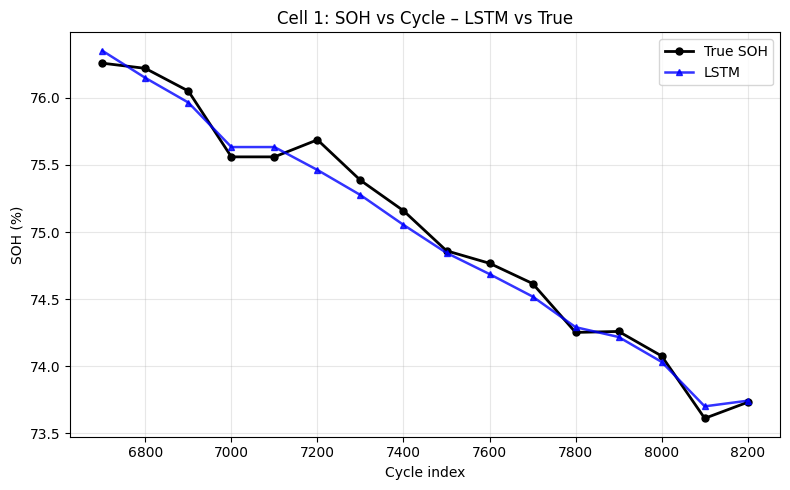

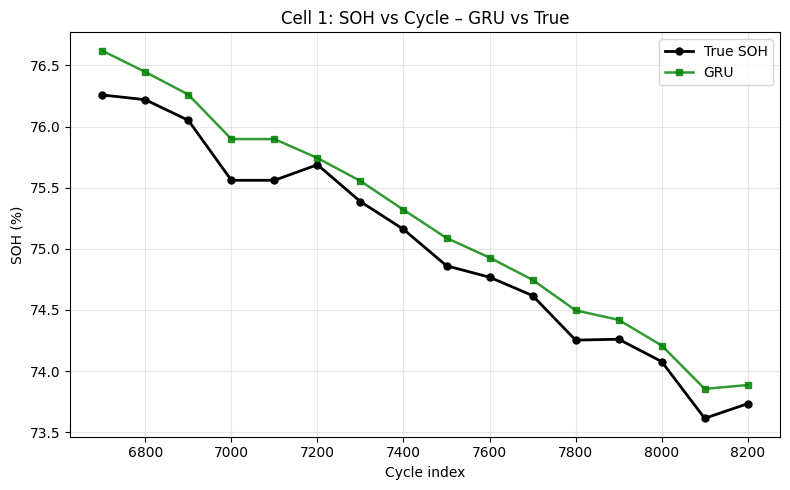

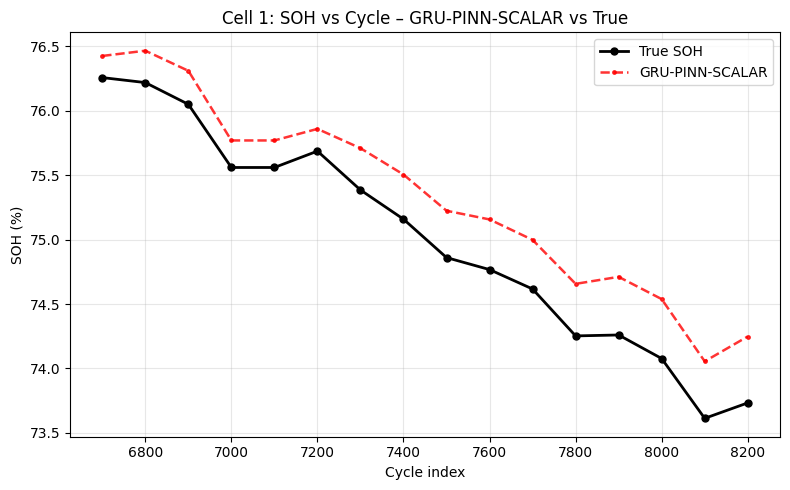

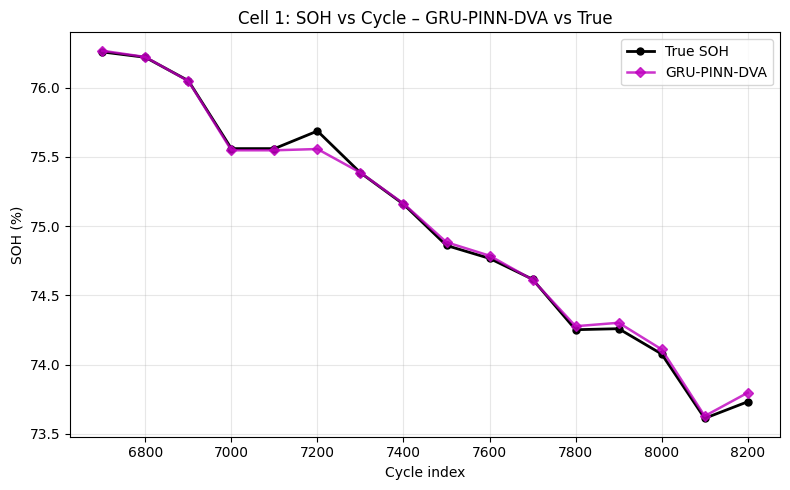


=== Cell 2: SOH vs Cycle (Test set) ===
LSTM           : MAE = 0.386 %, RMSE = 0.686 %
GRU            : MAE = 0.196 %, RMSE = 0.238 %
GRU-PINN-SCALAR: MAE = 0.514 %, RMSE = 0.656 %
GRU-PINN-DVA   : MAE = 0.230 %, RMSE = 0.476 %


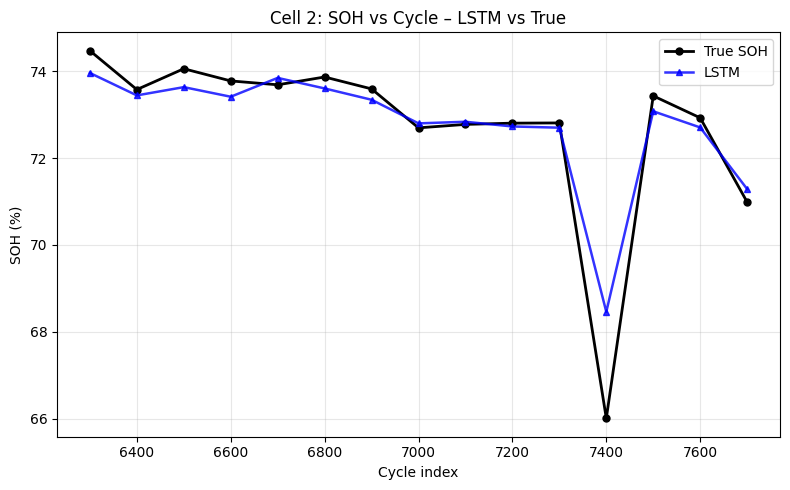

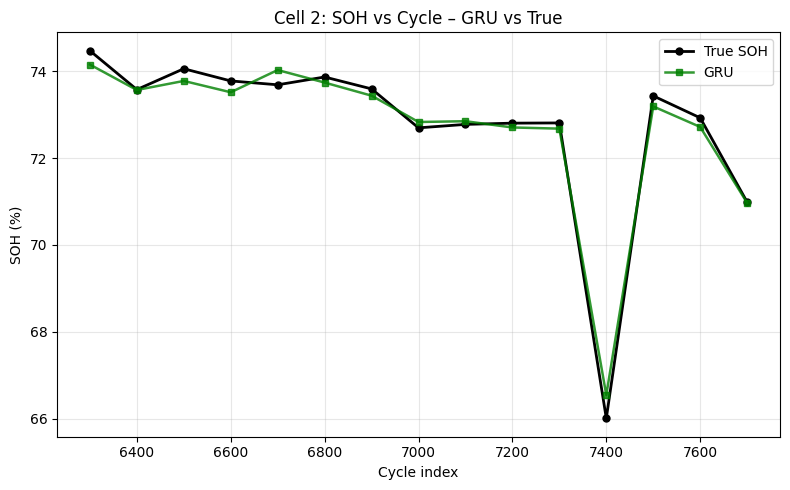

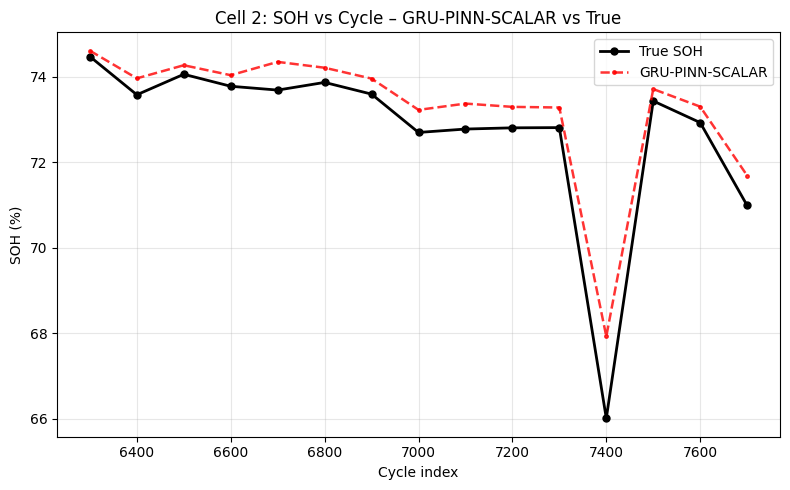

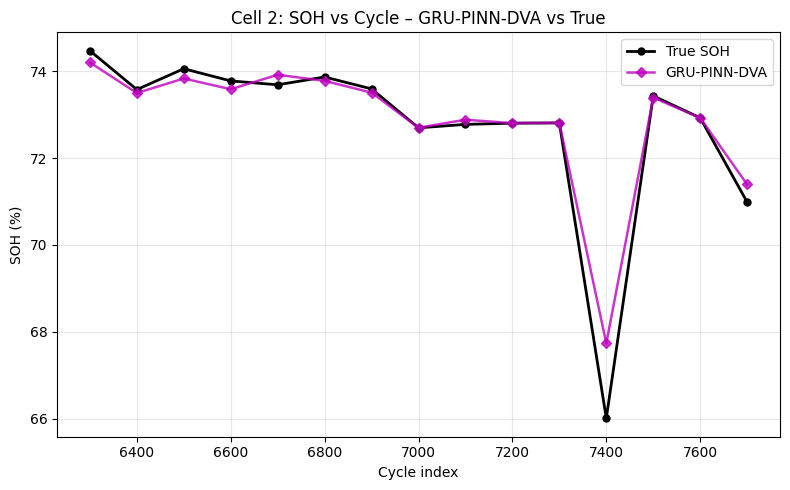


=== Cell 3: SOH vs Cycle (Test set) ===
LSTM           : MAE = 0.184 %, RMSE = 0.198 %
GRU            : MAE = 0.113 %, RMSE = 0.156 %
GRU-PINN-SCALAR: MAE = 0.264 %, RMSE = 0.275 %
GRU-PINN-DVA   : MAE = 0.059 %, RMSE = 0.069 %


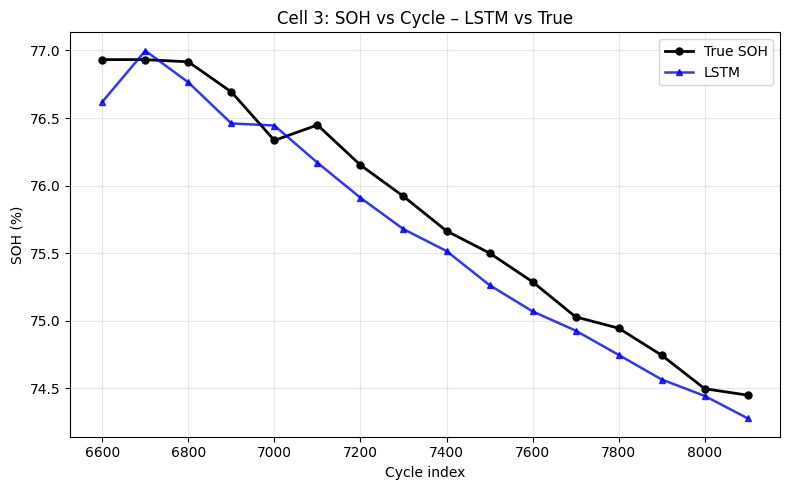

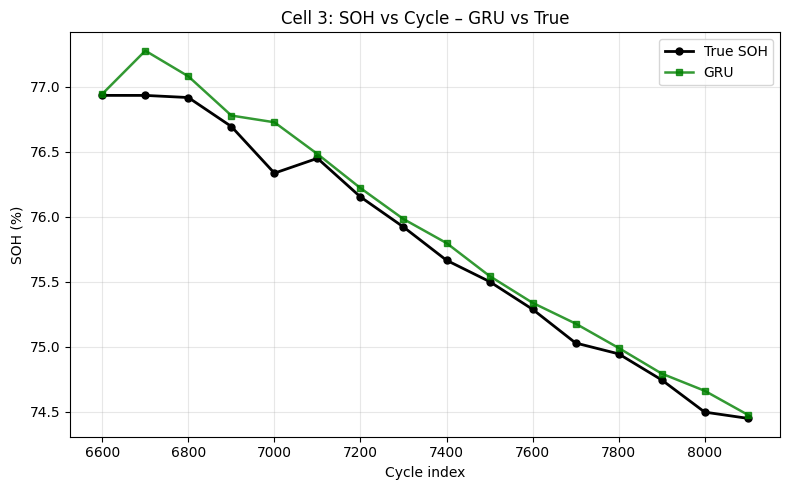

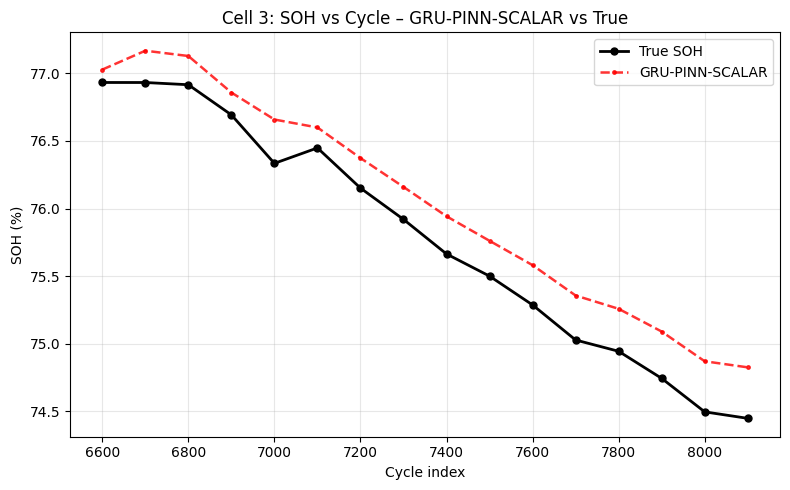

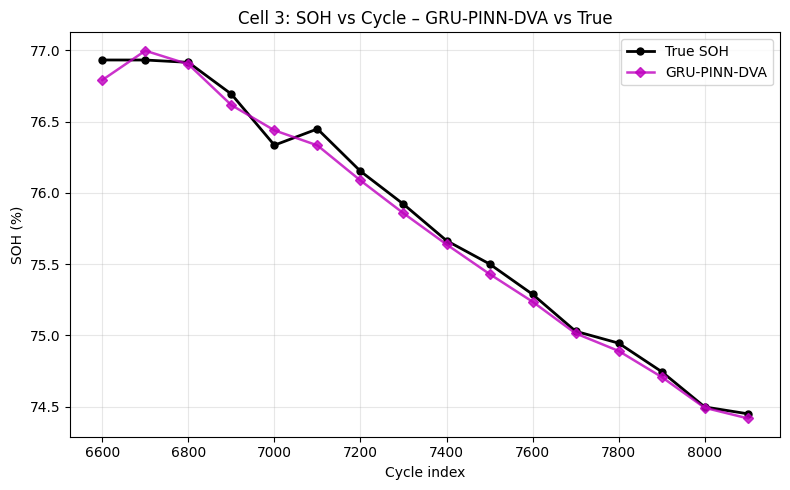


=== Cell 4: SOH vs Cycle (Test set) ===
LSTM           : MAE = 0.379 %, RMSE = 0.386 %
GRU            : MAE = 0.097 %, RMSE = 0.110 %
GRU-PINN-SCALAR: MAE = 0.319 %, RMSE = 0.322 %
GRU-PINN-DVA   : MAE = 0.317 %, RMSE = 0.321 %


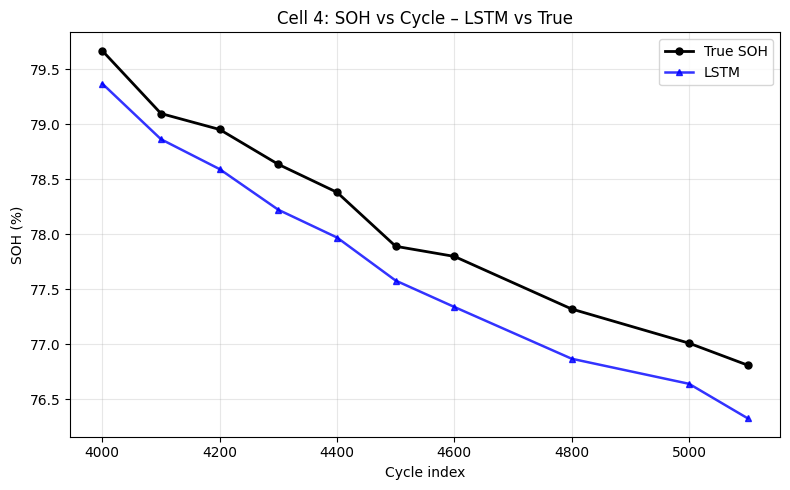

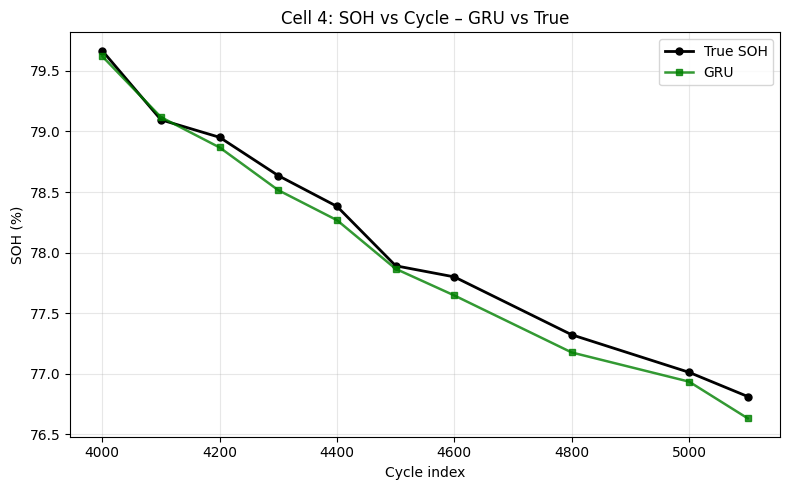

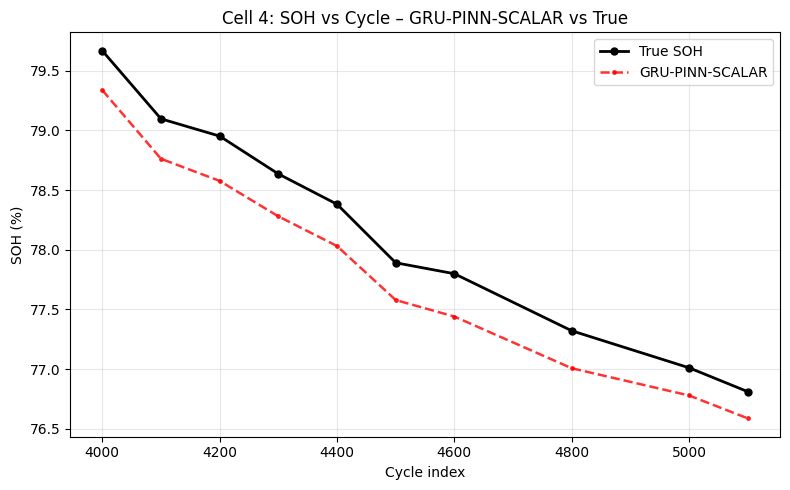

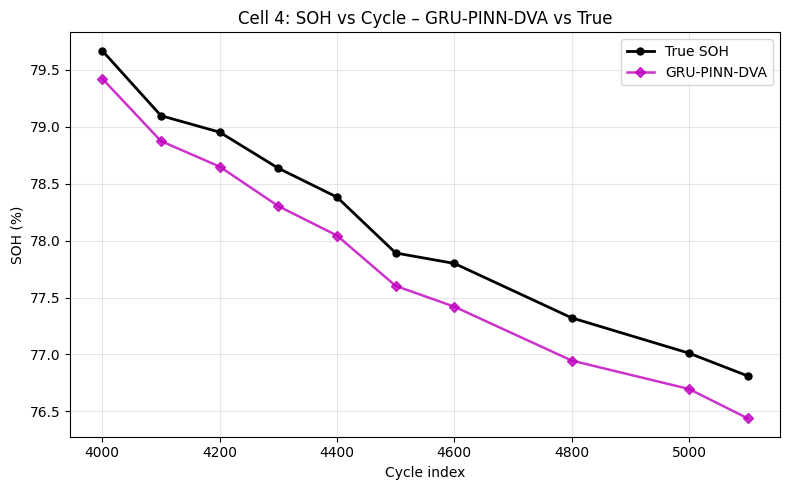


=== Cell 5: SOH vs Cycle (Test set) ===
LSTM           : MAE = 0.612 %, RMSE = 1.428 %
GRU            : MAE = 0.122 %, RMSE = 0.167 %
GRU-PINN-SCALAR: MAE = 0.350 %, RMSE = 0.796 %
GRU-PINN-DVA   : MAE = 0.380 %, RMSE = 0.831 %


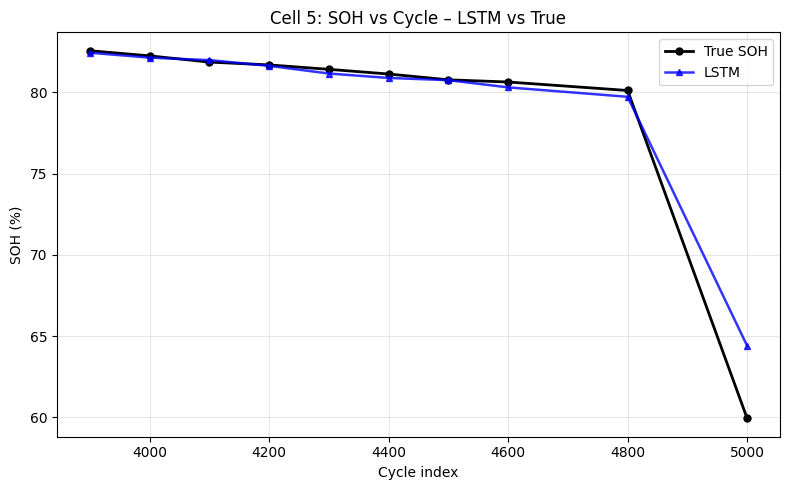

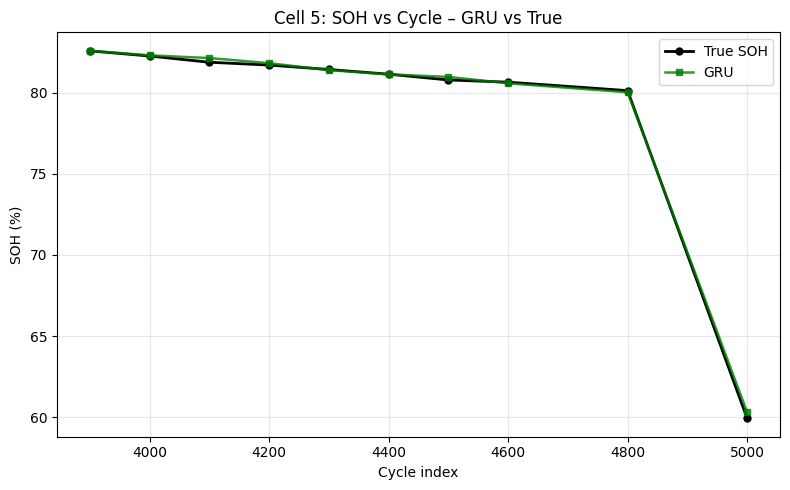

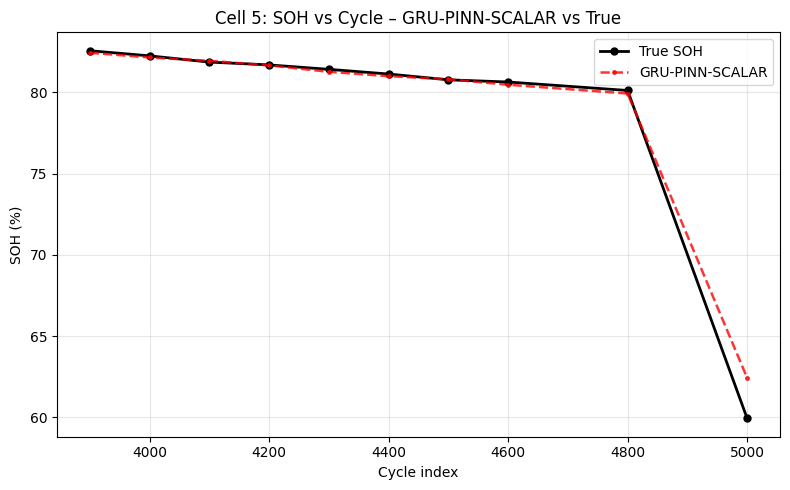

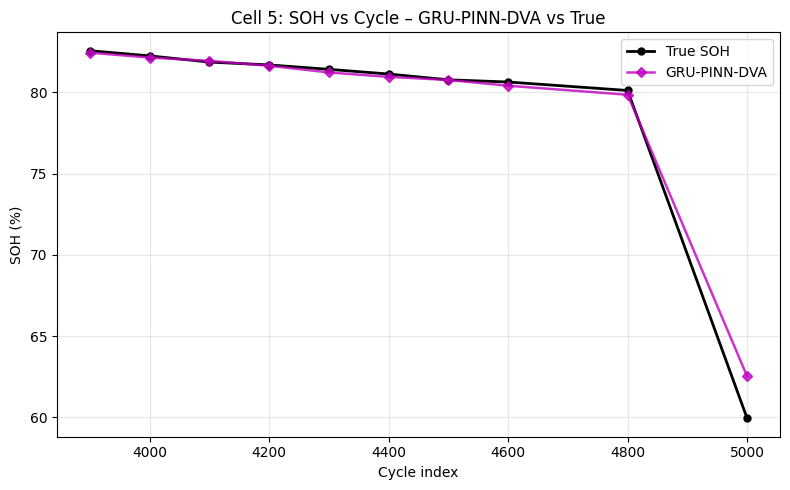


=== Cell 6: SOH vs Cycle (Test set) ===
LSTM           : MAE = 0.294 %, RMSE = 0.320 %
GRU            : MAE = 0.176 %, RMSE = 0.273 %
GRU-PINN-SCALAR: MAE = 0.301 %, RMSE = 0.356 %
GRU-PINN-DVA   : MAE = 0.254 %, RMSE = 0.286 %


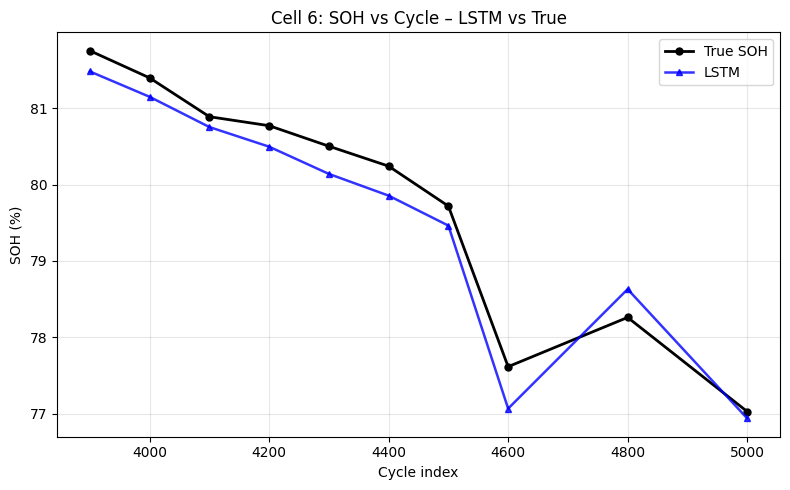

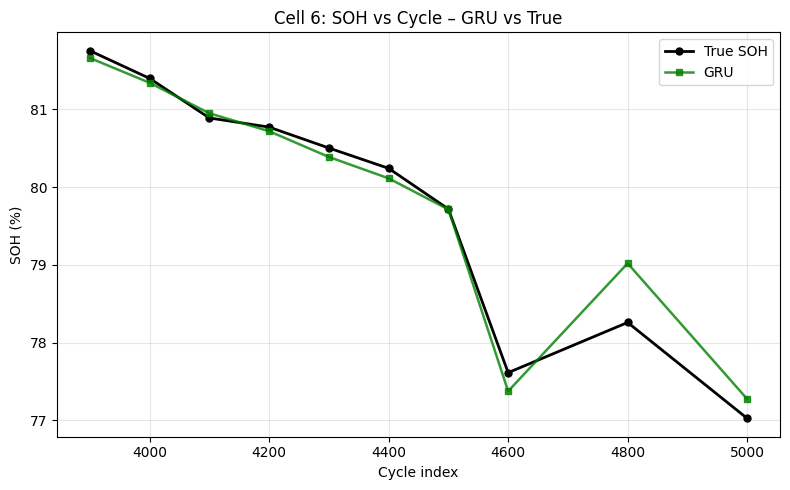

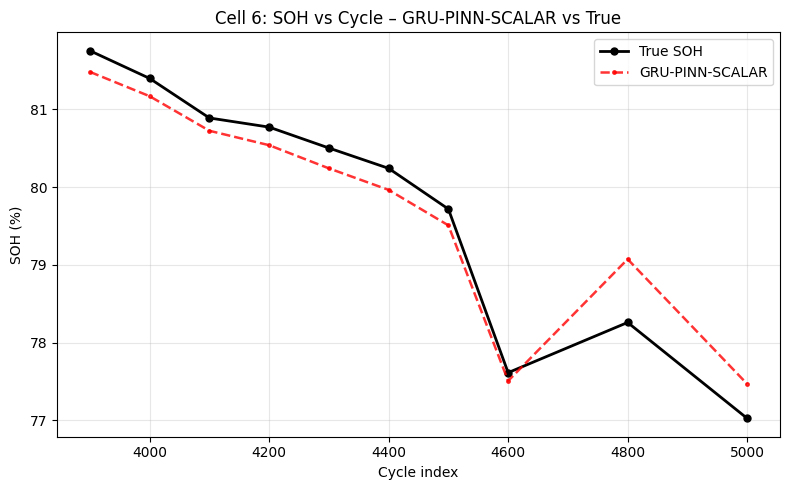

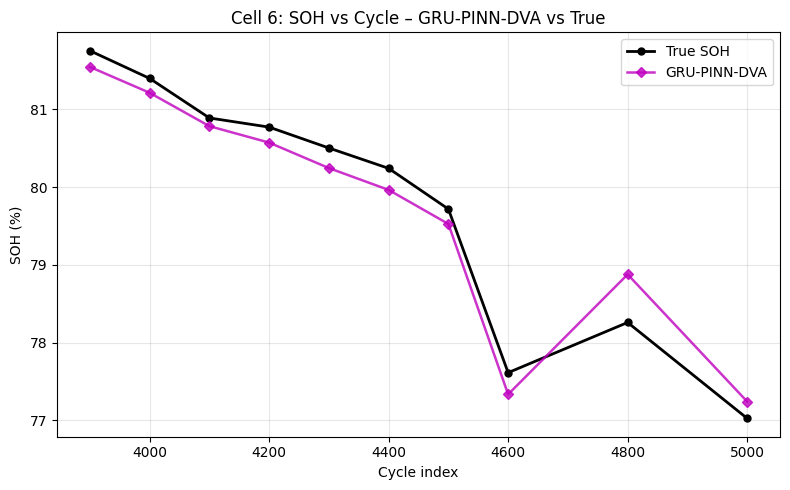


=== Cell 7: SOH vs Cycle (Test set) ===
LSTM           : MAE = 0.424 %, RMSE = 0.451 %
GRU            : MAE = 0.130 %, RMSE = 0.145 %
GRU-PINN-SCALAR: MAE = 0.089 %, RMSE = 0.117 %
GRU-PINN-DVA   : MAE = 0.163 %, RMSE = 0.185 %


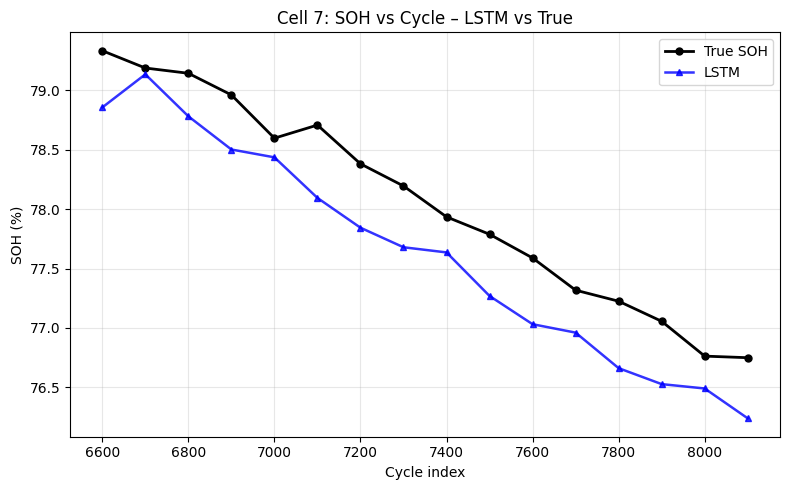

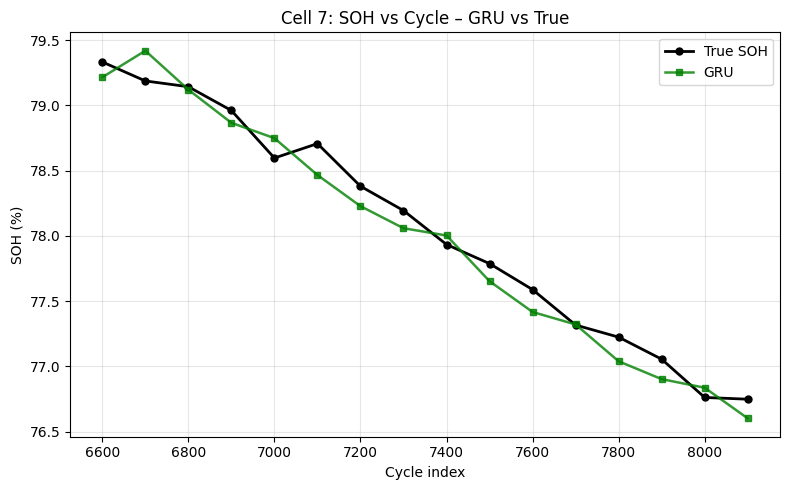

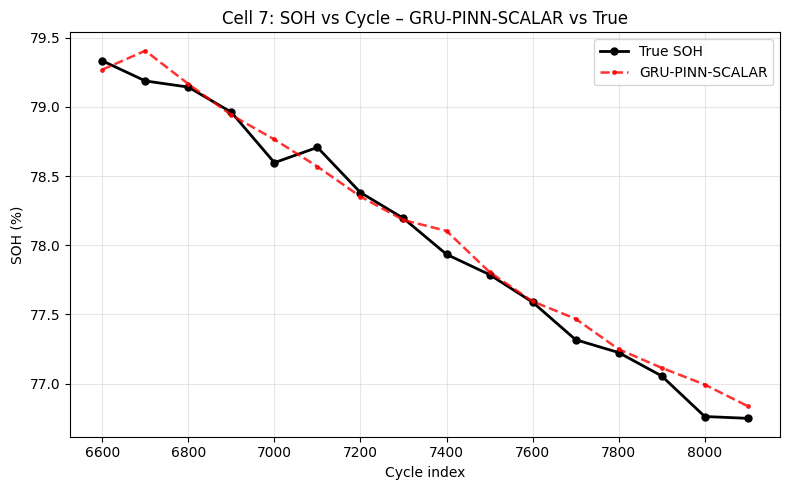

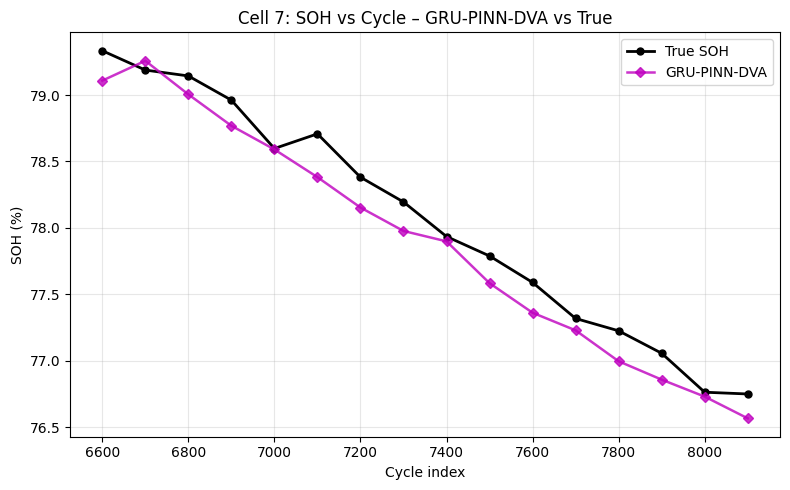


=== Cell 8: SOH vs Cycle (Test set) ===
LSTM           : MAE = 0.365 %, RMSE = 0.389 %
GRU            : MAE = 0.190 %, RMSE = 0.210 %
GRU-PINN-SCALAR: MAE = 0.165 %, RMSE = 0.207 %
GRU-PINN-DVA   : MAE = 0.226 %, RMSE = 0.236 %


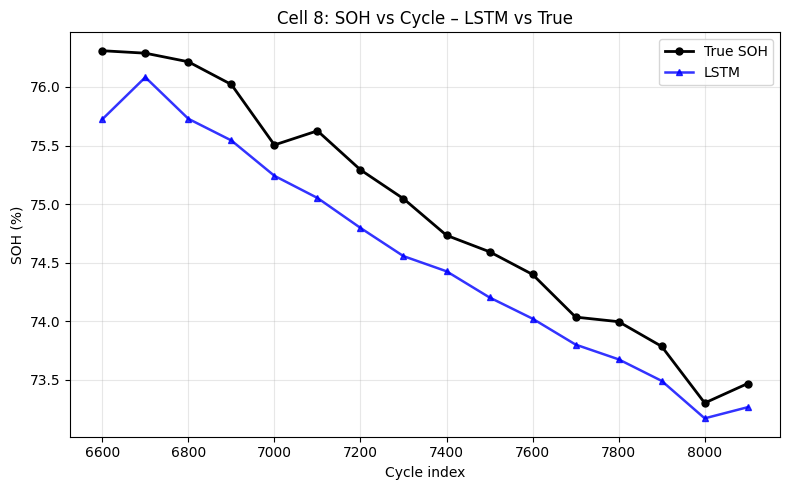

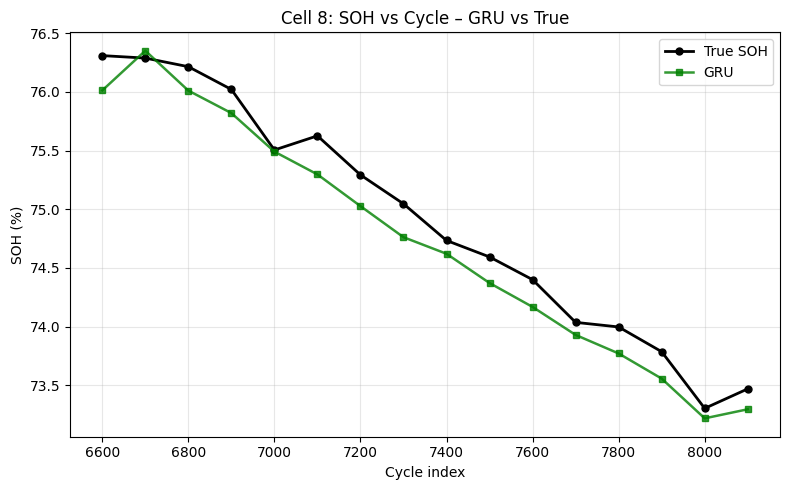

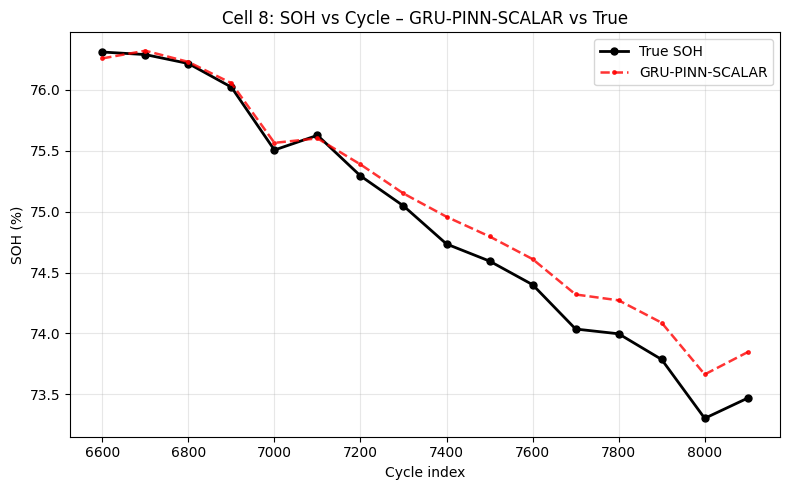

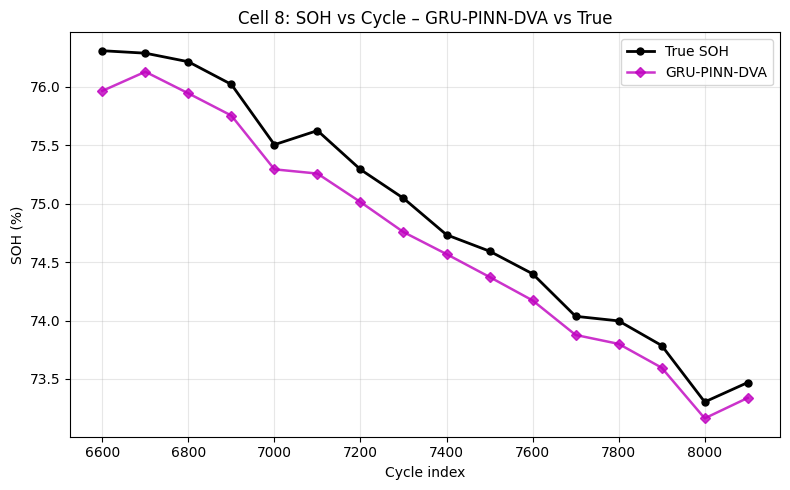


Done training + per-cell evaluation for all four models.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ============================================================
# 0. Config
# ============================================================

MAT_FILE = "Oxford_Battery_Degradation_Dataset_1.mat"
INIT_CAPACITY = 740.0          # mAh
SEQ_LEN = 128                  # resampled sequence length

VAL_SPLIT = 0.2                # per-cell split: 80% train, 20% test in each cell
BATCH_SIZE = 32

EPOCHS_LSTM = 200
EPOCHS_GRU  = 200
EPOCHS_PINN_SCALAR = 200
EPOCHS_PINN_DVA    = 200

LR = 1e-3

LAMBDA_PHYS_SCALAR = 1e-2      # weight for scalar-physics PINN
LAMBDA_PHYS_DVA    = 1e-3      # weight for full-DVA PINN (fine-tune)

# Model checkpoint paths
LSTM_CKPT        = "best_lstm_hf_vq_soh.pt"
GRU_CKPT         = "best_gru_hf_vq_soh.pt"
GRU_PINN_SCALAR_CKPT = "best_gru_pinn_scalar_dva_feat.pt"
GRU_PINN_DVA_CKPT    = "best_gru_pinn_dva_finetune.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

print("\nLoading .mat file...")
data = scipy.io.loadmat(MAT_FILE)
print("Keys:", data.keys())


# ============================================================
# 1. Helpers: HF1/HF2 & DVA & scalar DVA & feature extraction
# ============================================================

def compute_hf_features_for_cycle(cyc, init_capacity=740.0):
    """
    Given one cycle struct (from MATLAB), compute:
      HF1: charge time 3.8V -> 4.1V (C1ch)
      HF2: discharge time 4.1V -> 3.8V (C1dc)
      capacity: average of charge & discharge capacities if both valid

    Returns:
        HF1 (float or np.nan),
        HF2 (float or np.nan),
        capacity (float, 0 if invalid)
    """
    HF1 = np.nan
    HF2 = np.nan
    capacity_ch = 0.0
    capacity_dc = 0.0

    # ----- Charging phase: C1ch -> HF1 -----
    if "C1ch" in cyc.dtype.names:
        blk_ch = cyc["C1ch"][0, 0]
        if all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
            t_ch = blk_ch["t"][0, 0].ravel().astype(float)
            v_ch = blk_ch["v"][0, 0].ravel().astype(float)
            q_ch = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t_ch) > 10:
                try:
                    idx_3_8 = np.where(v_ch >= 3.8)[0]
                    idx_4_1 = np.where(v_ch >= 4.1)[0]
                    if len(idx_3_8) > 0 and len(idx_4_1) > 0:
                        t_start = t_ch[idx_3_8[0]]
                        t_end   = t_ch[idx_4_1[0]]
                        if t_end > t_start:
                            HF1 = t_end - t_start
                except Exception:
                    HF1 = np.nan

                capacity_ch = float(q_ch[-1] - q_ch[0])

    # ----- Discharging phase: C1dc -> HF2 -----
    if "C1dc" in cyc.dtype.names:
        blk_dc = cyc["C1dc"][0, 0]
        if all(k in blk_dc.dtype.names for k in ["t", "v", "q"]):
            t_dc = blk_dc["t"][0, 0].ravel().astype(float)
            v_dc = blk_dc["v"][0, 0].ravel().astype(float)
            q_dc = blk_dc["q"][0, 0].ravel().astype(float)

            if len(t_dc) > 10:
                try:
                    idx_4_1 = np.where(v_dc <= 4.1)[0]
                    idx_3_8 = np.where(v_dc <= 3.8)[0]
                    if len(idx_4_1) > 0 and len(idx_3_8) > 0:
                        t_start = t_dc[idx_4_1[0]]
                        t_end   = t_dc[idx_3_8[0]]
                        if t_end > t_start:
                            HF2 = t_end - t_start
                except Exception:
                    HF2 = np.nan

                capacity_dc = float(abs(q_dc[-1] - q_dc[0]))

    # ----- Capacity -----
    if capacity_ch > 0 and capacity_dc > 0:
        capacity = 0.5 * (capacity_ch + capacity_dc)
    elif capacity_ch > 0:
        capacity = capacity_ch
    elif capacity_dc > 0:
        capacity = capacity_dc
    else:
        capacity = 0.0

    return HF1, HF2, capacity


def compute_dva(v, q, dq_eps=1e-6, dq_thresh=1e-5, clip_val=100.0):
    """
    Compute DVA = dV/dQ for 1D arrays v, q (same length).
    Used for the GRU-PINN physics target.
    """
    v = np.asarray(v, dtype=float)
    q = np.asarray(q, dtype=float)

    dq = np.gradient(q)
    dv = np.gradient(v)

    dva = np.zeros_like(v, dtype=float)

    small = np.abs(dq) < dq_thresh
    safe_dq = dq.copy()
    safe_dq[small] = np.sign(dq[small]) * dq_eps + (dq[small] == 0) * dq_eps

    dva = dv / safe_dq
    dva[small] = 0.0

    if clip_val is not None:
        dva = np.clip(dva, -clip_val, clip_val)

    return dva


def compute_dva_scalar(v_new, q_new, dva, v_low=3.6, v_high=4.0):
    """
    Compute a scalar DVA feature over a voltage window:
      e.g. integral of |DVA| dQ between v_low and v_high.
    """
    v_new = np.asarray(v_new)
    q_new = np.asarray(q_new)
    dva   = np.asarray(dva)

    mask = (v_new >= v_low) & (v_new <= v_high)
    if mask.sum() < 3:
        # fallback: use whole range
        mask = np.ones_like(v_new, dtype=bool)

    q_win   = q_new[mask]
    dva_win = np.abs(dva[mask])

    # trapezoidal integration of |DVA| over Q
    s = np.trapz(dva_win, q_win)  # scalar
    return float(s)


def extract_sequences_with_hf_and_dva_scalar(data, L=128, init_capacity=740.0):
    """
    Extract:
      - X_seq: [L, 4] = [V, Q, HF1, HF2]
      - y_soh: [1] SOH fraction
      - dva:   [L, 1] DVA curve (for full DVA PINN)
      - dva_scalar: [1] scalar DVA feature (for scalar PINN)
      - cell_ids, cycles
    """
    X_list = []
    y_list = []
    dva_list = []
    dva_scalar_list = []
    cell_ids = []
    cycles = []

    print("\nExtracting sequences with HF1, HF2, V, Q, DVA, scalar DVA...")

    for cell_id in range(1, 9):
        cell_key = f"Cell{cell_id}"
        if cell_key not in data:
            print(f"  {cell_key} not found, skipping.")
            continue

        cell = data[cell_key]
        cyc_names = sorted(cell.dtype.names, key=lambda s: int(s[3:]))

        count = 0
        for cyc_name in cyc_names:
            cyc_idx = int(cyc_name[3:])
            cyc = cell[cyc_name][0, 0]

            HF1, HF2, capacity = compute_hf_features_for_cycle(cyc, init_capacity=init_capacity)
            if capacity <= 0 or np.isnan(HF1) or np.isnan(HF2):
                continue

            soh = capacity / float(init_capacity)

            # V, Q from C1ch
            if "C1ch" not in cyc.dtype.names:
                continue
            blk_ch = cyc["C1ch"][0, 0]
            if not all(k in blk_ch.dtype.names for k in ["t", "v", "q"]):
                continue

            t = blk_ch["t"][0, 0].ravel().astype(float)
            v = blk_ch["v"][0, 0].ravel().astype(float)
            q = blk_ch["q"][0, 0].ravel().astype(float)

            if len(t) < 5:
                continue

            # Resample
            t_new = np.linspace(t[0], t[-1], L)
            v_new = np.interp(t_new, t, v)
            q_new = np.interp(t_new, t, q)

            # DVA curve
            dva = compute_dva(v_new, q_new)  # [L]

            # Scalar DVA
            dva_scalar = compute_dva_scalar(v_new, q_new, dva)

            # Features [V, Q, HF1, HF2]
            HF1_arr = np.full_like(v_new, HF1, dtype=float)
            HF2_arr = np.full_like(v_new, HF2, dtype=float)
            X_seq = np.stack([v_new, q_new, HF1_arr, HF2_arr], axis=-1)  # [L, 4]

            X_list.append(X_seq)
            y_list.append(soh)
            dva_list.append(dva[:, None])
            dva_scalar_list.append(dva_scalar)
            cell_ids.append(cell_id)
            cycles.append(cyc_idx)
            count += 1

        print(f"  Cell {cell_id}: {count} valid cycles")

    X_arr = np.array(X_list, dtype=np.float32)                  # [N, L, 4]
    y_arr = np.array(y_list, dtype=np.float32)[:, None]         # [N, 1]
    dva_arr = np.array(dva_list, dtype=np.float32)              # [N, L, 1]
    dva_scalar_arr = np.array(dva_scalar_list, dtype=np.float32)[:, None]  # [N, 1]
    cell_ids_arr = np.array(cell_ids, dtype=np.int32)           # [N]
    cycles_arr = np.array(cycles, dtype=np.int32)               # [N]

    return X_arr, y_arr, dva_arr, dva_scalar_arr, cell_ids_arr, cycles_arr


# ============================================================
# 2. Build dataset & PER-CELL split
# ============================================================

X, y_soh, dva, dva_scalar, cell_ids, cycles = extract_sequences_with_hf_and_dva_scalar(
    data, L=SEQ_LEN, init_capacity=INIT_CAPACITY
)
print("\nShapes:")
print("  X:", X.shape)                 # [N, L, 4]
print("  y_soh:", y_soh.shape)         # [N, 1]
print("  dva:", dva.shape)             # [N, L, 1]
print("  dva_scalar:", dva_scalar.shape)  # [N, 1]

# ---- Per-cell split ----
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []
dva_train_list, dva_test_list = [], []
dva_scalar_train_list, dva_scalar_test_list = [], []
cell_ids_train_list, cell_ids_test_list = [], []
cycles_train_list, cycles_test_list = [], []

for cid in range(1, 9):
    cid_mask = (cell_ids == cid)
    if cid_mask.sum() == 0:
        continue

    X_c = X[cid_mask]
    y_c = y_soh[cid_mask]
    dva_c = dva[cid_mask]
    dva_scalar_c = dva_scalar[cid_mask]
    cyc_c = cycles[cid_mask]
    cell_c = cell_ids[cid_mask]

    # sort by cycle index for this cell
    order = np.argsort(cyc_c)
    X_c = X_c[order]
    y_c = y_c[order]
    dva_c = dva_c[order]
    dva_scalar_c = dva_scalar_c[order]
    cyc_c = cyc_c[order]
    cell_c = cell_c[order]

    N_c = len(X_c)
    n_train_c = int((1.0 - VAL_SPLIT) * N_c)
    if n_train_c < 1 or N_c - n_train_c < 1:
        # If too few samples, skip splitting this cell
        print(f"Cell {cid}: not enough samples ({N_c}) for split, putting all in train.")
        X_train_list.append(X_c)
        y_train_list.append(y_c)
        dva_train_list.append(dva_c)
        dva_scalar_train_list.append(dva_scalar_c)
        cell_ids_train_list.append(cell_c)
        cycles_train_list.append(cyc_c)
        continue

    X_train_c = X_c[:n_train_c]
    X_test_c  = X_c[n_train_c:]
    y_train_c = y_c[:n_train_c]
    y_test_c  = y_c[n_train_c:]
    dva_train_c = dva_c[:n_train_c]
    dva_test_c  = dva_c[n_train_c:]
    dva_scalar_train_c = dva_scalar_c[:n_train_c]
    dva_scalar_test_c  = dva_scalar_c[n_train_c:]
    cyc_train_c = cyc_c[:n_train_c]
    cyc_test_c  = cyc_c[n_train_c:]
    cell_train_c = cell_c[:n_train_c]
    cell_test_c  = cell_c[n_train_c:]

    X_train_list.append(X_train_c)
    X_test_list.append(X_test_c)
    y_train_list.append(y_train_c)
    y_test_list.append(y_test_c)
    dva_train_list.append(dva_train_c)
    dva_test_list.append(dva_test_c)
    dva_scalar_train_list.append(dva_scalar_train_c)
    dva_scalar_test_list.append(dva_scalar_test_c)
    cell_ids_train_list.append(cell_train_c)
    cell_ids_test_list.append(cell_test_c)
    cycles_train_list.append(cyc_train_c)
    cycles_test_list.append(cyc_test_c)

# Concatenate over cells
X_train = np.concatenate(X_train_list, axis=0)
X_test  = np.concatenate(X_test_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_test  = np.concatenate(y_test_list, axis=0)
dva_train = np.concatenate(dva_train_list, axis=0)
dva_test  = np.concatenate(dva_test_list, axis=0)
dva_scalar_train = np.concatenate(dva_scalar_train_list, axis=0)
dva_scalar_test  = np.concatenate(dva_scalar_test_list, axis=0)
cell_ids_train = np.concatenate(cell_ids_train_list, axis=0)
cell_ids_test  = np.concatenate(cell_ids_test_list, axis=0)
cycles_train   = np.concatenate(cycles_train_list, axis=0)
cycles_test    = np.concatenate(cycles_test_list, axis=0)

print(f"\nAfter per-cell split:")
print(f"  Train sequences: {len(X_train)}")
print(f"  Test sequences : {len(X_test)}")

# ---- Normalization ----

# Features: V, Q, HF1, HF2
flat_train = X_train.reshape(-1, X_train.shape[-1])  # [N*L, 4]
mu_feat = flat_train.mean(axis=0)
sd_feat = flat_train.std(axis=0) + 1e-8

X_train = (X_train - mu_feat) / sd_feat
X_test  = (X_test  - mu_feat) / sd_feat

# DVA curve (for full PINN)
flat_dva_train = dva_train.reshape(-1, dva_train.shape[-1])
mu_dva = flat_dva_train.mean(axis=0)
sd_dva = flat_dva_train.std(axis=0) + 1e-8

dva_train_norm = (dva_train - mu_dva) / sd_dva
dva_test_norm  = (dva_test  - mu_dva) / sd_dva

# Scalar DVA (for scalar PINN)
mu_dva_scalar = dva_scalar_train.mean(axis=0)
sd_dva_scalar = dva_scalar_train.std(axis=0) + 1e-8

dva_scalar_train_norm = (dva_scalar_train - mu_dva_scalar) / sd_dva_scalar
dva_scalar_test_norm  = (dva_scalar_test  - mu_dva_scalar) / sd_dva_scalar

# SOH stays as fraction [0,~1]
y_train_norm = y_train
y_test_norm  = y_test

# Torch datasets/loaders
train_dataset_basic = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train_norm, dtype=torch.float32),
)
test_dataset_basic = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_norm, dtype=torch.float32),
)

train_dataset_pinn_dva = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train_norm, dtype=torch.float32),
    torch.tensor(dva_train_norm, dtype=torch.float32),
)
test_dataset_pinn_dva = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_norm, dtype=torch.float32),
    torch.tensor(dva_test_norm, dtype=torch.float32),
)

train_dataset_pinn_scalar = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train_norm, dtype=torch.float32),
    torch.tensor(dva_scalar_train_norm, dtype=torch.float32),
)
test_dataset_pinn_scalar = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_norm, dtype=torch.float32),
    torch.tensor(dva_scalar_test_norm, dtype=torch.float32),
)

train_loader_basic = DataLoader(train_dataset_basic, batch_size=BATCH_SIZE, shuffle=True)
test_loader_basic  = DataLoader(test_dataset_basic,  batch_size=BATCH_SIZE, shuffle=False)

train_loader_pinn_dva   = DataLoader(train_dataset_pinn_dva,   batch_size=BATCH_SIZE, shuffle=True)
test_loader_pinn_dva    = DataLoader(test_dataset_pinn_dva,    batch_size=BATCH_SIZE, shuffle=False)

train_loader_pinn_scalar = DataLoader(train_dataset_pinn_scalar, batch_size=BATCH_SIZE, shuffle=True)
test_loader_pinn_scalar  = DataLoader(test_dataset_pinn_scalar,  batch_size=BATCH_SIZE, shuffle=False)


# ============================================================
# 3. Model classes
# ============================================================

class LSTM_HF_VQ_SOH(nn.Module):
    """LSTM model: [B, L, 4] -> [B, 1]"""
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        soh = self.fc(last)
        return soh


class GRU_HF_VQ_SOH(nn.Module):
    """GRU model: [B, L, 4] -> [B, 1]"""
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        soh = self.fc(last)
        return soh


class GRU_PINN_SCALAR(nn.Module):
    """
    GRU-PINN with scalar physics target:
      Input:  [B, L, 4]
      Output: soh_pred [B, 1], dva_scalar_pred [B, 1]
    """
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc_soh = nn.Linear(hidden, 1)
        self.fc_phys = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.gru(x)        # [B, L, H]
        last = out[:, -1, :]        # [B, H]
        soh = self.fc_soh(last)     # [B, 1]
        dva_scalar_pred = self.fc_phys(last)  # [B, 1]
        return soh, dva_scalar_pred


class GRU_PINN_SOH_DVA(nn.Module):
    """
    GRU-PINN (full DVA):
      Input:  [B, L, 4]
      Output: soh_pred [B, 1], dva_pred [B, L, 1]
    """
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc_soh = nn.Linear(hidden, 1)
        self.fc_dva = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.gru(x)        # [B, L, H]
        last = out[:, -1, :]        # [B, H]
        soh = self.fc_soh(last)     # [B, 1]
        dva_pred = self.fc_dva(out) # [B, L, 1]
        return soh, dva_pred


# ============================================================
# 4. Train LSTM
# ============================================================

print("\n======================")
print("Training LSTM model...")
print("======================")

lstm_model = LSTM_HF_VQ_SOH(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

best_loss_lstm = float("inf")

for epoch in range(1, EPOCHS_LSTM + 1):
    lstm_model.train()
    train_loss = 0.0
    for xb, yb in train_loader_basic:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = lstm_model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader_basic.dataset)

    # Validate
    lstm_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader_basic:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = lstm_model(xb)
            test_loss += loss_fn(pred, yb).item() * xb.size(0)
    test_loss /= len(test_loader_basic.dataset)

    if test_loss < best_loss_lstm:
        best_loss_lstm = test_loss
        torch.save(lstm_model.state_dict(), LSTM_CKPT)

    if epoch == 1 or epoch % 20 == 0 or epoch == EPOCHS_LSTM:
        print(f"[LSTM] Epoch {epoch:03d} | Train Loss: {train_loss:.6e} | Test Loss: {test_loss:.6e}")

print("Best LSTM Test Loss:", best_loss_lstm)


# ============================================================
# 5. Train GRU (baseline)
# ============================================================

print("\n=====================")
print("Training GRU model...")
print("=====================")

gru_model = GRU_HF_VQ_SOH(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

best_loss_gru = float("inf")

for epoch in range(1, EPOCHS_GRU + 1):
    gru_model.train()
    train_loss = 0.0
    for xb, yb in train_loader_basic:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = gru_model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader_basic.dataset)

    # Validate
    gru_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader_basic:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = gru_model(xb)
            test_loss += loss_fn(pred, yb).item() * xb.size(0)
    test_loss /= len(test_loader_basic.dataset)

    if test_loss < best_loss_gru:
        best_loss_gru = test_loss
        torch.save(gru_model.state_dict(), GRU_CKPT)

    if epoch == 1 or epoch % 20 == 0 or epoch == EPOCHS_GRU:
        print(f"[GRU ] Epoch {epoch:03d} | Train Loss: {train_loss:.6e} | Test Loss: {test_loss:.6e}")

print("Best GRU Test Loss:", best_loss_gru)


# ============================================================
# 6. Train GRU-PINN-SCALAR
# ============================================================

print("\n==============================")
print("Training GRU-PINN-SCALAR model")
print("==============================")

pinn_scalar_model = GRU_PINN_SCALAR(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(pinn_scalar_model.parameters(), lr=LR)
mse_loss = nn.MSELoss()

best_loss_scalar = float("inf")

for epoch in range(1, EPOCHS_PINN_SCALAR + 1):
    pinn_scalar_model.train()
    train_total = 0.0
    train_data  = 0.0
    train_phys  = 0.0

    for xb, yb, s_phys in train_loader_pinn_scalar:
        xb = xb.to(device)
        yb = yb.to(device)
        s_phys = s_phys.to(device)

        optimizer.zero_grad()
        soh_pred, s_pred = pinn_scalar_model(xb)

        loss_data = mse_loss(soh_pred, yb)
        loss_phys = mse_loss(s_pred, s_phys)
        loss = loss_data + LAMBDA_PHYS_SCALAR * loss_phys

        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        train_total += loss.item() * bs
        train_data  += loss_data.item() * bs
        train_phys  += loss_phys.item() * bs

    train_total /= len(train_loader_pinn_scalar.dataset)
    train_data  /= len(train_loader_pinn_scalar.dataset)
    train_phys  /= len(train_loader_pinn_scalar.dataset)

    # Validation
    pinn_scalar_model.eval()
    test_total = 0.0
    test_data  = 0.0
    test_phys  = 0.0

    with torch.no_grad():
        for xb, yb, s_phys in test_loader_pinn_scalar:
            xb = xb.to(device)
            yb = yb.to(device)
            s_phys = s_phys.to(device)

            soh_pred, s_pred = pinn_scalar_model(xb)
            loss_data = mse_loss(soh_pred, yb)
            loss_phys = mse_loss(s_pred, s_phys)
            loss = loss_data + LAMBDA_PHYS_SCALAR * loss_phys

            bs = xb.size(0)
            test_total += loss.item() * bs
            test_data  += loss_data.item() * bs
            test_phys  += loss_phys.item() * bs

    test_total /= len(test_loader_pinn_scalar.dataset)
    test_data  /= len(test_loader_pinn_scalar.dataset)
    test_phys  /= len(test_loader_pinn_scalar.dataset)

    if test_total < best_loss_scalar:
        best_loss_scalar = test_total
        torch.save(pinn_scalar_model.state_dict(), GRU_PINN_SCALAR_CKPT)

    if epoch == 1 or epoch % 20 == 0 or epoch == EPOCHS_PINN_SCALAR:
        print(
            f"[PINN-S] Epoch {epoch:03d} | "
            f"TrainTot: {train_total:.3e} (Data: {train_data:.3e}, Phys: {train_phys:.3e}) | "
            f"TestTot:  {test_total:.3e} (Data: {test_data:.3e}, Phys: {test_phys:.3e})"
        )

print("Best GRU-PINN-SCALAR Test Total Loss:", best_loss_scalar)


# ============================================================
# 7. Fine-tune GRU-PINN (full DVA) from GRU
# ============================================================

print("\n==============================")
print("Fine-tuning GRU-PINN (full DVA)")
print("==============================")

# Reload best GRU as baseline
gru_model = GRU_HF_VQ_SOH(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
gru_model.load_state_dict(torch.load(GRU_CKPT, map_location=device))

# Initialize GRU-PINN-DVA from GRU
pinn_dva_model = GRU_PINN_SOH_DVA(input_dim=4, hidden=128, layers=2, dropout=0.2).to(device)
pinn_dva_model.gru.load_state_dict(gru_model.gru.state_dict())
pinn_dva_model.fc_soh.load_state_dict(gru_model.fc.state_dict())  # copy SOH head

optimizer = torch.optim.Adam(pinn_dva_model.parameters(), lr=LR)
mse_loss = nn.MSELoss()

best_loss_dva = float("inf")

for epoch in range(1, EPOCHS_PINN_DVA + 1):
    pinn_dva_model.train()
    train_total = 0.0
    train_data  = 0.0
    train_phys  = 0.0

    for xb, yb, dva_b in train_loader_pinn_dva:
        xb = xb.to(device)
        yb = yb.to(device)
        dva_b = dva_b.to(device)

        optimizer.zero_grad()
        soh_pred, dva_pred = pinn_dva_model(xb)

        loss_data = mse_loss(soh_pred, yb)
        loss_phys = mse_loss(dva_pred, dva_b)

        L = dva_b.shape[1]  # sequence length
        loss_phys_scaled = loss_phys / L

        loss = loss_data + LAMBDA_PHYS_DVA * loss_phys_scaled

        loss.backward()
        optimizer.step()

        bs = xb.size(0)
        train_total += loss.item() * bs
        train_data  += loss_data.item() * bs
        train_phys  += loss_phys_scaled.item() * bs

    train_total /= len(train_loader_pinn_dva.dataset)
    train_data  /= len(train_loader_pinn_dva.dataset)
    train_phys  /= len(train_loader_pinn_dva.dataset)

    # Validation
    pinn_dva_model.eval()
    test_total = 0.0
    test_data  = 0.0
    test_phys  = 0.0

    with torch.no_grad():
        for xb, yb, dva_b in test_loader_pinn_dva:
            xb = xb.to(device)
            yb = yb.to(device)
            dva_b = dva_b.to(device)

            soh_pred, dva_pred = pinn_dva_model(xb)
            loss_data = mse_loss(soh_pred, yb)
            loss_phys = mse_loss(dva_pred, dva_b)
            L = dva_b.shape[1]
            loss_phys_scaled = loss_phys / L

            loss = loss_data + LAMBDA_PHYS_DVA * loss_phys_scaled

            bs = xb.size(0)
            test_total += loss.item() * bs
            test_data  += loss_data.item() * bs
            test_phys  += loss_phys_scaled.item() * bs

    test_total /= len(test_loader_pinn_dva.dataset)
    test_data  /= len(test_loader_pinn_dva.dataset)
    test_phys  /= len(test_loader_pinn_dva.dataset)

    if test_total < best_loss_dva:
        best_loss_dva = test_total
        torch.save(pinn_dva_model.state_dict(), GRU_PINN_DVA_CKPT)

    if epoch == 1 or epoch % 20 == 0 or epoch == EPOCHS_PINN_DVA:
        print(
            f"[PINN-D] Epoch {epoch:03d} | "
            f"TrainTot: {train_total:.3e} (Data: {train_data:.3e}, Phys: {train_phys:.3e}) | "
            f"TestTot:  {test_total:.3e} (Data: {test_data:.3e}, Phys: {test_phys:.3e})"
        )

print("Best GRU-PINN-DVA (finetune) Test Total Loss:", best_loss_dva)


# ============================================================
# 8. Reload best models & run predictions on test set
# ============================================================

lstm_model.load_state_dict(torch.load(LSTM_CKPT, map_location=device))
gru_model.load_state_dict(torch.load(GRU_CKPT, map_location=device))
pinn_scalar_model.load_state_dict(torch.load(GRU_PINN_SCALAR_CKPT, map_location=device))
pinn_dva_model.load_state_dict(torch.load(GRU_PINN_DVA_CKPT, map_location=device))

lstm_model.eval()
gru_model.eval()
pinn_scalar_model.eval()
pinn_dva_model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    soh_lstm = lstm_model(X_test_tensor).cpu().numpy().flatten()
    soh_gru  = gru_model(X_test_tensor).cpu().numpy().flatten()
    soh_pinn_scalar, _ = pinn_scalar_model(X_test_tensor)
    soh_pinn_scalar = soh_pinn_scalar.cpu().numpy().flatten()
    soh_pinn_dva, _ = pinn_dva_model(X_test_tensor)
    soh_pinn_dva = soh_pinn_dva.cpu().numpy().flatten()

soh_true = y_test_norm.flatten()

soh_true_pct        = soh_true * 100.0
soh_lstm_pct        = soh_lstm * 100.0
soh_gru_pct         = soh_gru  * 100.0
soh_pinn_scalar_pct = soh_pinn_scalar * 100.0
soh_pinn_dva_pct    = soh_pinn_dva * 100.0


# ============================================================
# 9. Per-cell evaluation & SEPARATE plots
# ============================================================

def evaluate_cell_curve(cell_to_plot):
    """
    For a given cell_id (1..8), use the per-cell test samples,
    and plot, in SEPARATE figures:
      - True SOH vs cycle + LSTM
      - True SOH vs cycle + GRU
      - True SOH vs cycle + GRU-PINN-SCALAR
      - True SOH vs cycle + GRU-PINN-DVA
    Also print MAE/RMSE for each model on that cell.
    """
    mask = (cell_ids_test == cell_to_plot)
    if mask.sum() == 0:
        print(f"\n[Cell {cell_to_plot}] No test samples (all used for train).")
        return

    cyc_cell   = cycles_test[mask]
    true_cell  = soh_true_pct[mask]
    lstm_cell  = soh_lstm_pct[mask]
    gru_cell   = soh_gru_pct[mask]
    pinn_s_cell = soh_pinn_scalar_pct[mask]
    pinn_d_cell = soh_pinn_dva_pct[mask]

    # Sort by cycle number
    order = np.argsort(cyc_cell)
    cyc_cell   = cyc_cell[order]
    true_cell  = true_cell[order]
    lstm_cell  = lstm_cell[order]
    gru_cell   = gru_cell[order]
    pinn_s_cell = pinn_s_cell[order]
    pinn_d_cell = pinn_d_cell[order]

    # Metrics per model on this cell
    def mae_rmse(pred, true):
        mae = np.mean(np.abs(pred - true))
        rmse = np.sqrt(np.mean((pred - true)**2))
        return mae, rmse

    mae_lstm, rmse_lstm = mae_rmse(lstm_cell, true_cell)
    mae_gru,  rmse_gru  = mae_rmse(gru_cell,  true_cell)
    mae_pins, rmse_pins = mae_rmse(pinn_s_cell, true_cell)
    mae_pind, rmse_pind = mae_rmse(pinn_d_cell, true_cell)

    print(f"\n=== Cell {cell_to_plot}: SOH vs Cycle (Test set) ===")
    print(f"LSTM           : MAE = {mae_lstm:.3f} %, RMSE = {rmse_lstm:.3f} %")
    print(f"GRU            : MAE = {mae_gru:.3f} %, RMSE = {rmse_gru:.3f} %")
    print(f"GRU-PINN-SCALAR: MAE = {mae_pins:.3f} %, RMSE = {rmse_pins:.3f} %")
    print(f"GRU-PINN-DVA   : MAE = {mae_pind:.3f} %, RMSE = {rmse_pind:.3f} %")

    # ---------- Plot 1: True vs LSTM ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, lstm_cell, "b^-", label="LSTM", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – LSTM vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Plot 2: True vs GRU ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, gru_cell,  "gs-", label="GRU", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – GRU vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Plot 3: True vs GRU-PINN-SCALAR ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, pinn_s_cell, "r.--", label="GRU-PINN-SCALAR", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – GRU-PINN-SCALAR vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- Plot 4: True vs GRU-PINN-DVA ----------
    plt.figure(figsize=(8, 5))
    plt.plot(cyc_cell, true_cell, "ko-", label="True SOH", linewidth=2, markersize=5)
    plt.plot(cyc_cell, pinn_d_cell, "mD-", label="GRU-PINN-DVA", linewidth=1.8, markersize=5, alpha=0.8)
    plt.xlabel("Cycle index")
    plt.ylabel("SOH (%)")
    plt.title(f"Cell {cell_to_plot}: SOH vs Cycle – GRU-PINN-DVA vs True")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 10. Run per-cell evaluation for ALL cells
# ============================================================

for cid in range(1, 9):
    evaluate_cell_curve(cid)

print("\nDone training + per-cell evaluation for all four models.")



SENSOR NOISE ROBUSTNESS TESTING

Testing LSTM robustness to noise...

Testing GRU robustness to noise...

Testing GRU-PINN-SCALAR robustness to noise...

Testing GRU-PINN-DVA robustness to noise...

NOISE ROBUSTNESS SUMMARY

LSTM:
Noise Level     MAE (mean±std)            RMSE (mean±std)          
-----------------------------------------------------------------
0.000              0.325 ± 0.000       0.578 ± 0.000   
0.010              0.328 ± 0.006       0.581 ± 0.003   
0.050              0.407 ± 0.016       0.654 ± 0.011   
0.100              0.582 ± 0.028       0.803 ± 0.036   
0.150              0.790 ± 0.056       1.041 ± 0.046   
0.200              1.054 ± 0.079       1.346 ± 0.100   
0.300              1.488 ± 0.113       1.850 ± 0.125   

GRU:
Noise Level     MAE (mean±std)            RMSE (mean±std)          
-----------------------------------------------------------------
0.000              0.157 ± 0.000       0.196 ± 0.000   
0.010              0.162 ± 0.004       0.203 ±

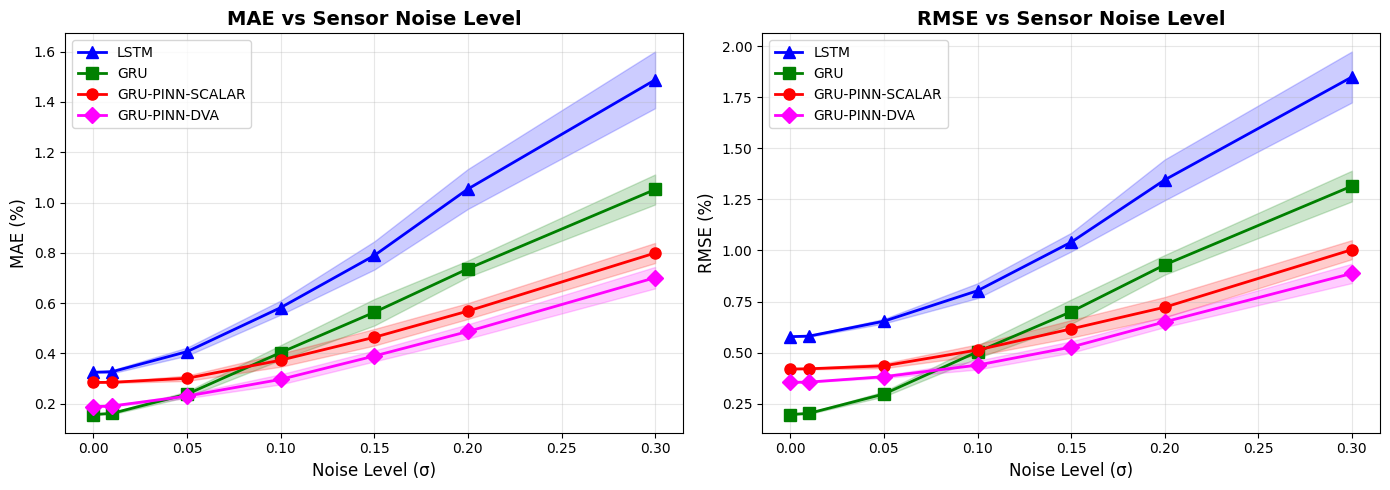

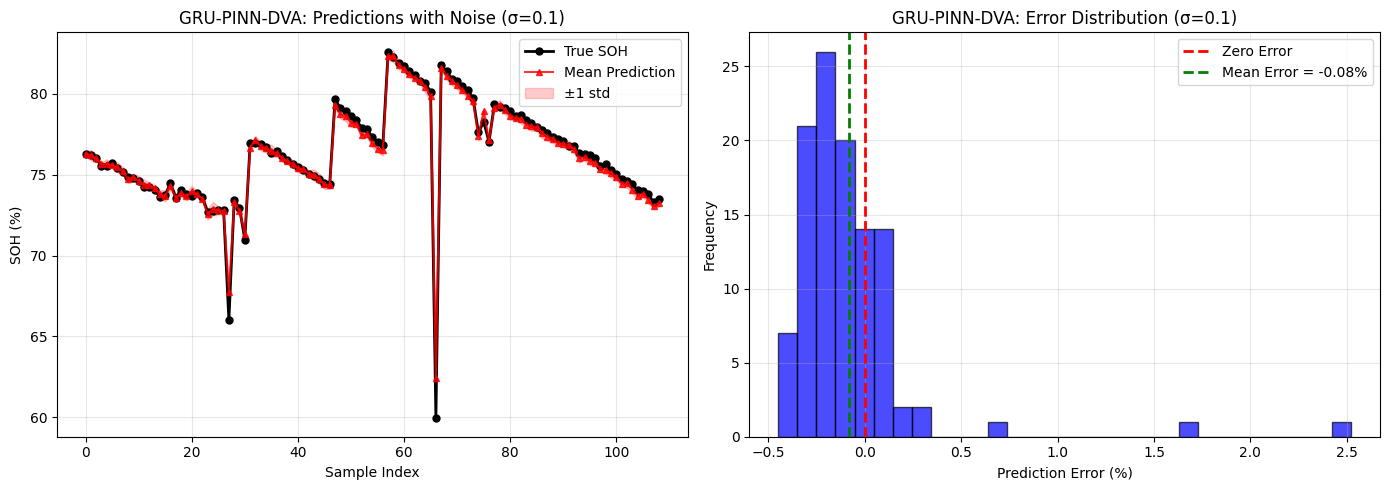


FEATURE-SPECIFIC SENSITIVITY ANALYSIS (GRU-PINN-DVA)

Testing sensitivity to noise in: V (Voltage)

Testing sensitivity to noise in: Q (Capacity)

Testing sensitivity to noise in: HF1 (Time)

Testing sensitivity to noise in: HF2 (Time)


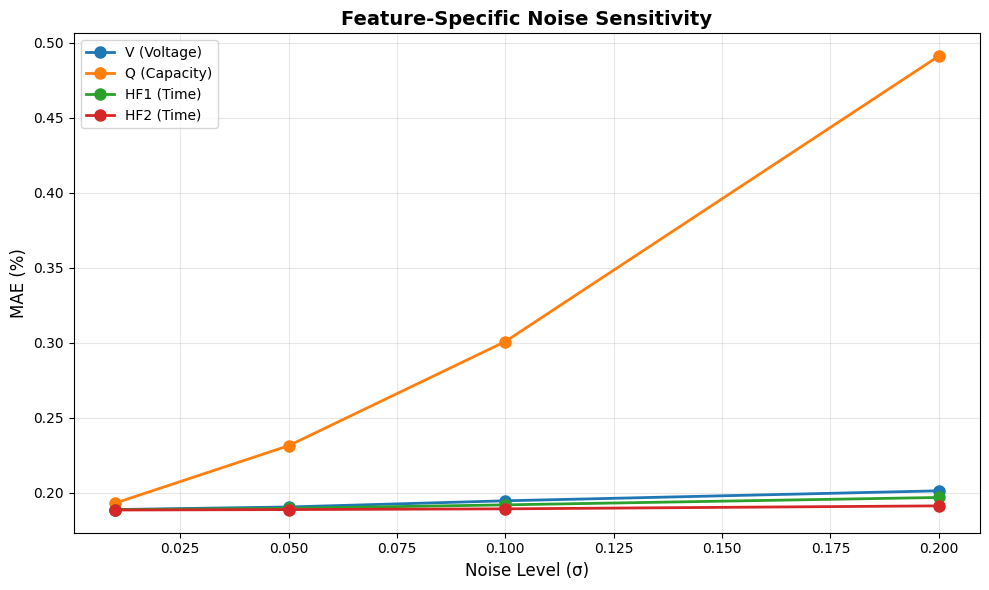


Noise robustness testing completed!


In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ============================================================
# Sensor Noise Robustness Testing
# ============================================================

def add_sensor_noise(X, noise_level, noise_type='gaussian'):
    """
    Add sensor noise to input features.
    
    Args:
        X: Input array [N, L, 4] where features are [V, Q, HF1, HF2]
        noise_level: Standard deviation for gaussian or percentage for uniform
        noise_type: 'gaussian' or 'uniform'
    
    Returns:
        X_noisy: Noisy version of X
    """
    X_noisy = X.copy()
    
    if noise_type == 'gaussian':
        # Add Gaussian noise with zero mean and std=noise_level
        noise = np.random.normal(0, noise_level, X.shape)
        X_noisy = X + noise
        
    elif noise_type == 'uniform':
        # Add uniform noise in range [-noise_level, +noise_level]
        noise = np.random.uniform(-noise_level, noise_level, X.shape)
        X_noisy = X + noise
        
    return X_noisy


def add_feature_specific_noise(X, noise_levels_dict, noise_type='gaussian'):
    """
    Add different noise levels to different features.
    
    Args:
        X: Input array [N, L, 4] where features are [V, Q, HF1, HF2]
        noise_levels_dict: Dictionary with keys 'V', 'Q', 'HF1', 'HF2' and noise levels
        noise_type: 'gaussian' or 'uniform'
    
    Returns:
        X_noisy: Noisy version of X
    """
    X_noisy = X.copy()
    feature_names = ['V', 'Q', 'HF1', 'HF2']
    
    for idx, feat_name in enumerate(feature_names):
        if feat_name in noise_levels_dict:
            noise_level = noise_levels_dict[feat_name]
            
            if noise_type == 'gaussian':
                noise = np.random.normal(0, noise_level, X_noisy[:, :, idx].shape)
            elif noise_type == 'uniform':
                noise = np.random.uniform(-noise_level, noise_level, X_noisy[:, :, idx].shape)
            
            X_noisy[:, :, idx] += noise
    
    return X_noisy


def evaluate_model_with_noise(model, X_test, y_test, noise_levels, 
                               device, model_type='gru', num_trials=10):
    """
    Evaluate model performance across different noise levels.
    
    Args:
        model: Trained PyTorch model
        X_test: Test input [N, L, 4]
        y_test: Test labels [N, 1]
        noise_levels: List of noise standard deviations to test
        device: torch device
        model_type: 'gru', 'lstm', 'pinn_scalar', or 'pinn_dva'
        num_trials: Number of noise realizations per noise level
    
    Returns:
        results: Dictionary with MAE and RMSE for each noise level
    """
    model.eval()
    results = {
        'noise_levels': noise_levels,
        'mae_mean': [],
        'mae_std': [],
        'rmse_mean': [],
        'rmse_std': [],
        'predictions': []  # Store predictions for detailed analysis
    }
    
    for noise_level in noise_levels:
        mae_trials = []
        rmse_trials = []
        preds_trials = []
        
        for trial in range(num_trials):
            # Add noise to test data
            X_noisy = add_sensor_noise(X_test, noise_level, noise_type='gaussian')
            X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32).to(device)
            
            # Get predictions
            with torch.no_grad():
                if model_type in ['pinn_scalar', 'pinn_dva']:
                    soh_pred, _ = model(X_noisy_tensor)
                else:
                    soh_pred = model(X_noisy_tensor)
                
                soh_pred = soh_pred.cpu().numpy().flatten()
            
            # Calculate metrics (convert to percentage)
            y_true_pct = y_test.flatten() * 100.0
            soh_pred_pct = soh_pred * 100.0
            
            mae = mean_absolute_error(y_true_pct, soh_pred_pct)
            rmse = np.sqrt(mean_squared_error(y_true_pct, soh_pred_pct))
            
            mae_trials.append(mae)
            rmse_trials.append(rmse)
            preds_trials.append(soh_pred_pct)
        
        results['mae_mean'].append(np.mean(mae_trials))
        results['mae_std'].append(np.std(mae_trials))
        results['rmse_mean'].append(np.mean(rmse_trials))
        results['rmse_std'].append(np.std(rmse_trials))
        results['predictions'].append(preds_trials)
    
    return results


def plot_noise_robustness(results_dict, save_path=None):
    """
    Plot model performance vs noise level for multiple models.
    
    Args:
        results_dict: Dictionary with model names as keys and results as values
        save_path: Optional path to save the figure
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = {'LSTM': 'blue', 'GRU': 'green', 
              'GRU-PINN-SCALAR': 'red', 'GRU-PINN-DVA': 'magenta'}
    markers = {'LSTM': '^', 'GRU': 's', 
               'GRU-PINN-SCALAR': 'o', 'GRU-PINN-DVA': 'D'}
    
    for model_name, results in results_dict.items():
        noise_levels = results['noise_levels']
        mae_mean = results['mae_mean']
        mae_std = results['mae_std']
        rmse_mean = results['rmse_mean']
        rmse_std = results['rmse_std']
        
        color = colors.get(model_name, 'black')
        marker = markers.get(model_name, 'o')
        
        # MAE plot
        ax1.plot(noise_levels, mae_mean, marker=marker, color=color, 
                label=model_name, linewidth=2, markersize=8)
        ax1.fill_between(noise_levels, 
                         np.array(mae_mean) - np.array(mae_std),
                         np.array(mae_mean) + np.array(mae_std),
                         color=color, alpha=0.2)
        
        # RMSE plot
        ax2.plot(noise_levels, rmse_mean, marker=marker, color=color, 
                label=model_name, linewidth=2, markersize=8)
        ax2.fill_between(noise_levels,
                         np.array(rmse_mean) - np.array(rmse_std),
                         np.array(rmse_mean) + np.array(rmse_std),
                         color=color, alpha=0.2)
    
    ax1.set_xlabel('Noise Level (σ)', fontsize=12)
    ax1.set_ylabel('MAE (%)', fontsize=12)
    ax1.set_title('MAE vs Sensor Noise Level', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    ax2.set_xlabel('Noise Level (σ)', fontsize=12)
    ax2.set_ylabel('RMSE (%)', fontsize=12)
    ax2.set_title('RMSE vs Sensor Noise Level', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_prediction_distribution(results, y_test, noise_level_idx=0, 
                                  model_name='GRU-PINN', save_path=None):
    """
    Plot distribution of predictions across noise trials for a specific noise level.
    
    Args:
        results: Results dictionary from evaluate_model_with_noise
        y_test: True labels
        noise_level_idx: Index of noise level to visualize
        model_name: Name of the model for plot title
        save_path: Optional path to save the figure
    """
    noise_level = results['noise_levels'][noise_level_idx]
    predictions = np.array(results['predictions'][noise_level_idx])  # [num_trials, N]
    y_true_pct = y_test.flatten() * 100.0
    
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Predictions with uncertainty bands
    indices = np.arange(len(y_true_pct))
    ax1.plot(indices, y_true_pct, 'ko-', label='True SOH', linewidth=2, markersize=5)
    ax1.plot(indices, mean_pred, 'r^-', label='Mean Prediction', 
             linewidth=1.5, markersize=4, alpha=0.8)
    ax1.fill_between(indices, mean_pred - std_pred, mean_pred + std_pred,
                     color='red', alpha=0.2, label='±1 std')
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('SOH (%)')
    ax1.set_title(f'{model_name}: Predictions with Noise (σ={noise_level})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Error distribution
    errors = mean_pred - y_true_pct
    ax2.hist(errors, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax2.axvline(errors.mean(), color='green', linestyle='--', linewidth=2, 
                label=f'Mean Error = {errors.mean():.2f}%')
    ax2.set_xlabel('Prediction Error (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{model_name}: Error Distribution (σ={noise_level})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def compare_feature_sensitivity(model, X_test, y_test, device, 
                                 model_type='pinn_dva', num_trials=5):
    """
    Test sensitivity to noise in individual features.
    
    Args:
        model: Trained model
        X_test: Test input
        y_test: Test labels
        device: torch device
        model_type: Type of model
        num_trials: Number of trials per configuration
    
    Returns:
        sensitivity_results: Dictionary with results per feature
    """
    feature_names = ['V (Voltage)', 'Q (Capacity)', 'HF1 (Time)', 'HF2 (Time)']
    noise_levels = [0.01, 0.05, 0.1, 0.2]
    
    sensitivity_results = {}
    
    for feat_idx, feat_name in enumerate(feature_names):
        print(f"\nTesting sensitivity to noise in: {feat_name}")
        mae_list = []
        
        for noise_level in noise_levels:
            mae_trials = []
            
            for trial in range(num_trials):
                X_noisy = X_test.copy()
                noise = np.random.normal(0, noise_level, X_noisy[:, :, feat_idx].shape)
                X_noisy[:, :, feat_idx] += noise
                
                X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32).to(device)
                
                with torch.no_grad():
                    if model_type in ['pinn_scalar', 'pinn_dva']:
                        soh_pred, _ = model(X_noisy_tensor)
                    else:
                        soh_pred = model(X_noisy_tensor)
                    
                    soh_pred = soh_pred.cpu().numpy().flatten()
                
                y_true_pct = y_test.flatten() * 100.0
                soh_pred_pct = soh_pred * 100.0
                mae = mean_absolute_error(y_true_pct, soh_pred_pct)
                mae_trials.append(mae)
            
            mae_list.append(np.mean(mae_trials))
        
        sensitivity_results[feat_name] = {
            'noise_levels': noise_levels,
            'mae': mae_list
        }
    
    # Plot feature sensitivity
    plt.figure(figsize=(10, 6))
    for feat_name, results in sensitivity_results.items():
        plt.plot(results['noise_levels'], results['mae'], 
                marker='o', label=feat_name, linewidth=2, markersize=8)
    
    plt.xlabel('Noise Level (σ)', fontsize=12)
    plt.ylabel('MAE (%)', fontsize=12)
    plt.title('Feature-Specific Noise Sensitivity', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return sensitivity_results


# ============================================================
# Main Execution: Test All Models
# ============================================================

print("\n" + "="*60)
print("SENSOR NOISE ROBUSTNESS TESTING")
print("="*60)

# Define noise levels to test
noise_levels = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
num_trials = 10  # Number of noise realizations per level

# Store results for all models
all_results = {}

# Test LSTM
print("\nTesting LSTM robustness to noise...")
lstm_results = evaluate_model_with_noise(
    lstm_model, X_test, y_test_norm, noise_levels, 
    device, model_type='lstm', num_trials=num_trials
)
all_results['LSTM'] = lstm_results

# Test GRU
print("\nTesting GRU robustness to noise...")
gru_results = evaluate_model_with_noise(
    gru_model, X_test, y_test_norm, noise_levels,
    device, model_type='gru', num_trials=num_trials
)
all_results['GRU'] = gru_results

# Test GRU-PINN-SCALAR
print("\nTesting GRU-PINN-SCALAR robustness to noise...")
pinn_scalar_results = evaluate_model_with_noise(
    pinn_scalar_model, X_test, y_test_norm, noise_levels,
    device, model_type='pinn_scalar', num_trials=num_trials
)
all_results['GRU-PINN-SCALAR'] = pinn_scalar_results

# Test GRU-PINN-DVA
print("\nTesting GRU-PINN-DVA robustness to noise...")
pinn_dva_results = evaluate_model_with_noise(
    pinn_dva_model, X_test, y_test_norm, noise_levels,
    device, model_type='pinn_dva', num_trials=num_trials
)
all_results['GRU-PINN-DVA'] = pinn_dva_results

# Print summary statistics
print("\n" + "="*60)
print("NOISE ROBUSTNESS SUMMARY")
print("="*60)

for model_name, results in all_results.items():
    print(f"\n{model_name}:")
    print(f"{'Noise Level':<15} {'MAE (mean±std)':<25} {'RMSE (mean±std)':<25}")
    print("-" * 65)
    for i, noise in enumerate(results['noise_levels']):
        mae_m = results['mae_mean'][i]
        mae_s = results['mae_std'][i]
        rmse_m = results['rmse_mean'][i]
        rmse_s = results['rmse_std'][i]
        print(f"{noise:<15.3f} {mae_m:>8.3f} ± {mae_s:<8.3f} {rmse_m:>8.3f} ± {rmse_s:<8.3f}")

# Plot comparative results
plot_noise_robustness(all_results, save_path='noise_robustness_comparison.png')

# Plot detailed prediction distribution for GRU-PINN-DVA at medium noise
plot_prediction_distribution(
    pinn_dva_results, y_test_norm, noise_level_idx=3,
    model_name='GRU-PINN-DVA', save_path='pinn_dva_noise_distribution.png'
)

# Test feature-specific sensitivity for GRU-PINN-DVA
print("\n" + "="*60)
print("FEATURE-SPECIFIC SENSITIVITY ANALYSIS (GRU-PINN-DVA)")
print("="*60)

sensitivity_results = compare_feature_sensitivity(
    pinn_dva_model, X_test, y_test_norm, device,
    model_type='pinn_dva', num_trials=5
)

print("\nNoise robustness testing completed!")


GRU-PINN VOLTAGE SENSOR NOISE ROBUSTNESS TEST

----------------------------------------------------------------------
Testing GRU-PINN-SCALAR...
----------------------------------------------------------------------

Evaluating GRU-PINN-SCALAR with voltage sensor noise...
Number of test samples: 109
Number of trials per noise level: 15
  Noise σ=0.0000: MAE = 0.285 ± 0.000%, RMSE = 0.419 ± 0.000%
  Noise σ=0.0100: MAE = 0.285 ± 0.000%, RMSE = 0.419 ± 0.000%
  Noise σ=0.0200: MAE = 0.285 ± 0.001%, RMSE = 0.420 ± 0.001%
  Noise σ=0.0500: MAE = 0.286 ± 0.002%, RMSE = 0.420 ± 0.002%
  Noise σ=0.0800: MAE = 0.284 ± 0.002%, RMSE = 0.420 ± 0.002%
  Noise σ=0.1000: MAE = 0.286 ± 0.004%, RMSE = 0.421 ± 0.004%
  Noise σ=0.1500: MAE = 0.287 ± 0.006%, RMSE = 0.423 ± 0.006%
  Noise σ=0.2000: MAE = 0.288 ± 0.008%, RMSE = 0.424 ± 0.008%

----------------------------------------------------------------------
Testing GRU-PINN-DVA...
---------------------------------------------------------------------

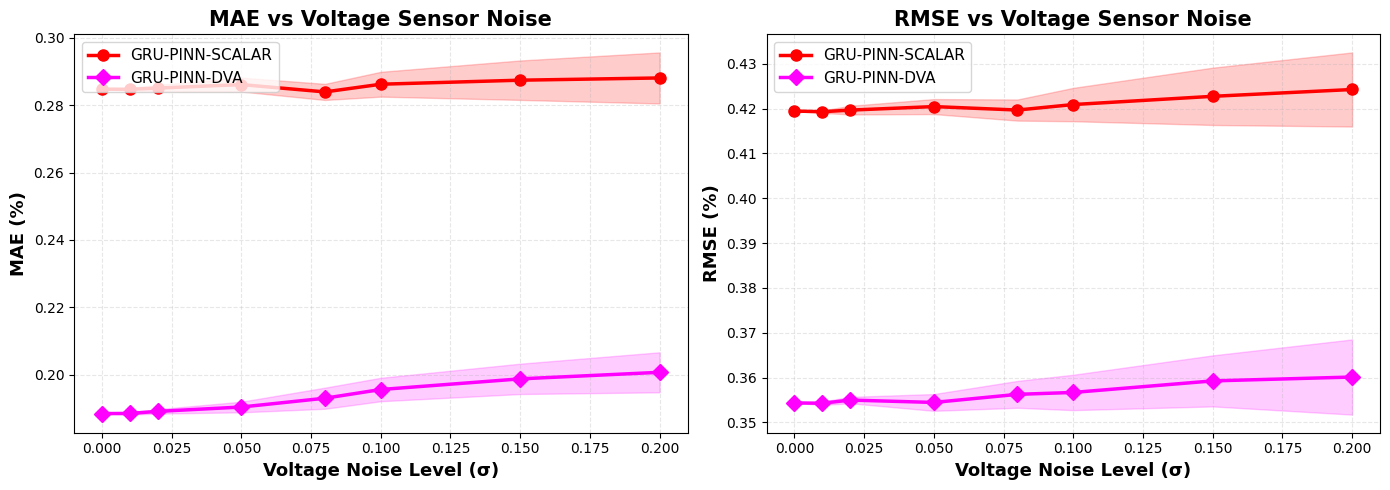


GRU-PINN MODEL COMPARISON: Voltage Noise Robustness

Noise σ      SCALAR MAE           DVA MAE              Improvement    
----------------------------------------------------------------------
0.0000        0.285 ± 0.000     0.188 ± 0.000     +33.8%
0.0100        0.285 ± 0.000     0.188 ± 0.000     +33.8%
0.0200        0.285 ± 0.001     0.189 ± 0.001     +33.7%
0.0500        0.286 ± 0.002     0.190 ± 0.002     +33.5%
0.0800        0.284 ± 0.002     0.193 ± 0.003     +32.0%
0.1000        0.286 ± 0.004     0.196 ± 0.003     +31.7%
0.1500        0.287 ± 0.006     0.199 ± 0.005     +30.9%
0.2000        0.288 ± 0.008     0.201 ± 0.006     +30.3%

SUMMARY:
----------------------------------------------------------------------
Average improvement (DVA vs SCALAR): +32.5%

Acceptable voltage noise threshold (MAE < 2x baseline):
  GRU-PINN-SCALAR: σ ≤ 0.2000
  GRU-PINN-DVA:    σ ≤ 0.2000


Generating detailed prediction plots for Cell 5...


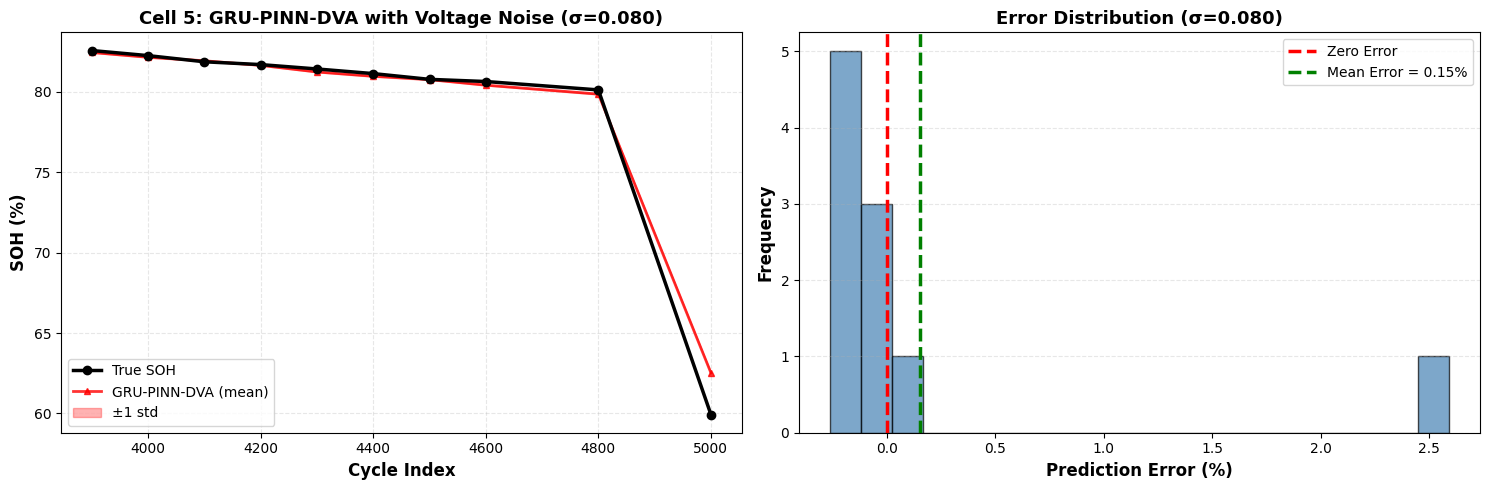


DETAILED PERFORMANCE TABLE

Model                Noise σ    MAE (%)         RMSE (%)        CV (%)    
----------------------------------------------------------------------
GRU-PINN-SCALAR      0.0000     0.285±0.000  0.419±0.000    0.0
GRU-PINN-DVA         0.0000     0.188±0.000  0.354±0.000    0.0
GRU-PINN-SCALAR      0.0500     0.286±0.002  0.420±0.002    0.7
GRU-PINN-DVA         0.0500     0.190±0.002  0.354±0.002    0.8
GRU-PINN-SCALAR      0.1000     0.286±0.004  0.421±0.004    1.3
GRU-PINN-DVA         0.1000     0.196±0.003  0.357±0.004    1.8
GRU-PINN-SCALAR      0.2000     0.288±0.008  0.424±0.008    2.6
GRU-PINN-DVA         0.2000     0.201±0.006  0.360±0.008    3.0

INTERPRETATION GUIDE:

1. VOLTAGE NOISE LEVELS (normalized units after preprocessing):
   - σ = 0.00 : Clean data (no noise)
   - σ = 0.01 : Very high quality voltage sensor (~0.25% error)
   - σ = 0.05 : Good quality voltage sensor (~1% error)
   - σ = 0.10 : Standard industrial sensor (~2% error)
   - σ = 0.2

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ============================================================
# Voltage Sensor Noise Testing for GRU-PINN Models Only
# ============================================================

def add_voltage_noise(X, noise_level, noise_type='gaussian'):
    """
    Add sensor noise to voltage feature only.
    
    Args:
        X: Input array [N, L, 4] where features are [V, Q, HF1, HF2]
        noise_level: Standard deviation for gaussian or range for uniform
        noise_type: 'gaussian' or 'uniform'
    
    Returns:
        X_noisy: Noisy version of X with noise only on voltage (feature 0)
    """
    X_noisy = X.copy()
    
    if noise_type == 'gaussian':
        # Add Gaussian noise to voltage channel only
        noise = np.random.normal(0, noise_level, X_noisy[:, :, 0].shape)
        X_noisy[:, :, 0] += noise
        
    elif noise_type == 'uniform':
        # Add uniform noise to voltage channel only
        noise = np.random.uniform(-noise_level, noise_level, X_noisy[:, :, 0].shape)
        X_noisy[:, :, 0] += noise
        
    return X_noisy


def evaluate_pinn_with_voltage_noise(model, X_test, y_test, noise_levels, 
                                      device, model_name='GRU-PINN', 
                                      num_trials=10):
    """
    Evaluate GRU-PINN model performance with voltage noise only.
    
    Args:
        model: Trained GRU-PINN PyTorch model
        X_test: Test input [N, L, 4]
        y_test: Test labels [N, 1]
        noise_levels: List of voltage noise standard deviations to test
        device: torch device
        model_name: Name for display
        num_trials: Number of noise realizations per noise level
    
    Returns:
        results: Dictionary with MAE, RMSE, and predictions for each noise level
    """
    model.eval()
    results = {
        'noise_levels': noise_levels,
        'mae_mean': [],
        'mae_std': [],
        'rmse_mean': [],
        'rmse_std': [],
        'predictions': [],
        'model_name': model_name
    }
    
    print(f"\nEvaluating {model_name} with voltage sensor noise...")
    print(f"Number of test samples: {len(X_test)}")
    print(f"Number of trials per noise level: {num_trials}")
    
    for noise_level in noise_levels:
        mae_trials = []
        rmse_trials = []
        preds_trials = []
        
        for trial in range(num_trials):
            # Add voltage noise only
            X_noisy = add_voltage_noise(X_test, noise_level, noise_type='gaussian')
            X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32).to(device)
            
            # Get predictions (both PINN models return two outputs)
            with torch.no_grad():
                soh_pred, _ = model(X_noisy_tensor)
                soh_pred = soh_pred.cpu().numpy().flatten()
            
            # Calculate metrics (convert to percentage)
            y_true_pct = y_test.flatten() * 100.0
            soh_pred_pct = soh_pred * 100.0
            
            mae = mean_absolute_error(y_true_pct, soh_pred_pct)
            rmse = np.sqrt(mean_squared_error(y_true_pct, soh_pred_pct))
            
            mae_trials.append(mae)
            rmse_trials.append(rmse)
            preds_trials.append(soh_pred_pct)
        
        results['mae_mean'].append(np.mean(mae_trials))
        results['mae_std'].append(np.std(mae_trials))
        results['rmse_mean'].append(np.mean(rmse_trials))
        results['rmse_std'].append(np.std(rmse_trials))
        results['predictions'].append(preds_trials)
        
        # Print progress
        print(f"  Noise σ={noise_level:.4f}: MAE = {results['mae_mean'][-1]:.3f} ± "
              f"{results['mae_std'][-1]:.3f}%, RMSE = {results['rmse_mean'][-1]:.3f} ± "
              f"{results['rmse_std'][-1]:.3f}%")
    
    return results


def plot_voltage_noise_robustness(results_dict, save_path=None):
    """
    Plot GRU-PINN models' performance vs voltage noise level.
    
    Args:
        results_dict: Dictionary with model names as keys and results as values
        save_path: Optional path to save the figure
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = {'GRU-PINN-SCALAR': 'red', 'GRU-PINN-DVA': 'magenta'}
    markers = {'GRU-PINN-SCALAR': 'o', 'GRU-PINN-DVA': 'D'}
    
    for model_name, results in results_dict.items():
        noise_levels = results['noise_levels']
        mae_mean = results['mae_mean']
        mae_std = results['mae_std']
        rmse_mean = results['rmse_mean']
        rmse_std = results['rmse_std']
        
        color = colors.get(model_name, 'blue')
        marker = markers.get(model_name, 'o')
        
        # MAE plot
        ax1.plot(noise_levels, mae_mean, marker=marker, color=color, 
                label=model_name, linewidth=2.5, markersize=8)
        ax1.fill_between(noise_levels, 
                         np.array(mae_mean) - np.array(mae_std),
                         np.array(mae_mean) + np.array(mae_std),
                         color=color, alpha=0.2)
        
        # RMSE plot
        ax2.plot(noise_levels, rmse_mean, marker=marker, color=color, 
                label=model_name, linewidth=2.5, markersize=8)
        ax2.fill_between(noise_levels,
                         np.array(rmse_mean) - np.array(rmse_std),
                         np.array(rmse_mean) + np.array(rmse_std),
                         color=color, alpha=0.2)
    
    ax1.set_xlabel('Voltage Noise Level (σ)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('MAE (%)', fontsize=13, fontweight='bold')
    ax1.set_title('MAE vs Voltage Sensor Noise', fontsize=15, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(fontsize=11, loc='upper left')
    
    ax2.set_xlabel('Voltage Noise Level (σ)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('RMSE (%)', fontsize=13, fontweight='bold')
    ax2.set_title('RMSE vs Voltage Sensor Noise', fontsize=15, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(fontsize=11, loc='upper left')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_pinn_predictions_with_noise(results, y_test, cell_ids_test, cycles_test,
                                      noise_idx=0, cell_to_plot=1, save_path=None):
    """
    Plot GRU-PINN predictions for a specific cell with voltage noise.
    
    Args:
        results: Results dictionary from evaluate_pinn_with_voltage_noise
        y_test: True SOH values
        cell_ids_test: Cell IDs for test samples
        cycles_test: Cycle numbers for test samples
        noise_idx: Index of noise level to visualize
        cell_to_plot: Which cell to plot (1-8)
        save_path: Optional path to save the figure
    """
    noise_level = results['noise_levels'][noise_idx]
    predictions = np.array(results['predictions'][noise_idx])  # [num_trials, N]
    
    # Filter for specific cell
    mask = (cell_ids_test == cell_to_plot)
    if mask.sum() == 0:
        print(f"Cell {cell_to_plot} has no test samples")
        return
    
    y_true_pct = (y_test.flatten() * 100.0)[mask]
    cyc_cell = cycles_test[mask]
    preds_cell = predictions[:, mask]  # [num_trials, N_cell]
    
    # Sort by cycle
    order = np.argsort(cyc_cell)
    cyc_cell = cyc_cell[order]
    y_true_pct = y_true_pct[order]
    preds_cell = preds_cell[:, order]
    
    mean_pred = preds_cell.mean(axis=0)
    std_pred = preds_cell.std(axis=0)
    
    model_name = results['model_name']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Predictions with uncertainty
    ax1.plot(cyc_cell, y_true_pct, 'ko-', label='True SOH', 
             linewidth=2.5, markersize=6, zorder=3)
    ax1.plot(cyc_cell, mean_pred, 'r^-', label=f'{model_name} (mean)', 
             linewidth=2, markersize=5, alpha=0.8, zorder=2)
    ax1.fill_between(cyc_cell, mean_pred - std_pred, mean_pred + std_pred,
                     color='red', alpha=0.3, label='±1 std', zorder=1)
    
    ax1.set_xlabel('Cycle Index', fontsize=12, fontweight='bold')
    ax1.set_ylabel('SOH (%)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Cell {cell_to_plot}: {model_name} with Voltage Noise (σ={noise_level:.3f})', 
                  fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 2: Error distribution
    errors = mean_pred - y_true_pct
    ax2.hist(errors, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
    ax2.axvline(errors.mean(), color='green', linestyle='--', linewidth=2.5, 
                label=f'Mean Error = {errors.mean():.2f}%')
    
    ax2.set_xlabel('Prediction Error (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title(f'Error Distribution (σ={noise_level:.3f})', 
                  fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def compare_pinn_models(results_scalar, results_dva):
    """
    Compare GRU-PINN-SCALAR vs GRU-PINN-DVA performance.
    
    Args:
        results_scalar: Results for GRU-PINN-SCALAR
        results_dva: Results for GRU-PINN-DVA
    """
    print("\n" + "="*70)
    print("GRU-PINN MODEL COMPARISON: Voltage Noise Robustness")
    print("="*70)
    
    noise_levels = results_scalar['noise_levels']
    
    print(f"\n{'Noise σ':<12} {'SCALAR MAE':<20} {'DVA MAE':<20} {'Improvement':<15}")
    print("-" * 70)
    
    for i, noise in enumerate(noise_levels):
        mae_s = results_scalar['mae_mean'][i]
        std_s = results_scalar['mae_std'][i]
        mae_d = results_dva['mae_mean'][i]
        std_d = results_dva['mae_std'][i]
        
        if mae_s > 0:
            improvement = ((mae_s - mae_d) / mae_s) * 100
        else:
            improvement = 0
        
        print(f"{noise:<12.4f} {mae_s:>6.3f} ± {std_s:<6.3f}   "
              f"{mae_d:>6.3f} ± {std_d:<6.3f}   {improvement:>+6.1f}%")
    
    # Summary statistics
    print("\n" + "="*70)
    print("SUMMARY:")
    print("-" * 70)
    
    # Average improvement
    improvements = [((results_scalar['mae_mean'][i] - results_dva['mae_mean'][i]) / 
                     results_scalar['mae_mean'][i] * 100) 
                    for i in range(len(noise_levels))]
    avg_improvement = np.mean(improvements)
    
    print(f"Average improvement (DVA vs SCALAR): {avg_improvement:+.1f}%")
    
    # Find acceptable noise threshold (where MAE < 2x baseline)
    baseline_scalar = results_scalar['mae_mean'][0]
    baseline_dva = results_dva['mae_mean'][0]
    
    threshold_scalar = None
    threshold_dva = None
    
    for i, noise in enumerate(noise_levels):
        if results_scalar['mae_mean'][i] > 2 * baseline_scalar and threshold_scalar is None:
            threshold_scalar = noise_levels[i-1] if i > 0 else 0
        if results_dva['mae_mean'][i] > 2 * baseline_dva and threshold_dva is None:
            threshold_dva = noise_levels[i-1] if i > 0 else 0
    
    if threshold_scalar is None:
        threshold_scalar = noise_levels[-1]
    if threshold_dva is None:
        threshold_dva = noise_levels[-1]
    
    print(f"\nAcceptable voltage noise threshold (MAE < 2x baseline):")
    print(f"  GRU-PINN-SCALAR: σ ≤ {threshold_scalar:.4f}")
    print(f"  GRU-PINN-DVA:    σ ≤ {threshold_dva:.4f}")
    
    if threshold_dva > threshold_scalar:
        extension = ((threshold_dva - threshold_scalar) / threshold_scalar) * 100
        print(f"  → DVA extends acceptable range by {extension:.1f}%")
    
    print("\n" + "="*70)


# ============================================================
# Main Execution: Test GRU-PINN Models with Voltage Noise
# ============================================================

print("\n" + "="*70)
print("GRU-PINN VOLTAGE SENSOR NOISE ROBUSTNESS TEST")
print("="*70)

# Define voltage noise levels to test (in normalized units)
# After normalization, these represent fractions of the voltage std
voltage_noise_levels = [0.0, 0.01, 0.02, 0.05, 0.08, 0.10, 0.15, 0.20]
num_trials = 15  # Number of noise realizations per level

# Test GRU-PINN-SCALAR
print("\n" + "-"*70)
print("Testing GRU-PINN-SCALAR...")
print("-"*70)
pinn_scalar_results = evaluate_pinn_with_voltage_noise(
    pinn_scalar_model, X_test, y_test_norm, voltage_noise_levels,
    device, model_name='GRU-PINN-SCALAR', num_trials=num_trials
)

# Test GRU-PINN-DVA
print("\n" + "-"*70)
print("Testing GRU-PINN-DVA...")
print("-"*70)
pinn_dva_results = evaluate_pinn_with_voltage_noise(
    pinn_dva_model, X_test, y_test_norm, voltage_noise_levels,
    device, model_name='GRU-PINN-DVA', num_trials=num_trials
)

# Store results
pinn_results = {
    'GRU-PINN-SCALAR': pinn_scalar_results,
    'GRU-PINN-DVA': pinn_dva_results
}

# Plot comparative results
print("\nGenerating comparison plots...")
plot_voltage_noise_robustness(pinn_results, 
                               save_path='voltage_noise_pinn_comparison.png')

# Compare models
compare_pinn_models(pinn_scalar_results, pinn_dva_results)

# Plot detailed predictions for a specific cell and noise level
# Example: Cell 5 at moderate noise (index 4 corresponds to σ=0.08)
print("\nGenerating detailed prediction plots for Cell 5...")
plot_pinn_predictions_with_noise(
    pinn_dva_results, y_test_norm, cell_ids_test, cycles_test,
    noise_idx=4, cell_to_plot=5, 
    save_path='cell5_pinn_dva_voltage_noise.png'
)

# Generate predictions table for key noise levels
print("\n" + "="*70)
print("DETAILED PERFORMANCE TABLE")
print("="*70)

key_indices = [0, 3, 5, 7]  # noise = 0.0, 0.05, 0.10, 0.20
print(f"\n{'Model':<20} {'Noise σ':<10} {'MAE (%)':<15} {'RMSE (%)':<15} {'CV (%)':<10}")
print("-" * 70)

for idx in key_indices:
    noise = voltage_noise_levels[idx]
    
    for model_name, results in pinn_results.items():
        mae_m = results['mae_mean'][idx]
        mae_s = results['mae_std'][idx]
        rmse_m = results['rmse_mean'][idx]
        rmse_s = results['rmse_std'][idx]
        cv = (mae_s / mae_m) * 100 if mae_m > 0 else 0
        
        print(f"{model_name:<20} {noise:<10.4f} "
              f"{mae_m:>5.3f}±{mae_s:<5.3f}  "
              f"{rmse_m:>5.3f}±{rmse_s:<5.3f}  "
              f"{cv:>5.1f}")

print("\n" + "="*70)
print("INTERPRETATION GUIDE:")
print("="*70)
print("""
1. VOLTAGE NOISE LEVELS (normalized units after preprocessing):
   - σ = 0.00 : Clean data (no noise)
   - σ = 0.01 : Very high quality voltage sensor (~0.25% error)
   - σ = 0.05 : Good quality voltage sensor (~1% error)
   - σ = 0.10 : Standard industrial sensor (~2% error)
   - σ = 0.20 : Poor quality sensor (~4% error)

2. WHAT TO LOOK FOR:
   - Flat curves = Robust to voltage noise
   - Narrow confidence bands = Consistent predictions
   - DVA consistently below SCALAR = Full physics helps
   
3. ACCEPTABLE PERFORMANCE:
   - MAE < 2.5% at σ=0.10 → Ready for deployment
   - MAE 2.5-4% at σ=0.10 → Acceptable with good sensors
   - MAE > 4% at σ=0.10 → Needs improvement

4. KEY METRICS:
   - Degradation: How much MAE increases from baseline
   - CV (Coefficient of Variation): Should be < 30% for stability
   - Improvement: DVA vs SCALAR at each noise level
""")

print("\nVoltage noise robustness testing completed!")


GRU-PINN-DVA: SOH PREDICTION VISUALIZATION WITH VOLTAGE NOISE

1. Generating SOH predictions for all cells...

Generating SOH predictions with voltage noise (σ=0.1)...
Number of noise trials: 15
  Cell 1: 16 samples, MAE=0.026%, RMSE=0.039%
  Cell 2: 15 samples, MAE=0.236%, RMSE=0.482%
  Cell 3: 16 samples, MAE=0.060%, RMSE=0.071%
  Cell 4: 10 samples, MAE=0.322%, RMSE=0.325%
  Cell 5: 10 samples, MAE=0.378%, RMSE=0.824%
  Cell 6: 10 samples, MAE=0.250%, RMSE=0.284%
  Cell 7: 16 samples, MAE=0.166%, RMSE=0.189%
  Cell 8: 16 samples, MAE=0.233%, RMSE=0.242%


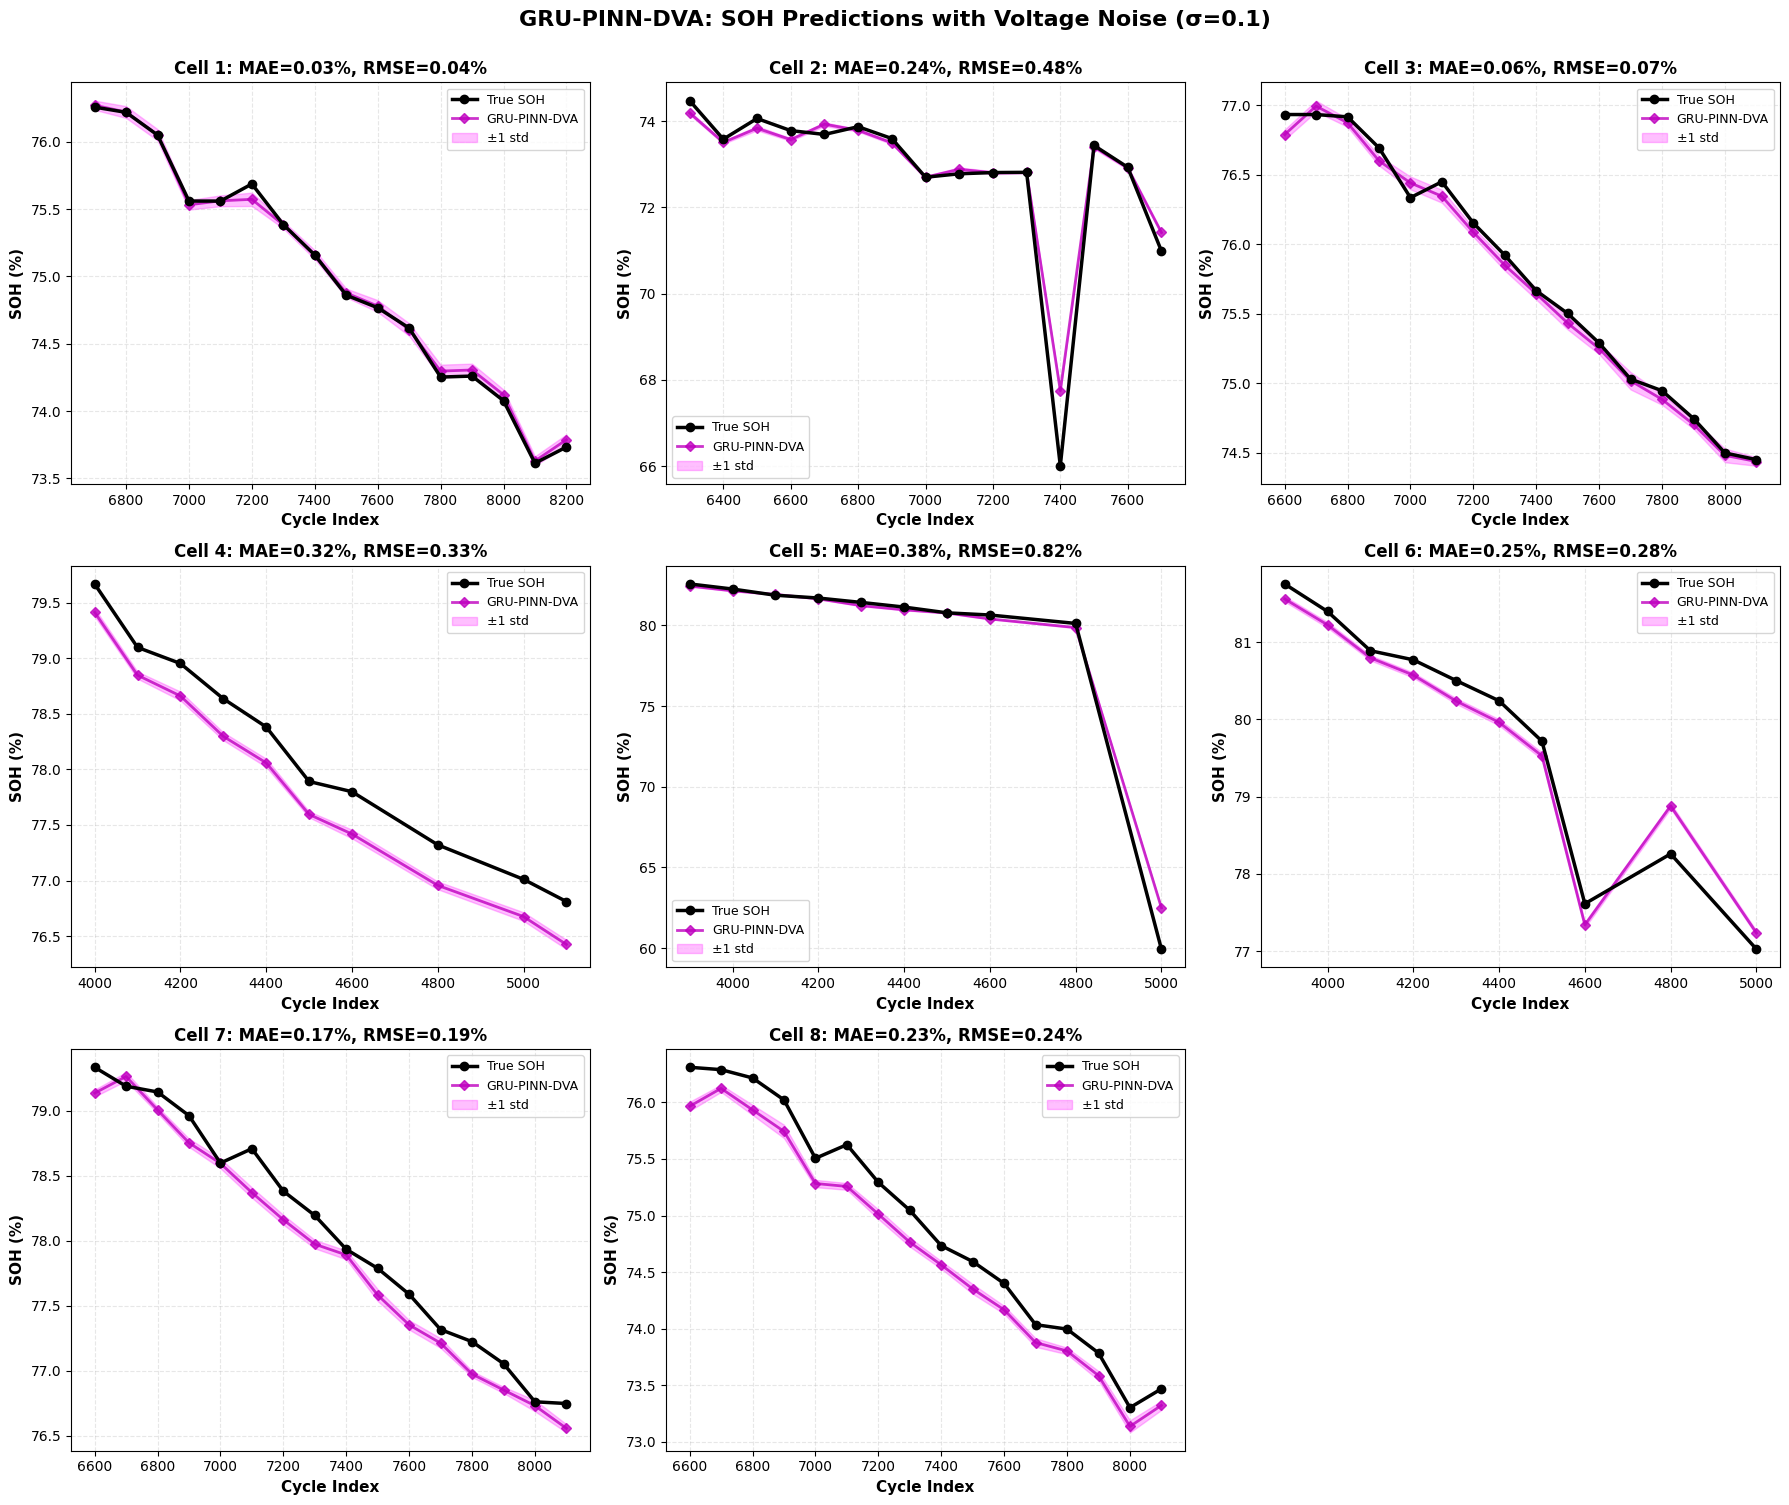


2. Generating detailed SOH predictions for Cell 5...

Generating detailed SOH predictions for Cell 5...
  Noise σ=0.000: MAE=0.380%, RMSE=0.831%
  Noise σ=0.050: MAE=0.380%, RMSE=0.830%
  Noise σ=0.100: MAE=0.378%, RMSE=0.831%
  Noise σ=0.200: MAE=0.379%, RMSE=0.826%


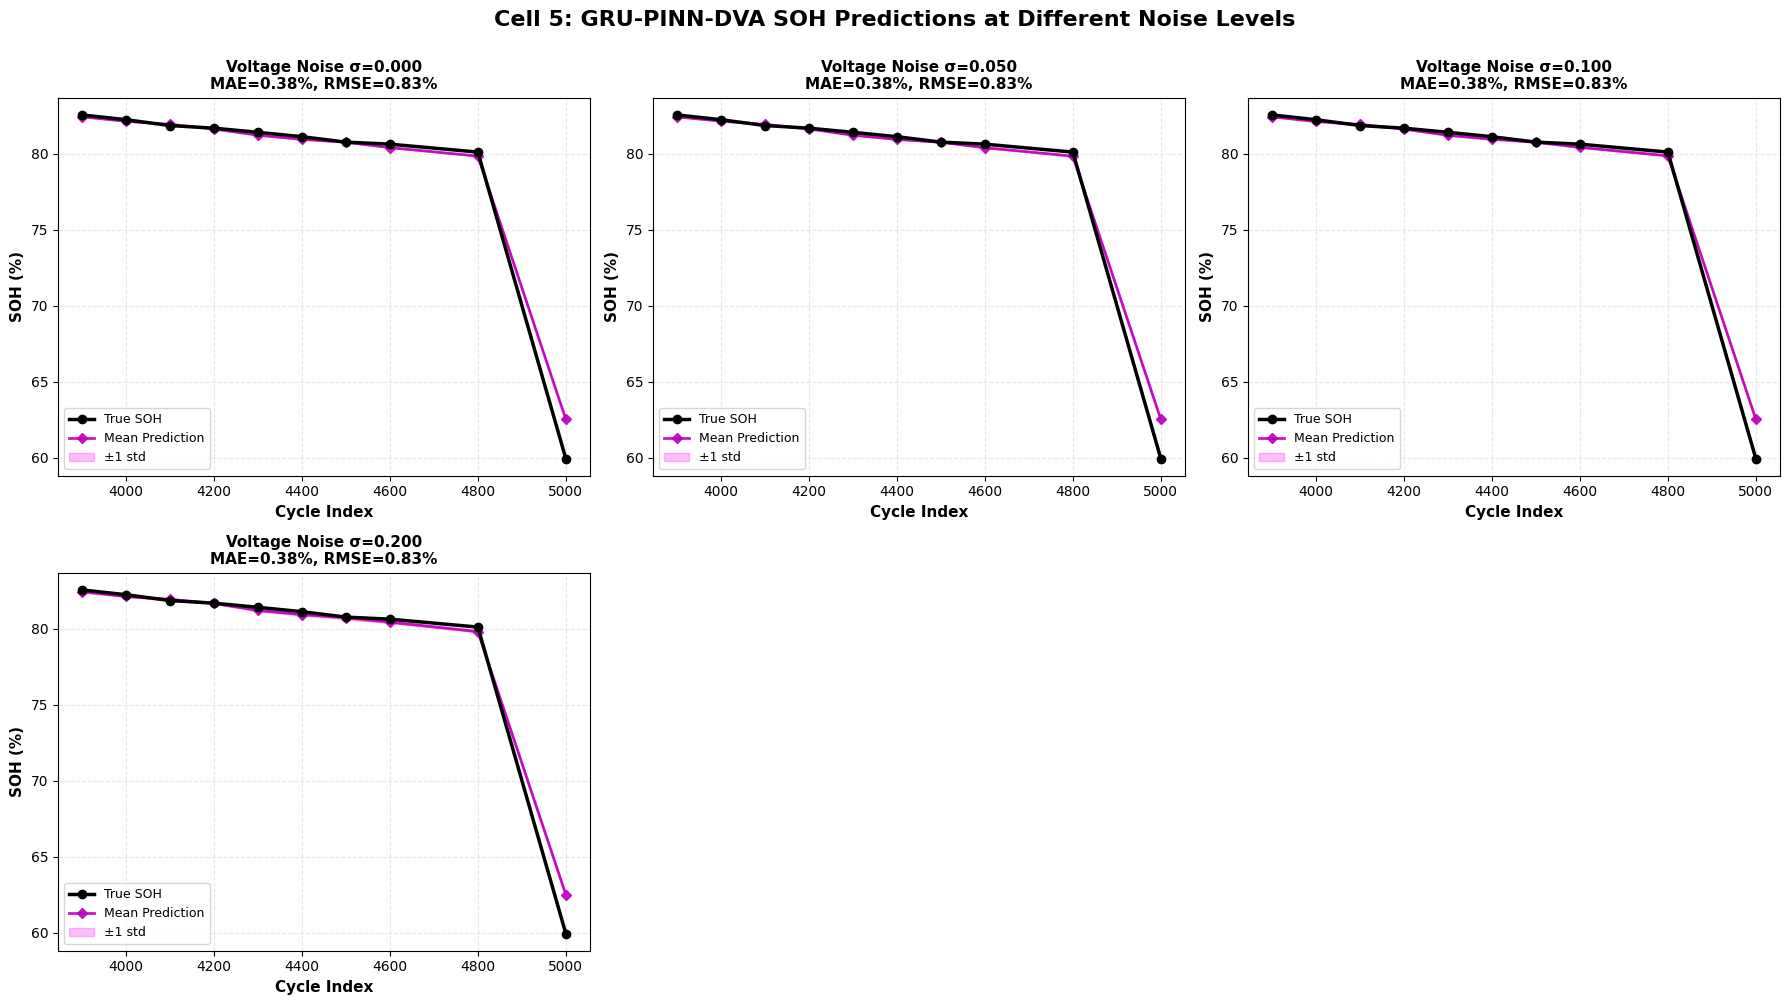


3. Generating clean vs noisy comparison...

Comparing clean vs noisy (σ=0.1) SOH predictions...
  Cell 1: Clean MAE=0.025%, Noisy MAE=0.030%
  Cell 2: Clean MAE=0.230%, Noisy MAE=0.229%
  Cell 3: Clean MAE=0.059%, Noisy MAE=0.058%
  Cell 4: Clean MAE=0.317%, Noisy MAE=0.311%
  Cell 5: Clean MAE=0.380%, Noisy MAE=0.379%
  Cell 6: Clean MAE=0.254%, Noisy MAE=0.252%
  Cell 7: Clean MAE=0.163%, Noisy MAE=0.163%
  Cell 8: Clean MAE=0.226%, Noisy MAE=0.229%


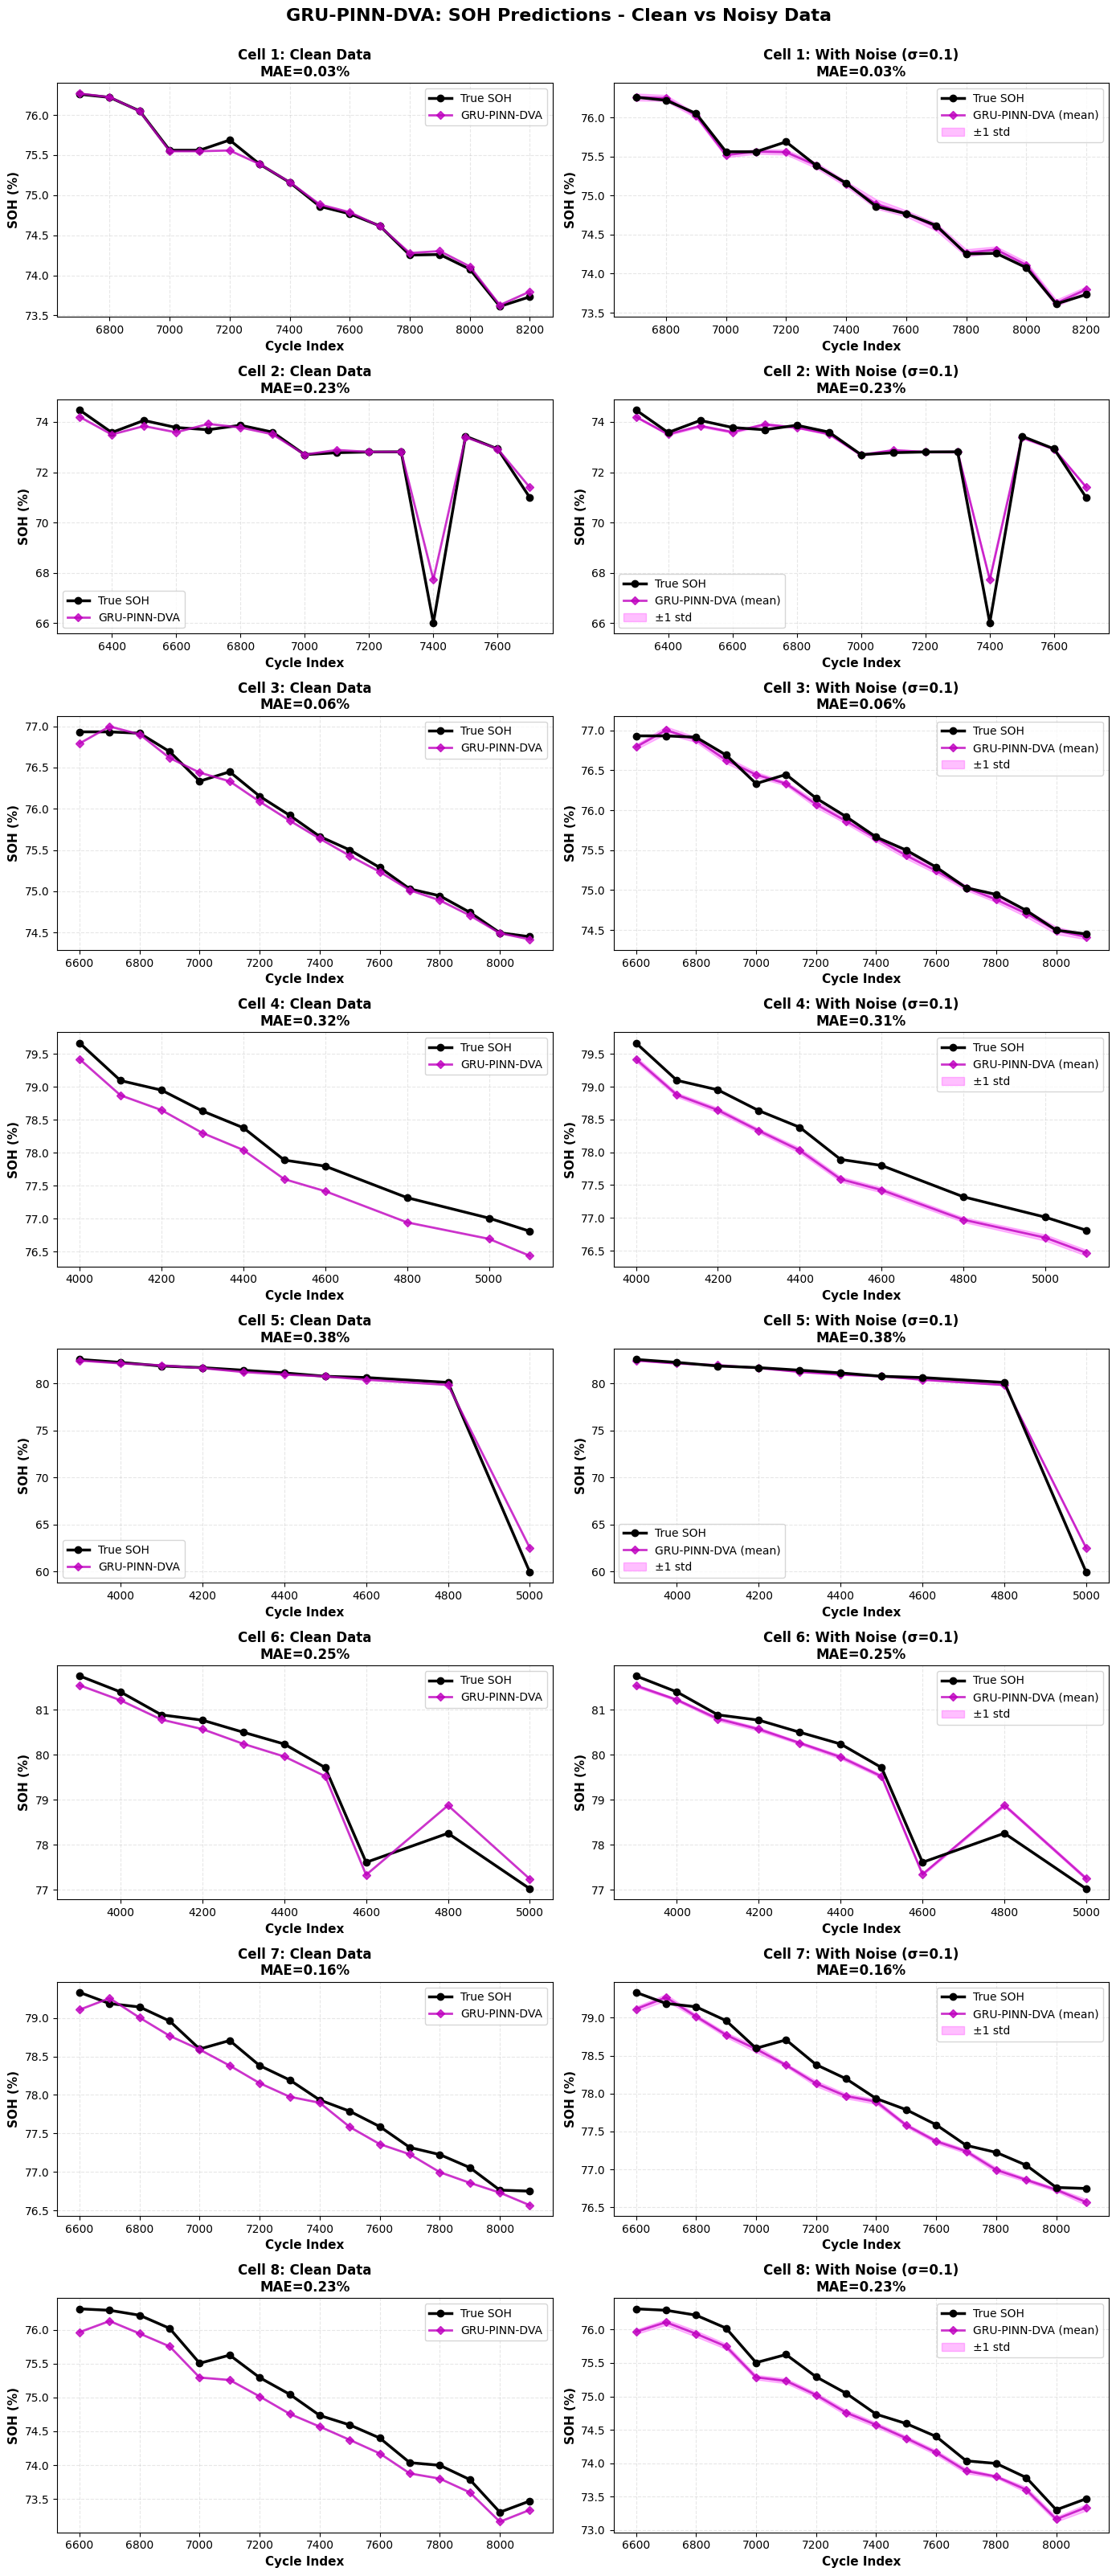


4. Generating error analysis...

Analyzing SOH prediction errors...


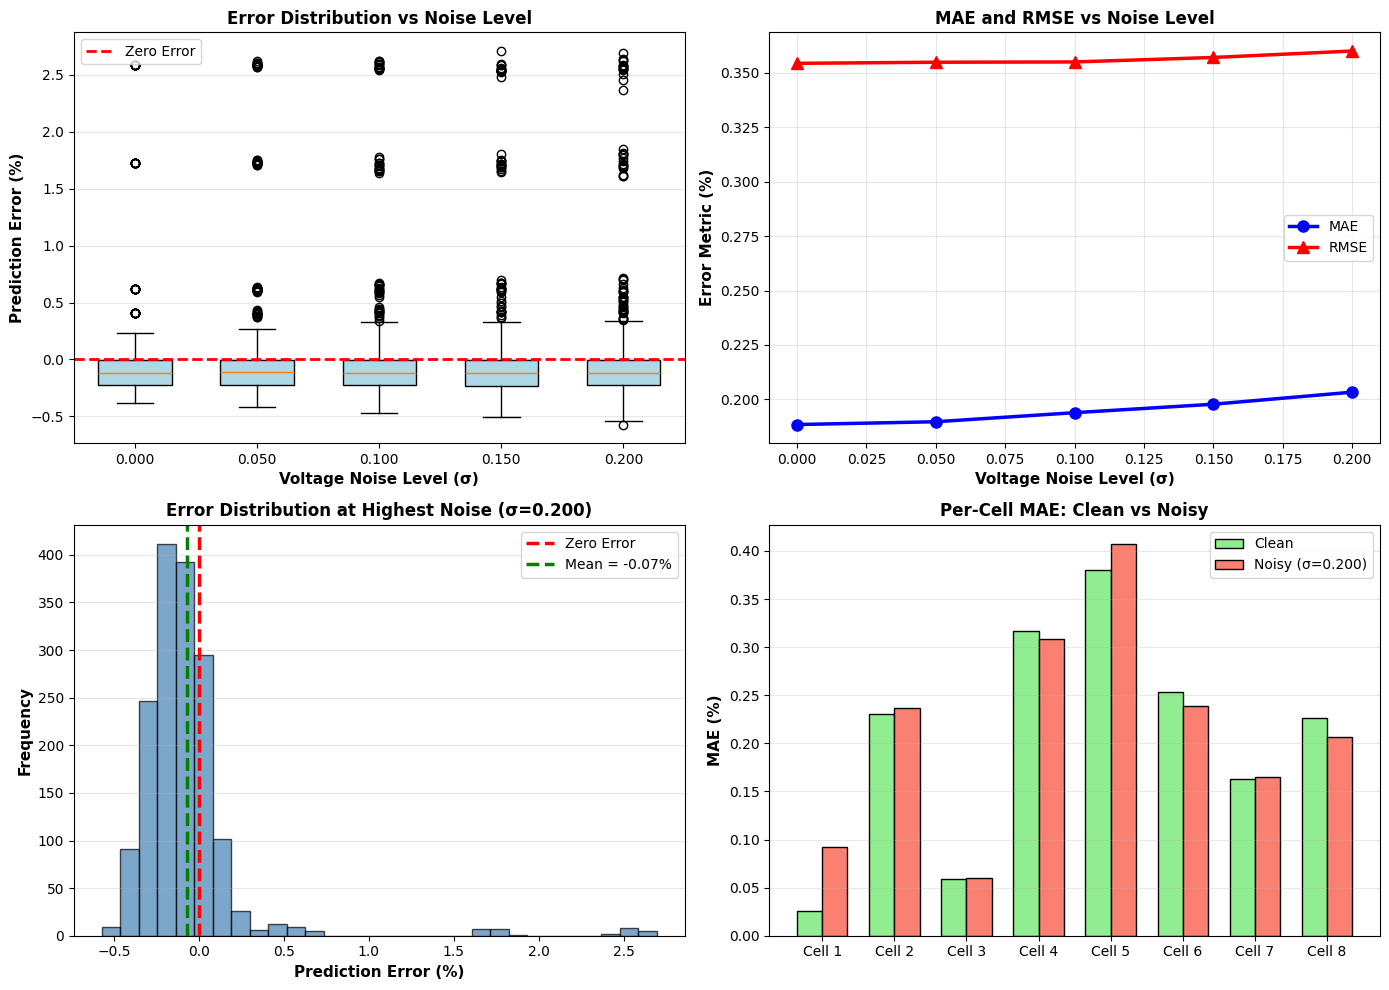


Error Analysis Summary:
Noise σ    MAE (%)    RMSE (%)  
------------------------------
0.000      0.188      0.354     
0.050      0.190      0.355     
0.100      0.194      0.355     
0.150      0.198      0.357     
0.200      0.203      0.360     

SOH PREDICTION VISUALIZATION COMPLETED!


In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ============================================================
# GRU-PINN-DVA SOH Prediction Visualization with Voltage Noise
# ============================================================

def plot_soh_predictions_all_cells(model, X_test, y_test, cell_ids_test, 
                                    cycles_test, noise_level, device, 
                                    num_trials=10, save_path=None):
    """
    Plot SOH predictions for all cells with voltage noise.
    
    Args:
        model: Trained GRU-PINN-DVA model
        X_test: Test input [N, L, 4]
        y_test: True SOH values [N, 1]
        cell_ids_test: Cell IDs
        cycles_test: Cycle numbers
        noise_level: Voltage noise standard deviation
        device: torch device
        num_trials: Number of noise trials
        save_path: Optional path to save figure
    """
    model.eval()
    
    # Get unique cells
    unique_cells = np.unique(cell_ids_test)
    n_cells = len(unique_cells)
    
    # Create subplot grid
    n_cols = 3
    n_rows = int(np.ceil(n_cells / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_cells > 1 else [axes]
    
    print(f"\nGenerating SOH predictions with voltage noise (σ={noise_level})...")
    print(f"Number of noise trials: {num_trials}")
    
    for idx, cell_id in enumerate(unique_cells):
        # Filter data for this cell
        mask = (cell_ids_test == cell_id)
        if mask.sum() == 0:
            axes[idx].set_visible(False)
            continue
        
        y_true = y_test[mask]
        cyc_cell = cycles_test[mask]
        X_cell = X_test[mask]
        
        # Sort by cycle
        order = np.argsort(cyc_cell)
        cyc_cell = cyc_cell[order]
        y_true = y_true[order]
        X_cell = X_cell[order]
        
        # Run predictions with noise
        all_preds = []
        for trial in range(num_trials):
            # Add voltage noise
            X_noisy = add_voltage_noise(X_cell, noise_level, noise_type='gaussian')
            X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                soh_pred, _ = model(X_noisy_tensor)
                soh_pred = soh_pred.cpu().numpy().flatten()
            
            all_preds.append(soh_pred * 100.0)  # Convert to percentage
        
        all_preds = np.array(all_preds)  # [num_trials, N_cell]
        mean_pred = all_preds.mean(axis=0)
        std_pred = all_preds.std(axis=0)
        
        y_true_pct = y_true.flatten() * 100.0
        
        # Calculate metrics
        mae = mean_absolute_error(y_true_pct, mean_pred)
        rmse = np.sqrt(mean_squared_error(y_true_pct, mean_pred))
        
        # Plot
        ax = axes[idx]
        ax.plot(cyc_cell, y_true_pct, 'ko-', label='True SOH', 
                linewidth=2.5, markersize=6, zorder=3)
        ax.plot(cyc_cell, mean_pred, 'mD-', label='GRU-PINN-DVA', 
                linewidth=2, markersize=5, alpha=0.8, zorder=2)
        ax.fill_between(cyc_cell, mean_pred - std_pred, mean_pred + std_pred,
                        color='magenta', alpha=0.25, label='±1 std', zorder=1)
        
        ax.set_xlabel('Cycle Index', fontsize=11, fontweight='bold')
        ax.set_ylabel('SOH (%)', fontsize=11, fontweight='bold')
        ax.set_title(f'Cell {cell_id}: MAE={mae:.2f}%, RMSE={rmse:.2f}%', 
                    fontsize=12, fontweight='bold')
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        print(f"  Cell {cell_id}: {mask.sum()} samples, MAE={mae:.3f}%, RMSE={rmse:.3f}%")
    
    # Hide unused subplots
    for idx in range(n_cells, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f'GRU-PINN-DVA: SOH Predictions with Voltage Noise (σ={noise_level})', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_soh_single_cell_detailed(model, X_test, y_test, cell_ids_test,
                                   cycles_test, cell_id, noise_levels,
                                   device, num_trials=10, save_path=None):
    """
    Detailed SOH prediction plot for a single cell across multiple noise levels.
    
    Args:
        model: Trained GRU-PINN-DVA model
        X_test: Test input
        y_test: True SOH values
        cell_ids_test: Cell IDs
        cycles_test: Cycle numbers
        cell_id: Which cell to plot
        noise_levels: List of noise levels to test
        device: torch device
        num_trials: Number of trials per noise level
        save_path: Optional save path
    """
    model.eval()
    
    # Filter for specific cell
    mask = (cell_ids_test == cell_id)
    if mask.sum() == 0:
        print(f"Cell {cell_id} has no test samples")
        return
    
    y_true = y_test[mask]
    cyc_cell = cycles_test[mask]
    X_cell = X_test[mask]
    
    # Sort by cycle
    order = np.argsort(cyc_cell)
    cyc_cell = cyc_cell[order]
    y_true = y_true[order]
    X_cell = X_cell[order]
    
    y_true_pct = y_true.flatten() * 100.0
    
    # Create subplots for different noise levels
    n_noise = len(noise_levels)
    n_cols = min(3, n_noise)
    n_rows = int(np.ceil(n_noise / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    if n_noise == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    print(f"\nGenerating detailed SOH predictions for Cell {cell_id}...")
    
    for idx, noise in enumerate(noise_levels):
        # Run predictions with noise
        all_preds = []
        for trial in range(num_trials):
            X_noisy = add_voltage_noise(X_cell, noise, noise_type='gaussian')
            X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                soh_pred, _ = model(X_noisy_tensor)
                soh_pred = soh_pred.cpu().numpy().flatten()
            
            all_preds.append(soh_pred * 100.0)
        
        all_preds = np.array(all_preds)
        mean_pred = all_preds.mean(axis=0)
        std_pred = all_preds.std(axis=0)
        
        # Calculate metrics
        mae = mean_absolute_error(y_true_pct, mean_pred)
        rmse = np.sqrt(mean_squared_error(y_true_pct, mean_pred))
        
        # Plot individual trials (light lines)
        ax = axes[idx]
        for trial_pred in all_preds[:5]:  # Show first 5 trials
            ax.plot(cyc_cell, trial_pred, 'r-', linewidth=0.5, alpha=0.2)
        
        # Plot mean and true
        ax.plot(cyc_cell, y_true_pct, 'ko-', label='True SOH', 
                linewidth=2.5, markersize=6, zorder=3)
        ax.plot(cyc_cell, mean_pred, 'mD-', label='Mean Prediction', 
                linewidth=2, markersize=5, alpha=0.9, zorder=2)
        ax.fill_between(cyc_cell, mean_pred - std_pred, mean_pred + std_pred,
                        color='magenta', alpha=0.25, label='±1 std', zorder=1)
        
        ax.set_xlabel('Cycle Index', fontsize=11, fontweight='bold')
        ax.set_ylabel('SOH (%)', fontsize=11, fontweight='bold')
        ax.set_title(f'Voltage Noise σ={noise:.3f}\nMAE={mae:.2f}%, RMSE={rmse:.2f}%', 
                    fontsize=11, fontweight='bold')
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        print(f"  Noise σ={noise:.3f}: MAE={mae:.3f}%, RMSE={rmse:.3f}%")
    
    # Hide unused subplots
    for idx in range(n_noise, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f'Cell {cell_id}: GRU-PINN-DVA SOH Predictions at Different Noise Levels', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_soh_comparison_clean_vs_noisy(model, X_test, y_test, cell_ids_test,
                                        cycles_test, noise_level, device,
                                        num_trials=10, save_path=None):
    """
    Compare clean vs noisy SOH predictions for all cells side-by-side.
    
    Args:
        model: Trained GRU-PINN-DVA model
        X_test: Test input
        y_test: True SOH
        cell_ids_test: Cell IDs
        cycles_test: Cycle numbers
        noise_level: Voltage noise level for comparison
        device: torch device
        num_trials: Number of noise trials
        save_path: Optional save path
    """
    model.eval()
    
    unique_cells = np.unique(cell_ids_test)
    n_cells = len(unique_cells)
    
    fig, axes = plt.subplots(n_cells, 2, figsize=(14, 4*n_cells))
    if n_cells == 1:
        axes = axes.reshape(1, -1)
    
    print(f"\nComparing clean vs noisy (σ={noise_level}) SOH predictions...")
    
    for idx, cell_id in enumerate(unique_cells):
        mask = (cell_ids_test == cell_id)
        if mask.sum() == 0:
            continue
        
        y_true = y_test[mask]
        cyc_cell = cycles_test[mask]
        X_cell = X_test[mask]
        
        # Sort by cycle
        order = np.argsort(cyc_cell)
        cyc_cell = cyc_cell[order]
        y_true = y_true[order]
        X_cell = X_cell[order]
        
        y_true_pct = y_true.flatten() * 100.0
        
        # Clean prediction
        X_tensor = torch.tensor(X_cell, dtype=torch.float32).to(device)
        with torch.no_grad():
            soh_clean, _ = model(X_tensor)
            soh_clean = soh_clean.cpu().numpy().flatten() * 100.0
        
        # Noisy predictions
        all_preds_noisy = []
        for trial in range(num_trials):
            X_noisy = add_voltage_noise(X_cell, noise_level, noise_type='gaussian')
            X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                soh_pred, _ = model(X_noisy_tensor)
                soh_pred = soh_pred.cpu().numpy().flatten()
            
            all_preds_noisy.append(soh_pred * 100.0)
        
        all_preds_noisy = np.array(all_preds_noisy)
        mean_pred_noisy = all_preds_noisy.mean(axis=0)
        std_pred_noisy = all_preds_noisy.std(axis=0)
        
        # Metrics
        mae_clean = mean_absolute_error(y_true_pct, soh_clean)
        mae_noisy = mean_absolute_error(y_true_pct, mean_pred_noisy)
        
        # Plot clean
        ax_clean = axes[idx, 0]
        ax_clean.plot(cyc_cell, y_true_pct, 'ko-', label='True SOH', 
                     linewidth=2.5, markersize=6)
        ax_clean.plot(cyc_cell, soh_clean, 'mD-', label='GRU-PINN-DVA', 
                     linewidth=2, markersize=5, alpha=0.8)
        ax_clean.set_xlabel('Cycle Index', fontsize=11, fontweight='bold')
        ax_clean.set_ylabel('SOH (%)', fontsize=11, fontweight='bold')
        ax_clean.set_title(f'Cell {cell_id}: Clean Data\nMAE={mae_clean:.2f}%', 
                          fontsize=12, fontweight='bold')
        ax_clean.legend(fontsize=10)
        ax_clean.grid(True, alpha=0.3, linestyle='--')
        
        # Plot noisy
        ax_noisy = axes[idx, 1]
        ax_noisy.plot(cyc_cell, y_true_pct, 'ko-', label='True SOH', 
                     linewidth=2.5, markersize=6, zorder=3)
        ax_noisy.plot(cyc_cell, mean_pred_noisy, 'mD-', label='GRU-PINN-DVA (mean)', 
                     linewidth=2, markersize=5, alpha=0.8, zorder=2)
        ax_noisy.fill_between(cyc_cell, mean_pred_noisy - std_pred_noisy, 
                             mean_pred_noisy + std_pred_noisy,
                             color='magenta', alpha=0.25, label='±1 std', zorder=1)
        ax_noisy.set_xlabel('Cycle Index', fontsize=11, fontweight='bold')
        ax_noisy.set_ylabel('SOH (%)', fontsize=11, fontweight='bold')
        ax_noisy.set_title(f'Cell {cell_id}: With Noise (σ={noise_level})\nMAE={mae_noisy:.2f}%', 
                          fontsize=12, fontweight='bold')
        ax_noisy.legend(fontsize=10)
        ax_noisy.grid(True, alpha=0.3, linestyle='--')
        
        print(f"  Cell {cell_id}: Clean MAE={mae_clean:.3f}%, Noisy MAE={mae_noisy:.3f}%")
    
    fig.suptitle('GRU-PINN-DVA: SOH Predictions - Clean vs Noisy Data', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_soh_error_analysis(model, X_test, y_test, cell_ids_test, cycles_test,
                             noise_levels, device, num_trials=10, save_path=None):
    """
    Analyze SOH prediction errors across noise levels.
    
    Args:
        model: GRU-PINN-DVA model
        X_test: Test input
        y_test: True SOH
        cell_ids_test: Cell IDs
        cycles_test: Cycle numbers
        noise_levels: List of noise levels
        device: torch device
        num_trials: Number of trials
        save_path: Optional save path
    """
    model.eval()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    all_errors = {noise: [] for noise in noise_levels}
    all_mae = []
    all_rmse = []
    
    print(f"\nAnalyzing SOH prediction errors...")
    
    for noise in noise_levels:
        errors_at_noise = []
        
        for trial in range(num_trials):
            X_noisy = add_voltage_noise(X_test, noise, noise_type='gaussian')
            X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                soh_pred, _ = model(X_noisy_tensor)
                soh_pred = soh_pred.cpu().numpy().flatten()
            
            y_true_pct = y_test.flatten() * 100.0
            soh_pred_pct = soh_pred * 100.0
            
            errors = soh_pred_pct - y_true_pct
            errors_at_noise.extend(errors)
        
        all_errors[noise] = np.array(errors_at_noise)
        all_mae.append(np.mean(np.abs(all_errors[noise])))
        all_rmse.append(np.sqrt(np.mean(all_errors[noise]**2)))
    
    # Plot 1: Error distribution at different noise levels
    ax1 = axes[0, 0]
    positions = range(len(noise_levels))
    bp = ax1.boxplot([all_errors[n] for n in noise_levels], positions=positions,
                      widths=0.6, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    ax1.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax1.set_xticks(positions)
    ax1.set_xticklabels([f'{n:.3f}' for n in noise_levels])
    ax1.set_xlabel('Voltage Noise Level (σ)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Prediction Error (%)', fontsize=11, fontweight='bold')
    ax1.set_title('Error Distribution vs Noise Level', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.legend()
    
    # Plot 2: MAE and RMSE vs noise
    ax2 = axes[0, 1]
    ax2.plot(noise_levels, all_mae, 'bo-', label='MAE', linewidth=2.5, markersize=8)
    ax2.plot(noise_levels, all_rmse, 'r^-', label='RMSE', linewidth=2.5, markersize=8)
    ax2.set_xlabel('Voltage Noise Level (σ)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Error Metric (%)', fontsize=11, fontweight='bold')
    ax2.set_title('MAE and RMSE vs Noise Level', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Error histogram at highest noise
    ax3 = axes[1, 0]
    highest_noise = noise_levels[-1]
    errors_high = all_errors[highest_noise]
    ax3.hist(errors_high, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax3.axvline(0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
    ax3.axvline(errors_high.mean(), color='green', linestyle='--', linewidth=2.5,
               label=f'Mean = {errors_high.mean():.2f}%')
    ax3.set_xlabel('Prediction Error (%)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax3.set_title(f'Error Distribution at Highest Noise (σ={highest_noise:.3f})', 
                 fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Per-cell MAE comparison
    ax4 = axes[1, 1]
    unique_cells = np.unique(cell_ids_test)
    cell_mae_clean = []
    cell_mae_noisy = []
    
    for cell_id in unique_cells:
        mask = (cell_ids_test == cell_id)
        if mask.sum() == 0:
            continue
        
        # Clean
        X_cell = X_test[mask]
        y_cell = y_test[mask]
        X_tensor = torch.tensor(X_cell, dtype=torch.float32).to(device)
        with torch.no_grad():
            soh_clean, _ = model(X_tensor)
            soh_clean = soh_clean.cpu().numpy().flatten() * 100.0
        mae_clean = mean_absolute_error(y_cell.flatten() * 100.0, soh_clean)
        
        # Noisy
        X_noisy = add_voltage_noise(X_cell, noise_levels[-1], noise_type='gaussian')
        X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32).to(device)
        with torch.no_grad():
            soh_noisy, _ = model(X_noisy_tensor)
            soh_noisy = soh_noisy.cpu().numpy().flatten() * 100.0
        mae_noisy = mean_absolute_error(y_cell.flatten() * 100.0, soh_noisy)
        
        cell_mae_clean.append(mae_clean)
        cell_mae_noisy.append(mae_noisy)
    
    x_pos = np.arange(len(unique_cells))
    width = 0.35
    ax4.bar(x_pos - width/2, cell_mae_clean, width, label='Clean', color='lightgreen', edgecolor='black')
    ax4.bar(x_pos + width/2, cell_mae_noisy, width, label=f'Noisy (σ={noise_levels[-1]:.3f})', 
           color='salmon', edgecolor='black')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'Cell {c}' for c in unique_cells])
    ax4.set_ylabel('MAE (%)', fontsize=11, fontweight='bold')
    ax4.set_title('Per-Cell MAE: Clean vs Noisy', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nError Analysis Summary:")
    print(f"{'Noise σ':<10} {'MAE (%)':<10} {'RMSE (%)':<10}")
    print("-" * 30)
    for noise, mae, rmse in zip(noise_levels, all_mae, all_rmse):
        print(f"{noise:<10.3f} {mae:<10.3f} {rmse:<10.3f}")


# ============================================================
# Execute SOH Prediction Visualizations
# ============================================================

print("\n" + "="*70)
print("GRU-PINN-DVA: SOH PREDICTION VISUALIZATION WITH VOLTAGE NOISE")
print("="*70)

# 1. Show SOH predictions for all cells at moderate noise
print("\n1. Generating SOH predictions for all cells...")
plot_soh_predictions_all_cells(
    pinn_dva_model, X_test, y_test_norm, cell_ids_test, cycles_test,
    noise_level=0.10, device=device, num_trials=15,
    save_path='soh_all_cells_noise_0.10.png'
)

# 2. Detailed view of one cell across multiple noise levels
print("\n2. Generating detailed SOH predictions for Cell 5...")
plot_soh_single_cell_detailed(
    pinn_dva_model, X_test, y_test_norm, cell_ids_test, cycles_test,
    cell_id=5, noise_levels=[0.0, 0.05, 0.10, 0.20],
    device=device, num_trials=15,
    save_path='soh_cell5_multiple_noise.png'
)

# 3. Clean vs Noisy comparison
print("\n3. Generating clean vs noisy comparison...")
plot_soh_comparison_clean_vs_noisy(
    pinn_dva_model, X_test, y_test_norm, cell_ids_test, cycles_test,
    noise_level=0.10, device=device, num_trials=15,
    save_path='soh_clean_vs_noisy_comparison.png'
)

# 4. Error analysis
print("\n4. Generating error analysis...")
plot_soh_error_analysis(
    pinn_dva_model, X_test, y_test_norm, cell_ids_test, cycles_test,
    noise_levels=[0.0, 0.05, 0.10, 0.15, 0.20],
    device=device, num_trials=15,
    save_path='soh_error_analysis.png'
)

print("\n" + "="*70)
print("SOH PREDICTION VISUALIZATION COMPLETED!")
print("="*70)

In [1]:
import torch
import torch.nn as nn

# ============================================================
# Model Definitions
# ============================================================

class LSTM_HF_VQ_SOH(nn.Module):
    """
    LSTM model that takes [B, L, 4] = [V, Q, HF1, HF2] and outputs
    a scalar SOH per sequence.
    """
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        soh = self.fc(last)
        return soh


class GRU_HF_VQ_SOH(nn.Module):
    """
    GRU model that takes [B, L, 4] = [V, Q, HF1, HF2] and outputs
    a scalar SOH per sequence.
    """
    def __init__(self, input_dim=4, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        soh = self.fc(last)
        return soh


# ============================================================
# Print Model Information
# ============================================================

def print_model_info(model, model_name="Model"):
    """Print model architecture details and parameter counts"""
    print(f"\n{'='*70}")
    print(f"{model_name} Configuration & Parameters")
    print(f"{'='*70}")
    
    # Model architecture
    print(f"\nArchitecture:\n{model}")
    
    # Count parameters by layer
    total_params = 0
    trainable_params = 0
    
    print(f"\n{'Layer':<40} {'Parameters':>15} {'Trainable':>10}")
    print("-" * 70)
    
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count
        
        print(f"{name:<40} {param_count:>15,} {str(param.requires_grad):>10}")
    
    print("-" * 70)
    print(f"{'Total Parameters':<40} {total_params:>15,}")
    print(f"{'Trainable Parameters':<40} {trainable_params:>15,}")
    print(f"{'Non-trainable Parameters':<40} {(total_params - trainable_params):>15,}")
    
    # Model size in MB
    param_size = total_params * 4 / (1024 ** 2)  # Assuming float32
    print(f"{'Model Size (float32)':<40} {param_size:>12.2f} MB")
    print(f"{'='*70}\n")


# ============================================================
# Create and Compare Models
# ============================================================

# Configuration
INPUT_DIM = 4
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.2

# Create models
lstm_model = LSTM_HF_VQ_SOH(
    input_dim=INPUT_DIM,
    hidden=HIDDEN_SIZE,
    layers=NUM_LAYERS,
    dropout=DROPOUT
)

gru_model = GRU_HF_VQ_SOH(
    input_dim=INPUT_DIM,
    hidden=HIDDEN_SIZE,
    layers=NUM_LAYERS,
    dropout=DROPOUT
)

# Print configurations
print_model_info(lstm_model, "LSTM Model (HF+VQ → SOH)")
print_model_info(gru_model, "GRU Model (HF+VQ → SOH)")

# Comparison
print(f"\n{'='*70}")
print("Model Comparison")
print(f"{'='*70}")
lstm_params = sum(p.numel() for p in lstm_model.parameters())
gru_params = sum(p.numel() for p in gru_model.parameters())
print(f"LSTM Parameters: {lstm_params:,}")
print(f"GRU Parameters:  {gru_params:,}")
print(f"Difference:      {abs(lstm_params - gru_params):,} ({((lstm_params/gru_params - 1)*100):.1f}% more in LSTM)")
print(f"{'='*70}\n")


LSTM Model (HF+VQ → SOH) Configuration & Parameters

Architecture:
LSTM_HF_VQ_SOH(
  (lstm): LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Layer                                         Parameters  Trainable
----------------------------------------------------------------------
lstm.weight_ih_l0                                  2,048       True
lstm.weight_hh_l0                                 65,536       True
lstm.bias_ih_l0                                      512       True
lstm.bias_hh_l0                                      512       True
lstm.weight_ih_l1                                 65,536       True
lstm.weight_hh_l1                                 65,536       True
lstm.bias_ih_l1                                      512       True
lstm.bias_hh_l1                                      512       True
fc.weight                                            128       True
fc.bias                            